## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(np.array(self.df.iloc[index]))
        label = torch.tensor(np.array([self.price.iloc[index]]))
        return {"sample": sample, "label": label}
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=0)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', None)
train_df.head(5)

host_is_superhost  latitude  longitude  property_type  room_type  \
0                  0 -0.396491   0.215068      -0.444532  -0.686927   
1                  0 -0.841516   0.095963       1.182045  -0.686927   
2                  0 -0.725178  -0.909397      -0.444532   1.329375   
3                  0 -0.048882   0.086232      -0.444532  -0.686927   
4                  0 -0.635052   0.094278      -0.444532  -0.686927   

   accommodates  bathrooms  bedrooms      beds     price  instant_bookable  \
0     -0.597957  -0.436242 -0.353343 -0.650700  0.438466                 0   
1     -0.597957  -0.436242 -0.353343 -0.650700  2.623250                 0   
2     -0.597957  -0.436242 -0.353343 -0.650700 -1.027833                 1   
3     -0.597957  -0.436242 -1.660357 -0.650700  1.171615                 0   
4     -0.030463  -0.436242  0.953672  0.389812  1.010322                 0   

   cancellation_policy  amenities_Kitchen  amenities_Heating  \
0             1.160642                  1                  1   
1            -1.125796                  1                  1   
2            -1.125796                  1                  1   
3            -0.422277                  1                  1   
4             1.160642                  1                  1   

   amenities_Washer  amenities_Wifi  amenities_Indoor fireplace  \
0                 1               1                           0   
1                 1               1                           0   
2                 1               1                           0   
3                 1               1                           0   
4                 1               1                           0   

   amenities_Iron  amenities_Laptop friendly workspace  amenities_Crib  \
0               1                                    1               0   
1               1                                    1               0   
2               0                                    0               0   
3               0                                    0               0   
4               1                                    1               0   

   amenities_Self check-in  amenities_Carbon monoxide detector  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   1   

   amenities_Shampoo  amenities_Air conditioning  amenities_Dryer  \
0                  1                           1                1   
1                  1                           1                1   
2                  1                           1                1   
3                  0                           1                1   
4                  0                           1                1   

   amenities_Breakfast  amenities_Hangers  amenities_Hair dryer  amenities_TV  \
0                    1                  0                     1             1   
1                    0                  1                     1             1   
2                    0                  0                     0             1   
3                    0                  1                     0             1   
4                    0                  1                     1             1   

   amenities_High chair  amenities_Smoke detector  amenities_Private bathroom  \
0                     0                         1                           0   
1                     0                         1                           0   
2                     0                         1                           0   
3                     0                         1                           0   
4                     0                         1                           0   

   amenities_count  facilities_Free parking on premises  facilities_Gym  \
0         0.2

#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

mean        std
price                120.097102  68.198942
latitude              43.677492   0.046110
longitude            -79.398326   0.059359
property_type          2.819879   1.844364
room_type              0.340686   0.495957
accommodates           3.053679   1.762132
bathrooms              1.200374   0.459320
bedrooms               1.270343   0.765102
beds                   1.625366   0.961066
cancellation_policy    7.400940   5.685699
amenities_count       12.185917   2.775618
facilities_count       1.065138   1.181071
house_rules_count      0.184610   0.449641

## Define Model

In [43]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*2)
        self.layer2 = nn.Linear(41*2, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*1)
        self.layer5 = nn.Linear(41*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        return self.layer5(x)

## Training Function

In [45]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"].float()
            label = data["label"].float()
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 0.772463  time: 3.546
---[ITER 20] loss: 0.767741  time: 3.294
---[ITER 30] loss: 0.756096  time: 3.720
---[ITER 40] loss: 0.751573  time: 3.147
---[ITER 50] loss: 0.760435  time: 3.207
---[ITER 60] loss: 0.743891  time: 3.261
---[ITER 70] loss: 0.745147  time: 3.173
---[ITER 80] loss: 0.724495  time: 3.037
---[ITER 90] loss: 0.720049  time: 862.670
---[ITER 100] loss: 0.702519  time: 4.148
---[ITER 110] loss: 0.677618  time: 3.513
---[ITER 120] loss: 0.648171  time: 19.319
---[ITER 130] loss: 0.614603  time: 6.943
---[ITER 140] loss: 0.589820  time: 5.101
---[ITER 150] loss: 0.569129  time: 3.988
---[ITER 160] loss: 0.560941  time: 4.681
[EPOCH 1] loss: 0.687483  time: 1015.768
---[ITER 10] loss: 0.556899  time: 3.913
---[ITER 20] loss: 0.540331  time: 3.543
---[ITER 30] loss: 0.550408  time: 18.553
---[ITER 40] loss: 0.552989  time: 6.312
---[ITER 50] loss: 0.543510  time: 4.830
---[ITER 60] loss: 0.534669  time: 4.035
---[ITER 70] loss: 0.5358

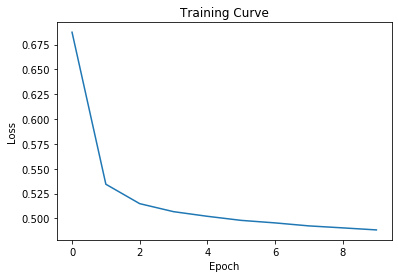

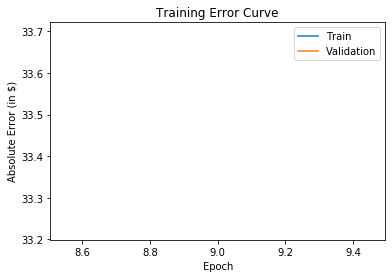

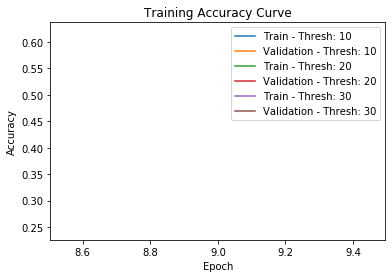

---[ITER 10] loss: 0.486472  time: 2.864
---[ITER 20] loss: 0.492626  time: 2.816
---[ITER 30] loss: 0.493403  time: 2.889
---[ITER 40] loss: 0.485890  time: 3.019
---[ITER 50] loss: 0.488980  time: 3.029
---[ITER 60] loss: 0.479537  time: 2.994
---[ITER 70] loss: 0.486085  time: 3.007
---[ITER 80] loss: 0.493550  time: 3.018
---[ITER 90] loss: 0.483252  time: 2.982
---[ITER 100] loss: 0.492581  time: 2.987
---[ITER 110] loss: 0.484177  time: 2.886
---[ITER 120] loss: 0.484104  time: 2.891
---[ITER 130] loss: 0.479667  time: 2.838
---[ITER 140] loss: 0.485302  time: 2.874
---[ITER 150] loss: 0.484774  time: 2.954
---[ITER 160] loss: 0.484867  time: 2.948
[EPOCH 11] loss: 0.486525  time: 49.298
---[ITER 10] loss: 0.483933  time: 2.990
---[ITER 20] loss: 0.488398  time: 3.006
---[ITER 30] loss: 0.481734  time: 3.213
---[ITER 40] loss: 0.485972  time: 2.963
---[ITER 50] loss: 0.489569  time: 3.005
---[ITER 60] loss: 0.485861  time: 2.998
---[ITER 70] loss: 0.481345  time: 3.003
---[ITER 8

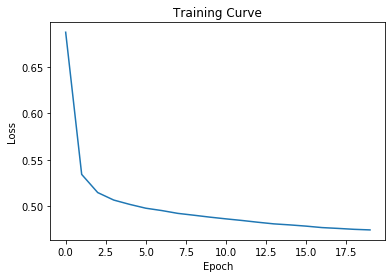

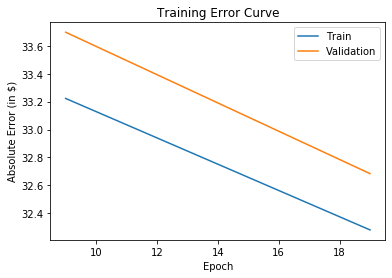

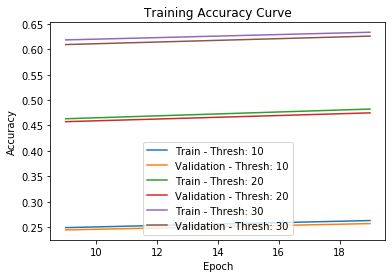

---[ITER 10] loss: 0.473806  time: 3.296
---[ITER 20] loss: 0.472995  time: 3.236
---[ITER 30] loss: 0.481268  time: 3.260
---[ITER 40] loss: 0.466474  time: 3.168
---[ITER 50] loss: 0.464853  time: 3.158
---[ITER 60] loss: 0.471499  time: 3.147
---[ITER 70] loss: 0.472036  time: 3.148
---[ITER 80] loss: 0.485111  time: 3.142
---[ITER 90] loss: 0.470601  time: 3.000
---[ITER 100] loss: 0.473225  time: 3.028
---[ITER 110] loss: 0.475168  time: 3.053
---[ITER 120] loss: 0.473581  time: 3.453
---[ITER 130] loss: 0.467469  time: 3.155
---[ITER 140] loss: 0.477073  time: 3.179
---[ITER 150] loss: 0.475955  time: 3.197
---[ITER 160] loss: 0.472592  time: 3.136
[EPOCH 21] loss: 0.473365  time: 53.191
---[ITER 10] loss: 0.470990  time: 3.116
---[ITER 20] loss: 0.478159  time: 3.204
---[ITER 30] loss: 0.476387  time: 3.210
---[ITER 40] loss: 0.473077  time: 3.197
---[ITER 50] loss: 0.462972  time: 3.317
---[ITER 60] loss: 0.472859  time: 3.264
---[ITER 70] loss: 0.470326  time: 3.316
---[ITER 8

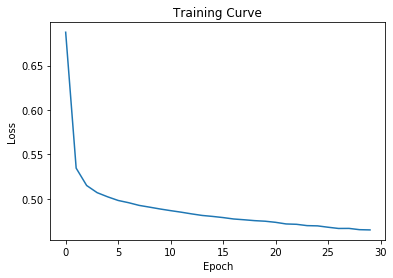

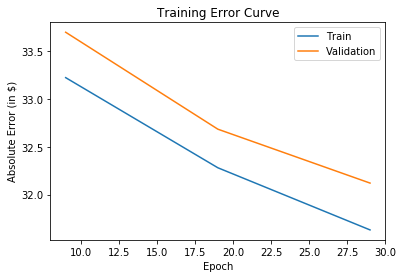

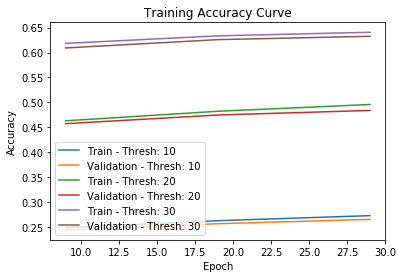

---[ITER 10] loss: 0.467059  time: 3.056
---[ITER 20] loss: 0.468981  time: 3.108
---[ITER 30] loss: 0.456643  time: 3.075
---[ITER 40] loss: 0.461461  time: 3.180
---[ITER 50] loss: 0.463161  time: 3.303
---[ITER 60] loss: 0.461073  time: 2.953
---[ITER 70] loss: 0.463633  time: 2.897
---[ITER 80] loss: 0.466107  time: 2.826
---[ITER 90] loss: 0.464343  time: 2.879
---[ITER 100] loss: 0.450951  time: 2.947
---[ITER 110] loss: 0.464782  time: 3.001
---[ITER 120] loss: 0.465133  time: 2.993
---[ITER 130] loss: 0.471087  time: 2.997
---[ITER 140] loss: 0.455453  time: 2.995
---[ITER 150] loss: 0.468487  time: 2.939
---[ITER 160] loss: 0.461772  time: 2.894
[EPOCH 31] loss: 0.463258  time: 50.233
---[ITER 10] loss: 0.462323  time: 2.986
---[ITER 20] loss: 0.456605  time: 2.946
---[ITER 30] loss: 0.462460  time: 2.970
---[ITER 40] loss: 0.463214  time: 3.000
---[ITER 50] loss: 0.471145  time: 2.985
---[ITER 60] loss: 0.456890  time: 2.983
---[ITER 70] loss: 0.459190  time: 2.865
---[ITER 8

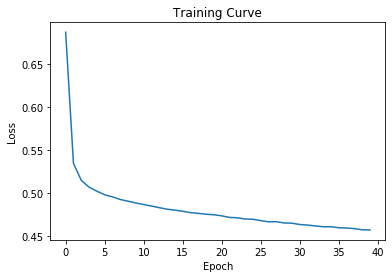

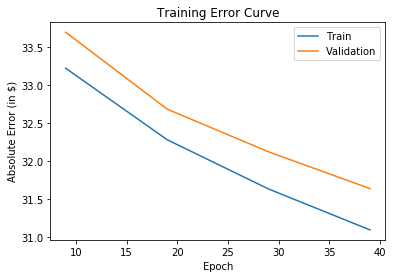

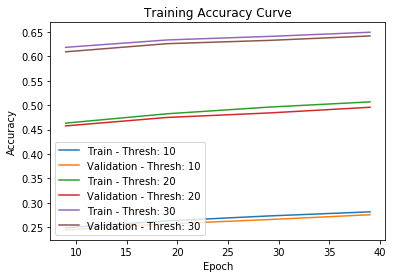

---[ITER 10] loss: 0.459634  time: 3.030
---[ITER 20] loss: 0.451510  time: 3.035
---[ITER 30] loss: 0.461128  time: 3.043
---[ITER 40] loss: 0.440652  time: 3.029
---[ITER 50] loss: 0.450705  time: 3.030
---[ITER 60] loss: 0.457096  time: 2.964
---[ITER 70] loss: 0.452687  time: 2.948
---[ITER 80] loss: 0.456248  time: 2.902
---[ITER 90] loss: 0.454536  time: 2.854
---[ITER 100] loss: 0.455084  time: 2.871
---[ITER 110] loss: 0.461101  time: 2.916
---[ITER 120] loss: 0.447977  time: 2.999
---[ITER 130] loss: 0.458710  time: 3.031
---[ITER 140] loss: 0.466243  time: 3.057
---[ITER 150] loss: 0.454880  time: 3.206
---[ITER 160] loss: 0.457533  time: 3.056
[EPOCH 41] loss: 0.455855  time: 50.248
---[ITER 10] loss: 0.450024  time: 2.982
---[ITER 20] loss: 0.448502  time: 3.327
---[ITER 30] loss: 0.454004  time: 2.978
---[ITER 40] loss: 0.454358  time: 2.966
---[ITER 50] loss: 0.467364  time: 3.059
---[ITER 60] loss: 0.449709  time: 3.021
---[ITER 70] loss: 0.458887  time: 2.926
---[ITER 8

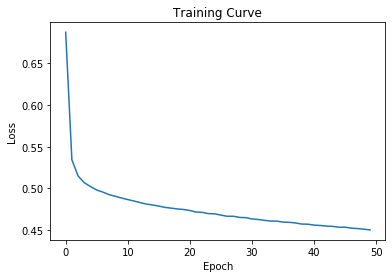

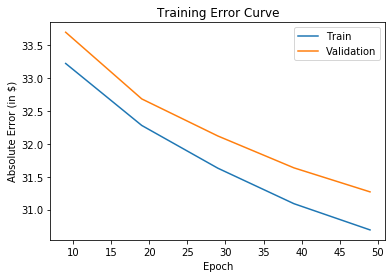

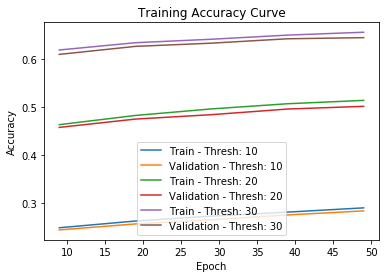

---[ITER 10] loss: 0.442854  time: 3.345
---[ITER 20] loss: 0.450731  time: 3.056
---[ITER 30] loss: 0.448364  time: 3.001
---[ITER 40] loss: 0.461670  time: 2.915
---[ITER 50] loss: 0.449139  time: 2.908
---[ITER 60] loss: 0.448821  time: 2.945
---[ITER 70] loss: 0.454177  time: 2.937
---[ITER 80] loss: 0.446617  time: 4.122
---[ITER 90] loss: 0.456908  time: 3.405
---[ITER 100] loss: 0.452571  time: 3.752
---[ITER 110] loss: 0.450604  time: 3.490
---[ITER 120] loss: 0.448754  time: 3.412
---[ITER 130] loss: 0.442208  time: 3.767
---[ITER 140] loss: 0.453594  time: 4.196
---[ITER 150] loss: 0.451823  time: 3.926
---[ITER 160] loss: 0.444253  time: 3.644
[EPOCH 51] loss: 0.450287  time: 57.644
---[ITER 10] loss: 0.447546  time: 3.424
---[ITER 20] loss: 0.446179  time: 3.343
---[ITER 30] loss: 0.448490  time: 3.541
---[ITER 40] loss: 0.441211  time: 3.240
---[ITER 50] loss: 0.456696  time: 3.382
---[ITER 60] loss: 0.450700  time: 3.481
---[ITER 70] loss: 0.453798  time: 3.731
---[ITER 8

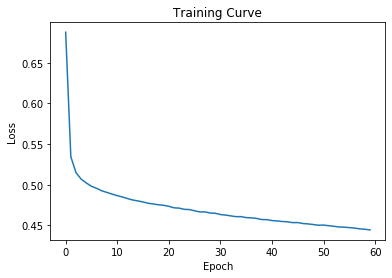

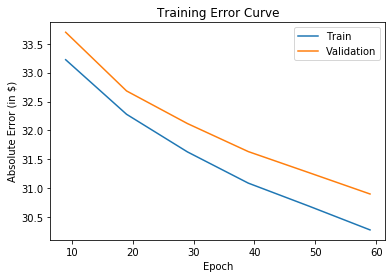

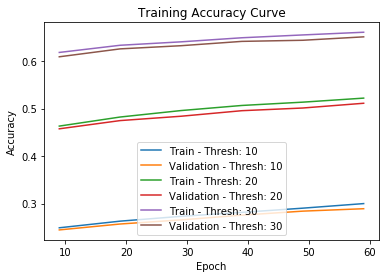

---[ITER 10] loss: 0.433961  time: 2.827
---[ITER 20] loss: 0.446227  time: 2.834
---[ITER 30] loss: 0.441525  time: 2.903
---[ITER 40] loss: 0.446165  time: 2.850
---[ITER 50] loss: 0.443332  time: 2.950
---[ITER 60] loss: 0.447933  time: 2.886
---[ITER 70] loss: 0.440374  time: 2.879
---[ITER 80] loss: 0.436882  time: 3.160
---[ITER 90] loss: 0.446389  time: 2.920
---[ITER 100] loss: 0.446206  time: 2.839
---[ITER 110] loss: 0.447671  time: 2.928
---[ITER 120] loss: 0.448204  time: 2.932
---[ITER 130] loss: 0.447504  time: 2.998
---[ITER 140] loss: 0.445819  time: 3.156
---[ITER 150] loss: 0.442339  time: 2.995
---[ITER 160] loss: 0.442164  time: 2.972
[EPOCH 61] loss: 0.444122  time: 49.409
---[ITER 10] loss: 0.436760  time: 2.843
---[ITER 20] loss: 0.442191  time: 2.843
---[ITER 30] loss: 0.444657  time: 2.849
---[ITER 40] loss: 0.441973  time: 2.959
---[ITER 50] loss: 0.437681  time: 2.981
---[ITER 60] loss: 0.438510  time: 2.998
---[ITER 70] loss: 0.448992  time: 2.944
---[ITER 8

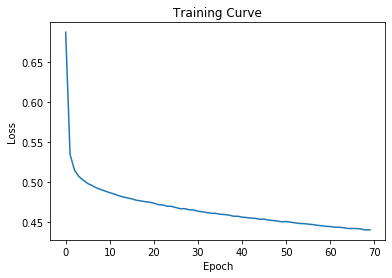

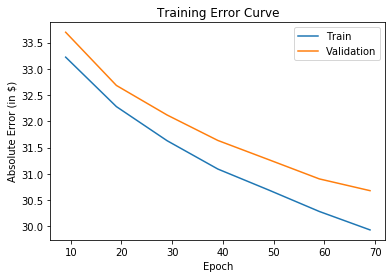

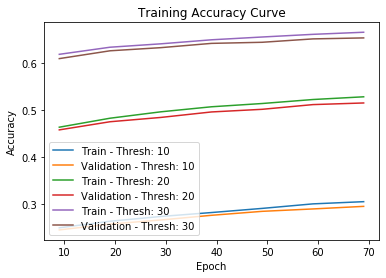

---[ITER 10] loss: 0.431547  time: 3.027
---[ITER 20] loss: 0.432570  time: 2.970
---[ITER 30] loss: 0.444748  time: 3.024
---[ITER 40] loss: 0.429875  time: 2.953
---[ITER 50] loss: 0.431205  time: 2.886
---[ITER 60] loss: 0.436256  time: 2.870
---[ITER 70] loss: 0.446768  time: 2.882
---[ITER 80] loss: 0.440851  time: 2.961
---[ITER 90] loss: 0.446124  time: 3.043
---[ITER 100] loss: 0.440011  time: 3.070
---[ITER 110] loss: 0.440437  time: 3.024
---[ITER 120] loss: 0.443033  time: 3.017
---[ITER 130] loss: 0.443336  time: 2.974
---[ITER 140] loss: 0.444864  time: 3.003
---[ITER 150] loss: 0.439645  time: 2.949
---[ITER 160] loss: 0.434479  time: 2.975
[EPOCH 71] loss: 0.438863  time: 49.890
---[ITER 10] loss: 0.440278  time: 2.999
---[ITER 20] loss: 0.434919  time: 3.307
---[ITER 30] loss: 0.440384  time: 2.946
---[ITER 40] loss: 0.431704  time: 2.941
---[ITER 50] loss: 0.440614  time: 2.930
---[ITER 60] loss: 0.446178  time: 3.070
---[ITER 70] loss: 0.435510  time: 2.854
---[ITER 8

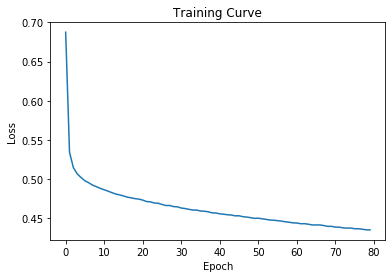

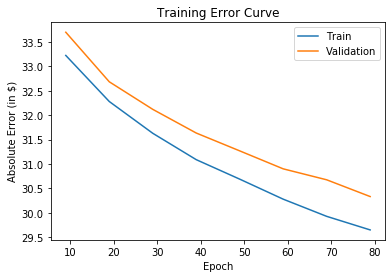

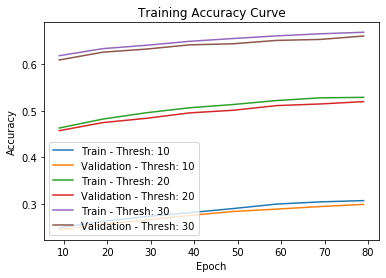

---[ITER 10] loss: 0.426848  time: 3.113
---[ITER 20] loss: 0.428869  time: 3.060
---[ITER 30] loss: 0.440940  time: 3.049
---[ITER 40] loss: 0.432287  time: 2.978
---[ITER 50] loss: 0.436403  time: 2.941
---[ITER 60] loss: 0.432865  time: 2.881
---[ITER 70] loss: 0.438031  time: 2.851
---[ITER 80] loss: 0.439816  time: 2.916
---[ITER 90] loss: 0.440214  time: 3.080
---[ITER 100] loss: 0.436930  time: 3.048
---[ITER 110] loss: 0.437457  time: 3.054
---[ITER 120] loss: 0.427512  time: 3.215
---[ITER 130] loss: 0.434906  time: 2.909
---[ITER 140] loss: 0.438640  time: 2.926
---[ITER 150] loss: 0.436043  time: 2.991
---[ITER 160] loss: 0.436004  time: 2.914
[EPOCH 81] loss: 0.434788  time: 50.133
---[ITER 10] loss: 0.435406  time: 2.991
---[ITER 20] loss: 0.437147  time: 3.055
---[ITER 30] loss: 0.427155  time: 3.007
---[ITER 40] loss: 0.441262  time: 3.314
---[ITER 50] loss: 0.435193  time: 3.208
---[ITER 60] loss: 0.427847  time: 3.085
---[ITER 70] loss: 0.436424  time: 3.033
---[ITER 8

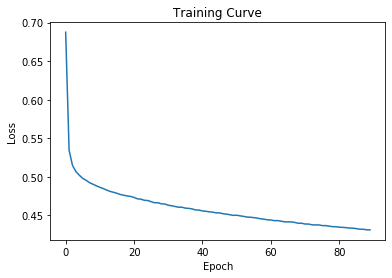

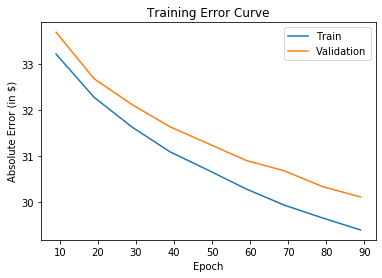

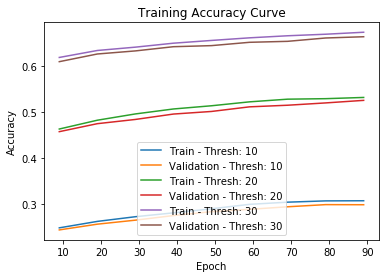

---[ITER 10] loss: 0.427558  time: 4.473
---[ITER 20] loss: 0.431519  time: 3.815
---[ITER 30] loss: 0.429234  time: 3.661
---[ITER 40] loss: 0.435414  time: 3.784
---[ITER 50] loss: 0.438204  time: 3.774
---[ITER 60] loss: 0.424569  time: 3.040
---[ITER 70] loss: 0.432993  time: 3.113
---[ITER 80] loss: 0.430017  time: 2.965
---[ITER 90] loss: 0.426057  time: 2.994
---[ITER 100] loss: 0.429170  time: 2.983
---[ITER 110] loss: 0.429617  time: 3.081
---[ITER 120] loss: 0.429911  time: 2.963
---[ITER 130] loss: 0.424728  time: 2.839
---[ITER 140] loss: 0.434699  time: 2.890
---[ITER 150] loss: 0.428776  time: 2.853
---[ITER 160] loss: 0.434178  time: 2.916
[EPOCH 91] loss: 0.430799  time: 54.684
---[ITER 10] loss: 0.420492  time: 3.332
---[ITER 20] loss: 0.433937  time: 3.115
---[ITER 30] loss: 0.437969  time: 3.023
---[ITER 40] loss: 0.427788  time: 3.017
---[ITER 50] loss: 0.423834  time: 3.187
---[ITER 60] loss: 0.422788  time: 3.114
---[ITER 70] loss: 0.439607  time: 3.095
---[ITER 8

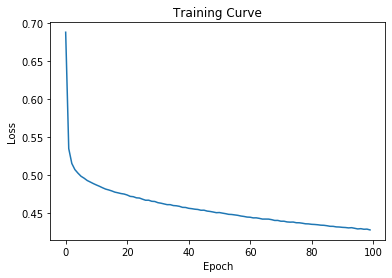

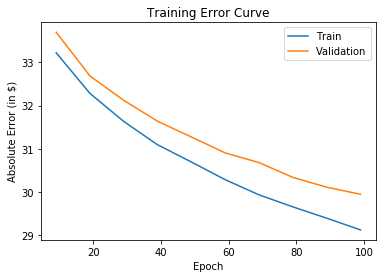

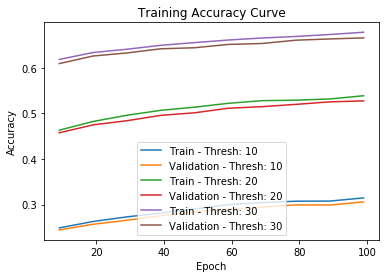

---[ITER 10] loss: 0.427013  time: 3.022
---[ITER 20] loss: 0.430037  time: 2.912
---[ITER 30] loss: 0.435311  time: 2.917
---[ITER 40] loss: 0.428083  time: 2.934
---[ITER 50] loss: 0.424413  time: 2.971
---[ITER 60] loss: 0.423346  time: 3.002
---[ITER 70] loss: 0.422714  time: 2.955
---[ITER 80] loss: 0.424876  time: 2.938
---[ITER 90] loss: 0.431694  time: 2.860
---[ITER 100] loss: 0.421879  time: 2.877
---[ITER 110] loss: 0.425575  time: 2.882
---[ITER 120] loss: 0.428284  time: 3.094
---[ITER 130] loss: 0.427115  time: 2.997
---[ITER 140] loss: 0.425025  time: 3.133
---[ITER 150] loss: 0.431055  time: 3.375
---[ITER 160] loss: 0.432670  time: 2.957
[EPOCH 101] loss: 0.427466  time: 50.150
---[ITER 10] loss: 0.422628  time: 3.205
---[ITER 20] loss: 0.429082  time: 2.950
---[ITER 30] loss: 0.429156  time: 2.872
---[ITER 40] loss: 0.430571  time: 3.002
---[ITER 50] loss: 0.428316  time: 2.973
---[ITER 60] loss: 0.425652  time: 2.999
---[ITER 70] loss: 0.432308  time: 2.994
---[ITER 

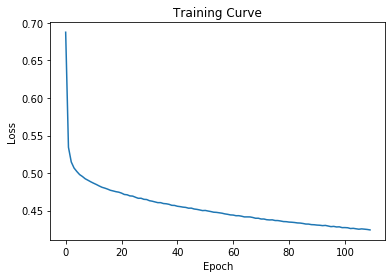

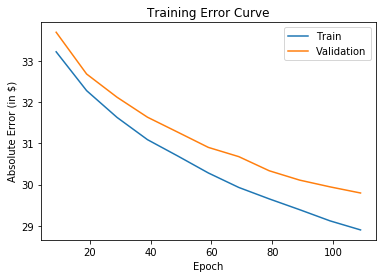

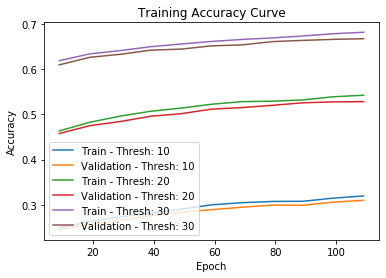

---[ITER 10] loss: 0.423699  time: 3.631
---[ITER 20] loss: 0.430061  time: 3.416
---[ITER 30] loss: 0.430447  time: 3.255
---[ITER 40] loss: 0.417091  time: 3.459
---[ITER 50] loss: 0.420227  time: 3.204
---[ITER 60] loss: 0.424019  time: 3.204
---[ITER 70] loss: 0.428378  time: 3.096
---[ITER 80] loss: 0.425637  time: 3.588
---[ITER 90] loss: 0.423847  time: 3.255
---[ITER 100] loss: 0.432219  time: 3.518
---[ITER 110] loss: 0.425436  time: 3.378
---[ITER 120] loss: 0.417333  time: 3.239
---[ITER 130] loss: 0.415056  time: 3.508
---[ITER 140] loss: 0.417031  time: 3.426
---[ITER 150] loss: 0.421686  time: 3.313
---[ITER 160] loss: 0.421405  time: 3.515
[EPOCH 111] loss: 0.423185  time: 56.391
---[ITER 10] loss: 0.417997  time: 3.233
---[ITER 20] loss: 0.423771  time: 3.314
---[ITER 30] loss: 0.421100  time: 3.421
---[ITER 40] loss: 0.428019  time: 3.248
---[ITER 50] loss: 0.426555  time: 3.092
---[ITER 60] loss: 0.418147  time: 3.729
---[ITER 70] loss: 0.426925  time: 3.507
---[ITER 

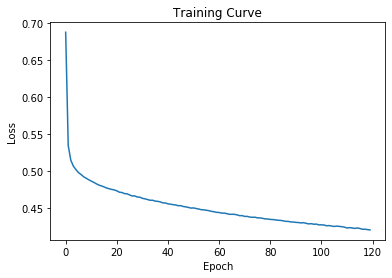

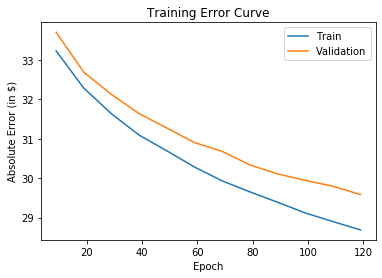

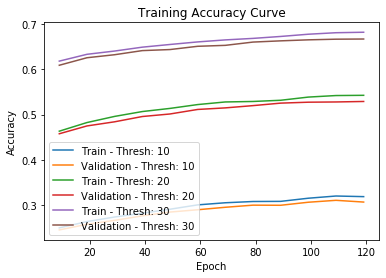

---[ITER 10] loss: 0.424030  time: 3.177
---[ITER 20] loss: 0.427464  time: 3.248
---[ITER 30] loss: 0.426094  time: 3.167
---[ITER 40] loss: 0.418257  time: 3.043
---[ITER 50] loss: 0.422142  time: 3.258
---[ITER 60] loss: 0.426743  time: 2.885
---[ITER 70] loss: 0.419945  time: 2.995
---[ITER 80] loss: 0.416332  time: 3.607
---[ITER 90] loss: 0.421488  time: 3.535
---[ITER 100] loss: 0.417168  time: 3.166
---[ITER 110] loss: 0.421277  time: 3.458
---[ITER 120] loss: 0.425184  time: 4.245
---[ITER 130] loss: 0.418031  time: 3.200
---[ITER 140] loss: 0.419341  time: 3.233
---[ITER 150] loss: 0.421691  time: 3.224
---[ITER 160] loss: 0.414747  time: 3.198
[EPOCH 121] loss: 0.421306  time: 55.087
---[ITER 10] loss: 0.430437  time: 2.994
---[ITER 20] loss: 0.416312  time: 3.144
---[ITER 30] loss: 0.416233  time: 3.232
---[ITER 40] loss: 0.414389  time: 3.292
---[ITER 50] loss: 0.423464  time: 3.152
---[ITER 60] loss: 0.415345  time: 3.208
---[ITER 70] loss: 0.421583  time: 3.076
---[ITER 

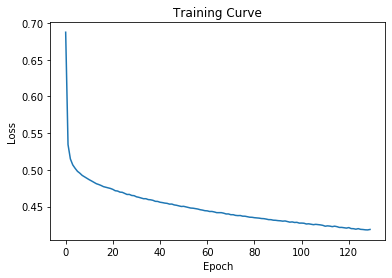

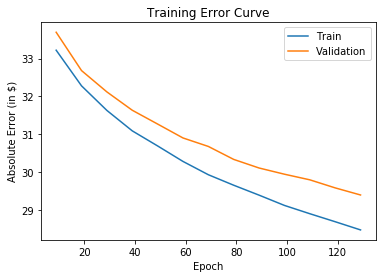

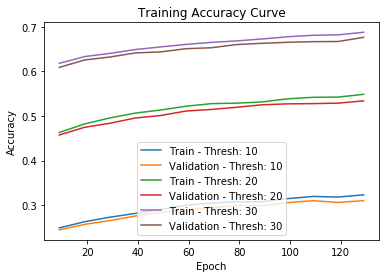

---[ITER 10] loss: 0.421944  time: 3.376
---[ITER 20] loss: 0.418125  time: 3.272
---[ITER 30] loss: 0.413710  time: 3.427
---[ITER 40] loss: 0.412487  time: 3.204
---[ITER 50] loss: 0.416048  time: 3.072
---[ITER 60] loss: 0.418816  time: 3.043
---[ITER 70] loss: 0.418363  time: 2.939
---[ITER 80] loss: 0.420718  time: 4.201
---[ITER 90] loss: 0.409542  time: 3.097
---[ITER 100] loss: 0.417130  time: 3.181
---[ITER 110] loss: 0.423553  time: 3.235
---[ITER 120] loss: 0.413600  time: 3.504
---[ITER 130] loss: 0.422454  time: 3.297
---[ITER 140] loss: 0.415132  time: 3.305
---[ITER 150] loss: 0.416509  time: 3.484
---[ITER 160] loss: 0.424528  time: 3.229
[EPOCH 131] loss: 0.417994  time: 56.459
---[ITER 10] loss: 0.419585  time: 3.404
---[ITER 20] loss: 0.410431  time: 4.835
---[ITER 30] loss: 0.415250  time: 4.487
---[ITER 40] loss: 0.414419  time: 6.070
---[ITER 50] loss: 0.417714  time: 3.661
---[ITER 60] loss: 0.414680  time: 3.074
---[ITER 70] loss: 0.421913  time: 3.199
---[ITER 

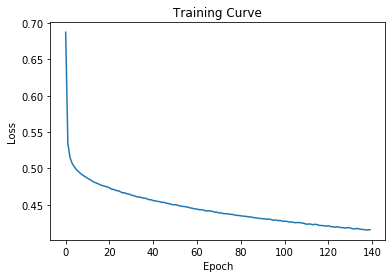

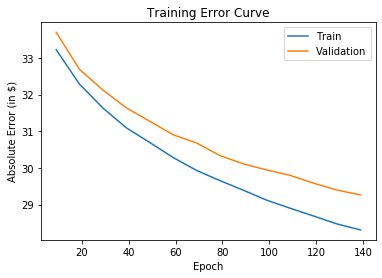

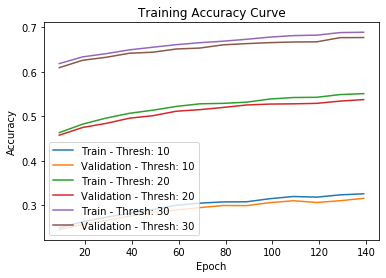

---[ITER 10] loss: 0.412000  time: 3.279
---[ITER 20] loss: 0.412174  time: 3.372
---[ITER 30] loss: 0.417382  time: 4.618
---[ITER 40] loss: 0.419229  time: 4.174
---[ITER 50] loss: 0.410834  time: 3.763
---[ITER 60] loss: 0.416296  time: 4.454
---[ITER 70] loss: 0.416991  time: 3.487
---[ITER 80] loss: 0.418219  time: 3.495
---[ITER 90] loss: 0.419109  time: 3.341
---[ITER 100] loss: 0.415937  time: 3.525
---[ITER 110] loss: 0.417602  time: 3.355
---[ITER 120] loss: 0.417901  time: 3.468
---[ITER 130] loss: 0.417387  time: 3.594
---[ITER 140] loss: 0.421133  time: 3.467
---[ITER 150] loss: 0.411164  time: 3.434
---[ITER 160] loss: 0.411695  time: 3.011
[EPOCH 141] loss: 0.415700  time: 60.236
---[ITER 10] loss: 0.407366  time: 3.619
---[ITER 20] loss: 0.411566  time: 3.399
---[ITER 30] loss: 0.412781  time: 3.266
---[ITER 40] loss: 0.406823  time: 3.255
---[ITER 50] loss: 0.415398  time: 3.191
---[ITER 60] loss: 0.409212  time: 3.017
---[ITER 70] loss: 0.417700  time: 2.951
---[ITER 

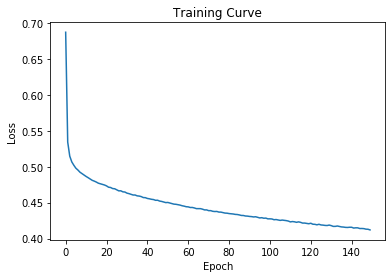

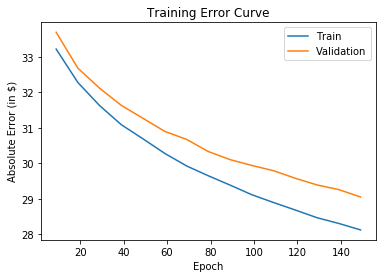

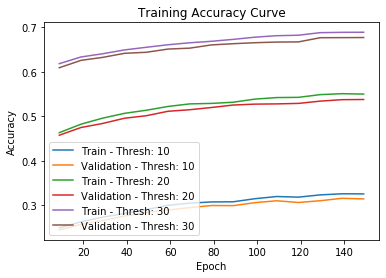

---[ITER 10] loss: 0.407504  time: 3.630
---[ITER 20] loss: 0.415730  time: 3.368
---[ITER 30] loss: 0.405715  time: 3.342
---[ITER 40] loss: 0.415828  time: 3.991
---[ITER 50] loss: 0.414057  time: 3.404
---[ITER 60] loss: 0.408167  time: 3.381
---[ITER 70] loss: 0.411755  time: 3.268
---[ITER 80] loss: 0.412797  time: 3.104
---[ITER 90] loss: 0.412502  time: 3.022
---[ITER 100] loss: 0.414069  time: 3.054
---[ITER 110] loss: 0.409944  time: 3.213
---[ITER 120] loss: 0.414654  time: 2.993
---[ITER 130] loss: 0.412322  time: 3.086
---[ITER 140] loss: 0.418960  time: 3.127
---[ITER 150] loss: 0.415632  time: 3.178
---[ITER 160] loss: 0.403433  time: 3.287
[EPOCH 151] loss: 0.412076  time: 55.617
---[ITER 10] loss: 0.414438  time: 4.607
---[ITER 20] loss: 0.416705  time: 3.122
---[ITER 30] loss: 0.421995  time: 3.218
---[ITER 40] loss: 0.420986  time: 3.034
---[ITER 50] loss: 0.408695  time: 4.146
---[ITER 60] loss: 0.411708  time: 3.321
---[ITER 70] loss: 0.409235  time: 3.205
---[ITER 

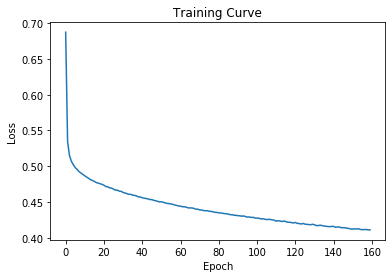

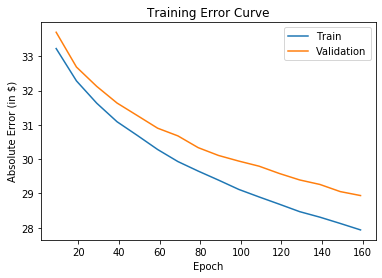

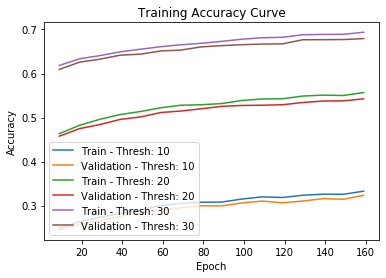

---[ITER 10] loss: 0.422012  time: 3.250
---[ITER 20] loss: 0.420532  time: 3.340
---[ITER 30] loss: 0.409911  time: 3.290
---[ITER 40] loss: 0.403421  time: 3.251
---[ITER 50] loss: 0.403166  time: 4.267
---[ITER 60] loss: 0.408159  time: 3.226
---[ITER 70] loss: 0.407003  time: 3.240
---[ITER 80] loss: 0.414364  time: 3.551
---[ITER 90] loss: 0.406782  time: 3.485
---[ITER 100] loss: 0.413421  time: 3.162
---[ITER 110] loss: 0.412171  time: 3.318
---[ITER 120] loss: 0.405391  time: 3.440
---[ITER 130] loss: 0.409755  time: 3.016
---[ITER 140] loss: 0.405569  time: 3.125
---[ITER 150] loss: 0.414287  time: 2.989
---[ITER 160] loss: 0.408148  time: 2.927
[EPOCH 161] loss: 0.409944  time: 55.206
---[ITER 10] loss: 0.409337  time: 3.212
---[ITER 20] loss: 0.415986  time: 3.213
---[ITER 30] loss: 0.410575  time: 3.197
---[ITER 40] loss: 0.407017  time: 3.339
---[ITER 50] loss: 0.414684  time: 3.317
---[ITER 60] loss: 0.410688  time: 3.217
---[ITER 70] loss: 0.411089  time: 3.384
---[ITER 

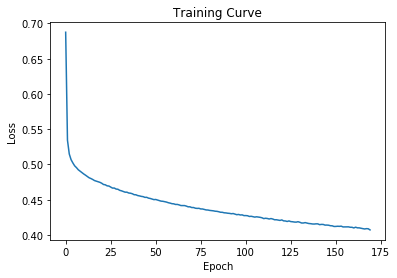

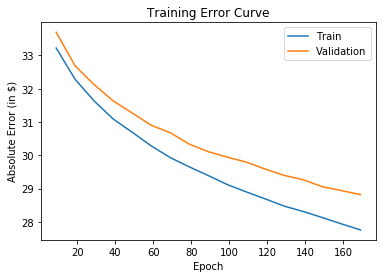

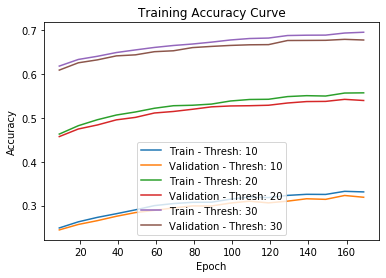

---[ITER 10] loss: 0.404976  time: 3.527
---[ITER 20] loss: 0.411394  time: 3.447
---[ITER 30] loss: 0.405811  time: 3.730
---[ITER 40] loss: 0.416694  time: 3.524
---[ITER 50] loss: 0.402067  time: 3.507
---[ITER 60] loss: 0.403821  time: 3.678
---[ITER 70] loss: 0.411772  time: 3.611
---[ITER 80] loss: 0.396915  time: 3.634
---[ITER 90] loss: 0.405392  time: 3.506
---[ITER 100] loss: 0.407677  time: 3.297
---[ITER 110] loss: 0.409726  time: 5.552
---[ITER 120] loss: 0.408915  time: 3.743
---[ITER 130] loss: 0.407852  time: 3.730
---[ITER 140] loss: 0.406791  time: 4.547
---[ITER 150] loss: 0.414228  time: 4.231
---[ITER 160] loss: 0.414193  time: 4.257
[EPOCH 171] loss: 0.407911  time: 64.115
---[ITER 10] loss: 0.408957  time: 3.314
---[ITER 20] loss: 0.403851  time: 3.362
---[ITER 30] loss: 0.404116  time: 3.312
---[ITER 40] loss: 0.396164  time: 3.199
---[ITER 50] loss: 0.404854  time: 3.160
---[ITER 60] loss: 0.405112  time: 3.070
---[ITER 70] loss: 0.411793  time: 3.169
---[ITER 

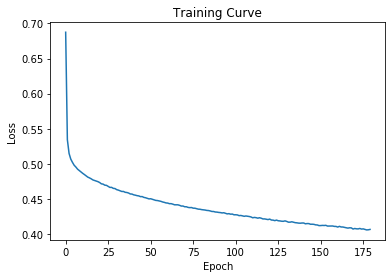

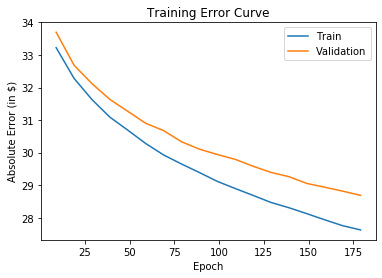

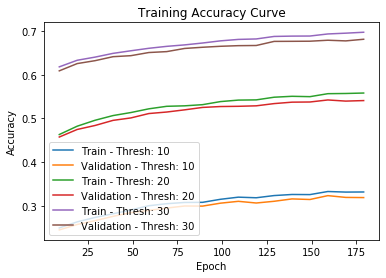

---[ITER 10] loss: 0.403723  time: 3.227
---[ITER 20] loss: 0.411566  time: 3.184
---[ITER 30] loss: 0.407276  time: 3.196
---[ITER 40] loss: 0.409800  time: 4.928
---[ITER 50] loss: 0.402727  time: 3.411
---[ITER 60] loss: 0.406431  time: 3.416
---[ITER 70] loss: 0.409853  time: 3.474
---[ITER 80] loss: 0.407766  time: 3.569
---[ITER 90] loss: 0.413875  time: 3.158
---[ITER 100] loss: 0.403884  time: 3.054
---[ITER 110] loss: 0.404105  time: 2.943
---[ITER 120] loss: 0.407013  time: 3.029
---[ITER 130] loss: 0.409049  time: 3.172
---[ITER 140] loss: 0.399856  time: 3.316
---[ITER 150] loss: 0.402094  time: 3.314
---[ITER 160] loss: 0.406535  time: 3.258
[EPOCH 181] loss: 0.406389  time: 56.121
---[ITER 10] loss: 0.407535  time: 3.499
---[ITER 20] loss: 0.402640  time: 3.628
---[ITER 30] loss: 0.403332  time: 3.243
---[ITER 40] loss: 0.397519  time: 2.958
---[ITER 50] loss: 0.406653  time: 3.274
---[ITER 60] loss: 0.402376  time: 3.189
---[ITER 70] loss: 0.410493  time: 3.322
---[ITER 

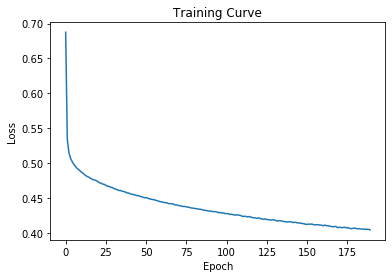

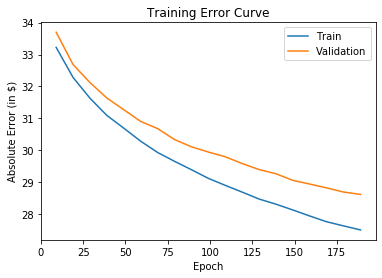

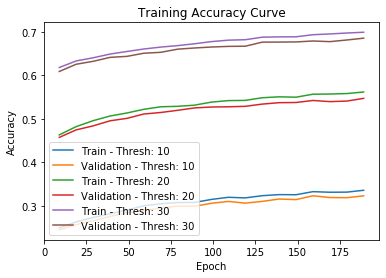

---[ITER 10] loss: 0.405657  time: 4.121
---[ITER 20] loss: 0.399441  time: 3.432
---[ITER 30] loss: 0.406982  time: 3.131
---[ITER 40] loss: 0.404862  time: 3.026
---[ITER 50] loss: 0.406552  time: 3.221
---[ITER 60] loss: 0.402174  time: 3.334
---[ITER 70] loss: 0.396098  time: 3.384
---[ITER 80] loss: 0.404174  time: 3.321
---[ITER 90] loss: 0.399897  time: 3.211
---[ITER 100] loss: 0.411130  time: 3.355
---[ITER 110] loss: 0.408530  time: 3.003
---[ITER 120] loss: 0.410382  time: 3.233
---[ITER 130] loss: 0.395957  time: 3.549
---[ITER 140] loss: 0.407782  time: 3.161
---[ITER 150] loss: 0.408111  time: 3.163
---[ITER 160] loss: 0.408761  time: 3.275
[EPOCH 191] loss: 0.404717  time: 55.500
---[ITER 10] loss: 0.397080  time: 3.203
---[ITER 20] loss: 0.405424  time: 3.104
---[ITER 30] loss: 0.402880  time: 3.226
---[ITER 40] loss: 0.404068  time: 3.230
---[ITER 50] loss: 0.407368  time: 3.090
---[ITER 60] loss: 0.408078  time: 3.036
---[ITER 70] loss: 0.397865  time: 3.002
---[ITER 

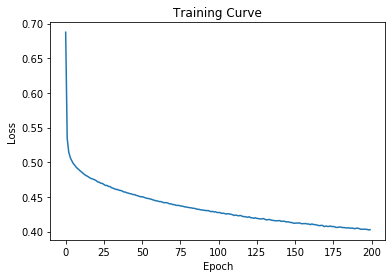

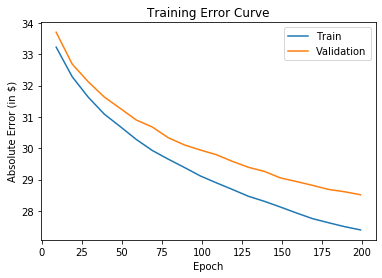

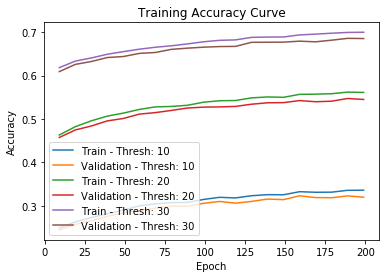

---[ITER 10] loss: 0.400582  time: 4.788
---[ITER 20] loss: 0.400566  time: 4.247
---[ITER 30] loss: 0.403282  time: 3.774
---[ITER 40] loss: 0.398892  time: 3.185
---[ITER 50] loss: 0.403045  time: 3.061
---[ITER 60] loss: 0.396884  time: 2.993
---[ITER 70] loss: 0.395519  time: 3.075
---[ITER 80] loss: 0.402087  time: 3.351
---[ITER 90] loss: 0.406044  time: 3.786
---[ITER 100] loss: 0.406736  time: 3.117
---[ITER 110] loss: 0.404825  time: 3.341
---[ITER 120] loss: 0.397521  time: 4.788
---[ITER 130] loss: 0.403763  time: 3.407
---[ITER 140] loss: 0.402598  time: 3.419
---[ITER 150] loss: 0.402537  time: 3.337
---[ITER 160] loss: 0.403432  time: 3.365
[EPOCH 201] loss: 0.401860  time: 59.602
---[ITER 10] loss: 0.403789  time: 3.352
---[ITER 20] loss: 0.397910  time: 3.521
---[ITER 30] loss: 0.398710  time: 3.433
---[ITER 40] loss: 0.392779  time: 3.572
---[ITER 50] loss: 0.402695  time: 3.388
---[ITER 60] loss: 0.396391  time: 3.666
---[ITER 70] loss: 0.402231  time: 3.756
---[ITER 

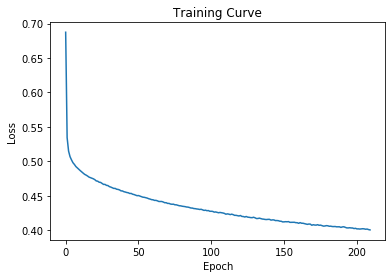

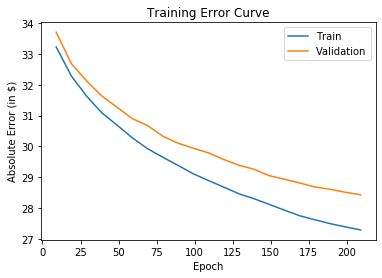

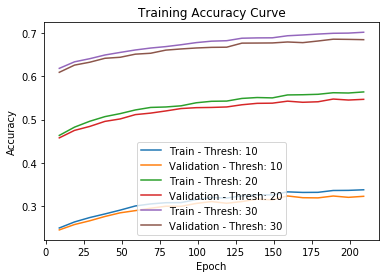

---[ITER 10] loss: 0.401238  time: 3.204
---[ITER 20] loss: 0.406384  time: 3.176
---[ITER 30] loss: 0.401179  time: 3.091
---[ITER 40] loss: 0.398383  time: 3.031
---[ITER 50] loss: 0.395667  time: 3.279
---[ITER 60] loss: 0.394367  time: 4.030
---[ITER 70] loss: 0.408736  time: 3.121
---[ITER 80] loss: 0.397493  time: 3.050
---[ITER 90] loss: 0.399322  time: 3.143
---[ITER 100] loss: 0.395132  time: 3.245
---[ITER 110] loss: 0.400305  time: 3.360
---[ITER 120] loss: 0.403880  time: 3.422
---[ITER 130] loss: 0.397385  time: 3.422
---[ITER 140] loss: 0.395063  time: 4.614
---[ITER 150] loss: 0.403259  time: 4.216
---[ITER 160] loss: 0.398860  time: 3.224
[EPOCH 211] loss: 0.399851  time: 57.325
---[ITER 10] loss: 0.404329  time: 3.207
---[ITER 20] loss: 0.397492  time: 3.260
---[ITER 30] loss: 0.401327  time: 3.390
---[ITER 40] loss: 0.404780  time: 3.397
---[ITER 50] loss: 0.401577  time: 3.223
---[ITER 60] loss: 0.395212  time: 3.120
---[ITER 70] loss: 0.399919  time: 3.121
---[ITER 

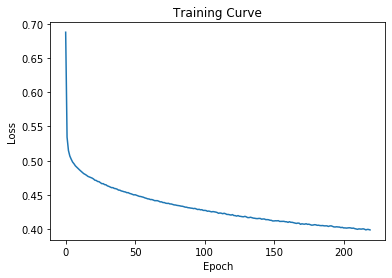

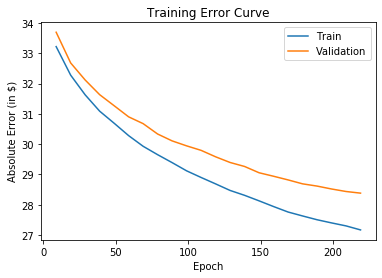

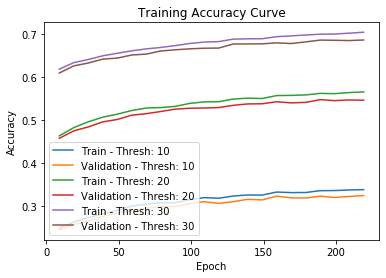

---[ITER 10] loss: 0.395372  time: 3.247
---[ITER 20] loss: 0.402567  time: 3.121
---[ITER 30] loss: 0.393100  time: 3.115
---[ITER 40] loss: 0.400208  time: 3.312
---[ITER 50] loss: 0.404078  time: 3.314
---[ITER 60] loss: 0.396199  time: 3.431
---[ITER 70] loss: 0.393023  time: 3.461
---[ITER 80] loss: 0.399166  time: 3.340
---[ITER 90] loss: 0.398292  time: 3.330
---[ITER 100] loss: 0.395046  time: 3.547
---[ITER 110] loss: 0.401052  time: 3.438
---[ITER 120] loss: 0.397947  time: 3.319
---[ITER 130] loss: 0.395494  time: 3.227
---[ITER 140] loss: 0.401140  time: 3.197
---[ITER 150] loss: 0.405977  time: 3.128
---[ITER 160] loss: 0.404369  time: 3.033
[EPOCH 221] loss: 0.398834  time: 54.926
---[ITER 10] loss: 0.400098  time: 3.382
---[ITER 20] loss: 0.392826  time: 3.441
---[ITER 30] loss: 0.397053  time: 3.443
---[ITER 40] loss: 0.399812  time: 3.403
---[ITER 50] loss: 0.396048  time: 3.196
---[ITER 60] loss: 0.398332  time: 3.209
---[ITER 70] loss: 0.398217  time: 3.498
---[ITER 

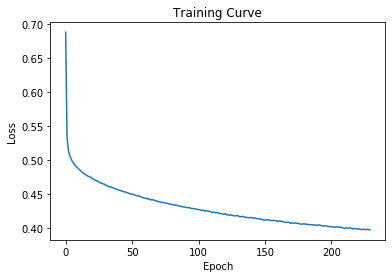

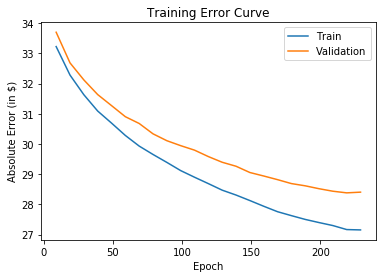

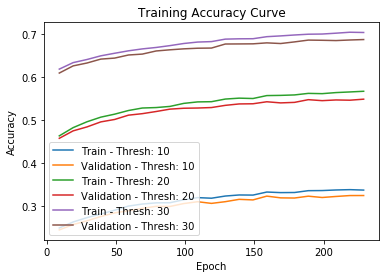

---[ITER 10] loss: 0.396833  time: 3.414
---[ITER 20] loss: 0.393619  time: 3.342
---[ITER 30] loss: 0.400229  time: 3.305
---[ITER 40] loss: 0.400345  time: 3.212
---[ITER 50] loss: 0.394929  time: 3.162
---[ITER 60] loss: 0.403085  time: 3.172
---[ITER 70] loss: 0.403290  time: 3.363
---[ITER 80] loss: 0.397349  time: 3.294
---[ITER 90] loss: 0.390639  time: 3.153
---[ITER 100] loss: 0.397863  time: 3.024
---[ITER 110] loss: 0.399699  time: 3.149
---[ITER 120] loss: 0.395600  time: 3.052
---[ITER 130] loss: 0.398100  time: 3.226
---[ITER 140] loss: 0.392370  time: 3.464
---[ITER 150] loss: 0.395772  time: 3.497
---[ITER 160] loss: 0.400828  time: 3.451
[EPOCH 231] loss: 0.397309  time: 54.899
---[ITER 10] loss: 0.397317  time: 3.033
---[ITER 20] loss: 0.408742  time: 3.058
---[ITER 30] loss: 0.399371  time: 3.121
---[ITER 40] loss: 0.401524  time: 3.284
---[ITER 50] loss: 0.387660  time: 3.375
---[ITER 60] loss: 0.388094  time: 3.329
---[ITER 70] loss: 0.400944  time: 3.246
---[ITER 

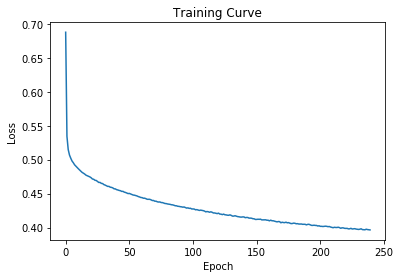

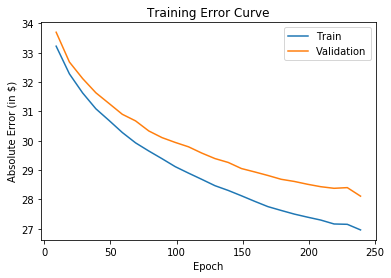

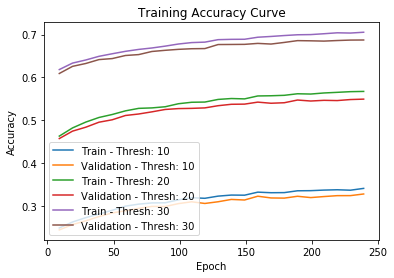

---[ITER 10] loss: 0.399590  time: 3.212
---[ITER 20] loss: 0.393900  time: 3.241
---[ITER 30] loss: 0.395555  time: 3.322
---[ITER 40] loss: 0.395583  time: 3.261
---[ITER 50] loss: 0.391415  time: 3.273
---[ITER 60] loss: 0.399131  time: 3.202
---[ITER 70] loss: 0.395729  time: 3.099
---[ITER 80] loss: 0.394129  time: 2.952
---[ITER 90] loss: 0.395378  time: 2.989
---[ITER 100] loss: 0.391753  time: 3.186
---[ITER 110] loss: 0.395858  time: 3.294
---[ITER 120] loss: 0.395166  time: 3.247
---[ITER 130] loss: 0.397837  time: 3.187
---[ITER 140] loss: 0.397456  time: 3.181
---[ITER 150] loss: 0.398515  time: 3.221
---[ITER 160] loss: 0.389703  time: 3.266
[EPOCH 241] loss: 0.395976  time: 53.518
---[ITER 10] loss: 0.403612  time: 3.212
---[ITER 20] loss: 0.396352  time: 4.134
---[ITER 30] loss: 0.394449  time: 4.365
---[ITER 40] loss: 0.400253  time: 3.800
---[ITER 50] loss: 0.396321  time: 4.284
---[ITER 60] loss: 0.400482  time: 4.816
---[ITER 70] loss: 0.387227  time: 3.916
---[ITER 

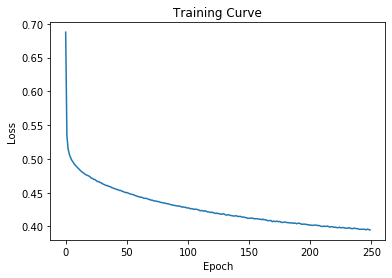

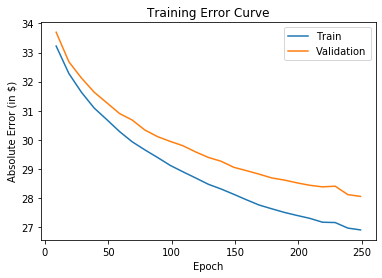

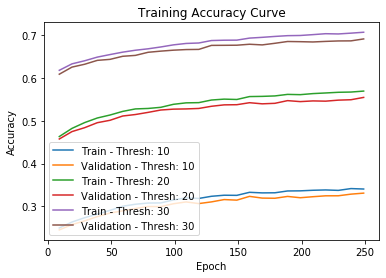

---[ITER 10] loss: 0.393540  time: 5.002
---[ITER 20] loss: 0.386715  time: 3.487
---[ITER 30] loss: 0.400236  time: 3.084
---[ITER 40] loss: 0.398484  time: 3.309
---[ITER 50] loss: 0.393602  time: 3.979
---[ITER 60] loss: 0.397182  time: 2.889
---[ITER 70] loss: 0.403280  time: 2.951
---[ITER 80] loss: 0.396316  time: 3.053
---[ITER 90] loss: 0.402857  time: 4.660
---[ITER 100] loss: 0.386351  time: 3.136
---[ITER 110] loss: 0.390345  time: 3.240
---[ITER 120] loss: 0.390129  time: 3.355
---[ITER 130] loss: 0.390924  time: 3.353
---[ITER 140] loss: 0.397160  time: 3.311
---[ITER 150] loss: 0.402341  time: 3.284
---[ITER 160] loss: 0.394621  time: 3.265
[EPOCH 251] loss: 0.394819  time: 59.273
---[ITER 10] loss: 0.388223  time: 4.814
---[ITER 20] loss: 0.388897  time: 7.989
---[ITER 30] loss: 0.399744  time: 3.151
---[ITER 40] loss: 0.393564  time: 4.350
---[ITER 50] loss: 0.400138  time: 4.429
---[ITER 60] loss: 0.394031  time: 4.828
---[ITER 70] loss: 0.394595  time: 5.745
---[ITER 

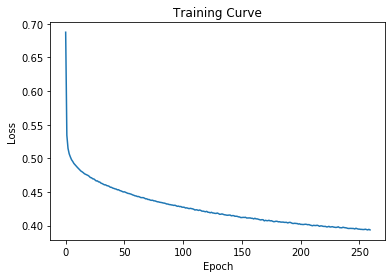

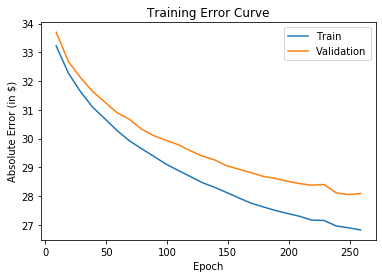

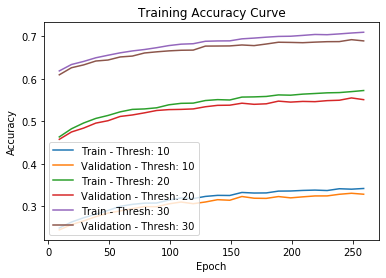

---[ITER 10] loss: 0.395044  time: 3.205
---[ITER 20] loss: 0.392927  time: 3.201
---[ITER 30] loss: 0.400932  time: 3.368
---[ITER 40] loss: 0.399477  time: 3.079
---[ITER 50] loss: 0.395648  time: 3.252
---[ITER 60] loss: 0.393725  time: 3.589
---[ITER 70] loss: 0.394138  time: 3.390
---[ITER 80] loss: 0.392218  time: 3.335
---[ITER 90] loss: 0.391786  time: 3.196
---[ITER 100] loss: 0.394893  time: 3.115
---[ITER 110] loss: 0.386301  time: 3.250
---[ITER 120] loss: 0.390738  time: 3.388
---[ITER 130] loss: 0.390798  time: 3.364
---[ITER 140] loss: 0.398102  time: 3.538
---[ITER 150] loss: 0.395816  time: 3.680
---[ITER 160] loss: 0.397712  time: 3.623
[EPOCH 261] loss: 0.394275  time: 56.420
---[ITER 10] loss: 0.399425  time: 3.739
---[ITER 20] loss: 0.390795  time: 3.619
---[ITER 30] loss: 0.398977  time: 3.437
---[ITER 40] loss: 0.390737  time: 3.514
---[ITER 50] loss: 0.397793  time: 3.164
---[ITER 60] loss: 0.393300  time: 3.122
---[ITER 70] loss: 0.393547  time: 3.583
---[ITER 

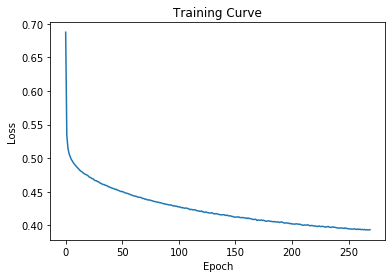

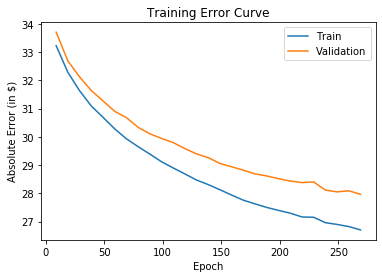

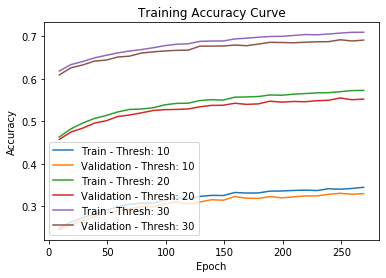

---[ITER 10] loss: 0.389911  time: 3.292
---[ITER 20] loss: 0.393480  time: 3.158
---[ITER 30] loss: 0.390741  time: 3.343
---[ITER 40] loss: 0.398117  time: 3.476
---[ITER 50] loss: 0.393231  time: 3.410
---[ITER 60] loss: 0.390884  time: 3.498
---[ITER 70] loss: 0.391419  time: 3.453
---[ITER 80] loss: 0.386574  time: 3.360
---[ITER 90] loss: 0.392880  time: 3.292
---[ITER 100] loss: 0.399533  time: 3.168
---[ITER 110] loss: 0.395120  time: 3.175
---[ITER 120] loss: 0.392943  time: 3.281
---[ITER 130] loss: 0.386674  time: 3.414
---[ITER 140] loss: 0.383786  time: 3.590
---[ITER 150] loss: 0.396912  time: 3.388
---[ITER 160] loss: 0.396216  time: 3.315
[EPOCH 271] loss: 0.392261  time: 56.389
---[ITER 10] loss: 0.391856  time: 3.409
---[ITER 20] loss: 0.398328  time: 3.557
---[ITER 30] loss: 0.401204  time: 3.263
---[ITER 40] loss: 0.390445  time: 3.535
---[ITER 50] loss: 0.387416  time: 3.594
---[ITER 60] loss: 0.394244  time: 3.553
---[ITER 70] loss: 0.386304  time: 3.657
---[ITER 

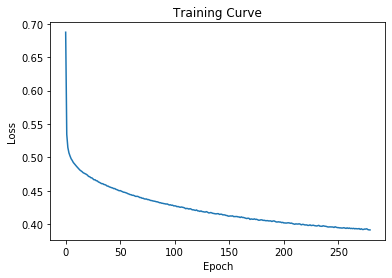

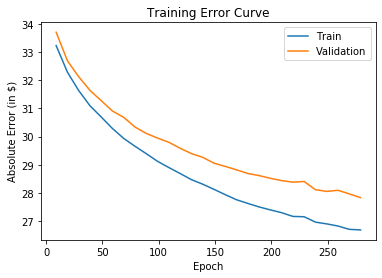

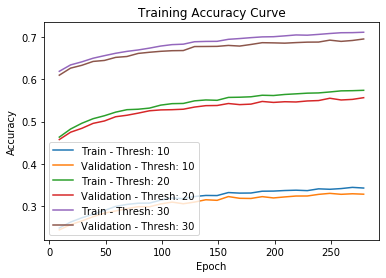

---[ITER 10] loss: 0.388939  time: 3.178
---[ITER 20] loss: 0.387726  time: 3.166
---[ITER 30] loss: 0.391696  time: 3.249
---[ITER 40] loss: 0.394739  time: 3.274
---[ITER 50] loss: 0.394155  time: 3.355
---[ITER 60] loss: 0.386588  time: 3.402
---[ITER 70] loss: 0.392726  time: 3.422
---[ITER 80] loss: 0.400341  time: 3.527
---[ITER 90] loss: 0.391844  time: 3.519
---[ITER 100] loss: 0.393037  time: 3.340
---[ITER 110] loss: 0.387470  time: 3.514
---[ITER 120] loss: 0.393848  time: 3.205
---[ITER 130] loss: 0.391225  time: 3.569
---[ITER 140] loss: 0.394704  time: 3.769
---[ITER 150] loss: 0.388568  time: 3.449
---[ITER 160] loss: 0.390185  time: 3.390
[EPOCH 281] loss: 0.391401  time: 56.964
---[ITER 10] loss: 0.393725  time: 3.298
---[ITER 20] loss: 0.391132  time: 3.210
---[ITER 30] loss: 0.386468  time: 3.263
---[ITER 40] loss: 0.392329  time: 3.337
---[ITER 50] loss: 0.387790  time: 3.394
---[ITER 60] loss: 0.389769  time: 3.509
---[ITER 70] loss: 0.390447  time: 3.445
---[ITER 

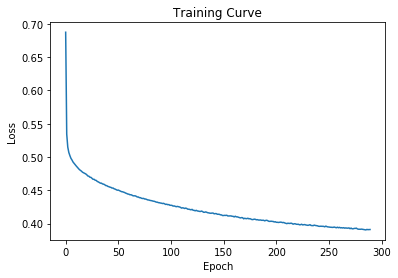

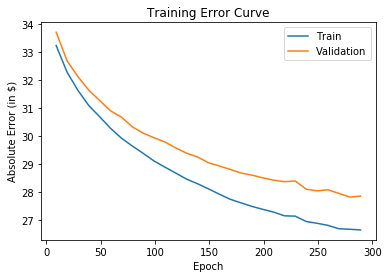

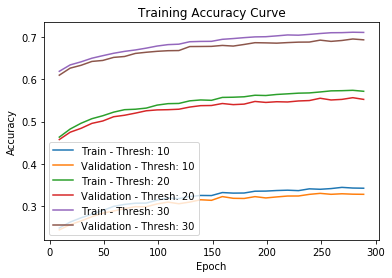

---[ITER 10] loss: 0.390656  time: 3.062
---[ITER 20] loss: 0.397334  time: 2.973
---[ITER 30] loss: 0.387788  time: 3.390
---[ITER 40] loss: 0.392770  time: 2.954
---[ITER 50] loss: 0.395751  time: 2.920
---[ITER 60] loss: 0.397108  time: 2.969
---[ITER 70] loss: 0.389759  time: 2.942
---[ITER 80] loss: 0.384734  time: 2.978
---[ITER 90] loss: 0.391160  time: 3.061
---[ITER 100] loss: 0.387996  time: 2.917
---[ITER 110] loss: 0.395434  time: 3.007
---[ITER 120] loss: 0.391826  time: 2.989
---[ITER 130] loss: 0.387815  time: 2.996
---[ITER 140] loss: 0.378171  time: 3.043
---[ITER 150] loss: 0.393256  time: 2.993
---[ITER 160] loss: 0.393772  time: 3.076
[EPOCH 291] loss: 0.390773  time: 50.575
---[ITER 10] loss: 0.392759  time: 3.004
---[ITER 20] loss: 0.395716  time: 3.030
---[ITER 30] loss: 0.384127  time: 3.034
---[ITER 40] loss: 0.398384  time: 3.108
---[ITER 50] loss: 0.392639  time: 2.959
---[ITER 60] loss: 0.385814  time: 2.901
---[ITER 70] loss: 0.393112  time: 3.200
---[ITER 

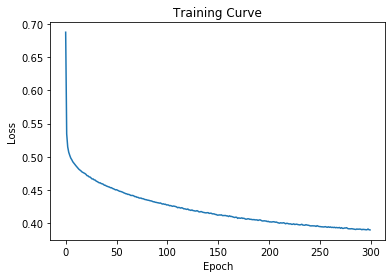

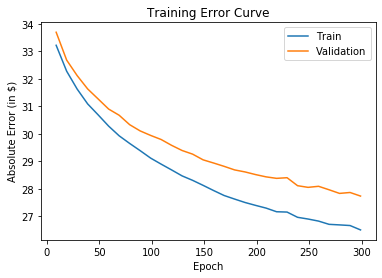

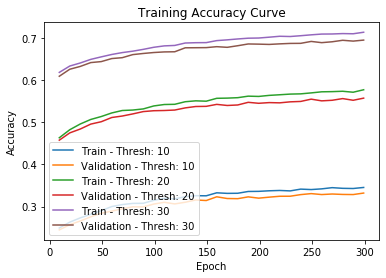

---[ITER 10] loss: 0.398279  time: 5.230
---[ITER 20] loss: 0.390308  time: 3.143
---[ITER 30] loss: 0.389378  time: 3.756
---[ITER 40] loss: 0.397567  time: 3.370
---[ITER 50] loss: 0.380369  time: 4.055
---[ITER 60] loss: 0.388059  time: 5.305
---[ITER 70] loss: 0.394186  time: 3.167
---[ITER 80] loss: 0.383015  time: 3.448
---[ITER 90] loss: 0.380058  time: 2.952
---[ITER 100] loss: 0.393992  time: 3.372
---[ITER 110] loss: 0.394855  time: 3.209
---[ITER 120] loss: 0.393003  time: 3.021
---[ITER 130] loss: 0.387628  time: 3.575
---[ITER 140] loss: 0.393062  time: 3.423
---[ITER 150] loss: 0.382688  time: 3.257
---[ITER 160] loss: 0.389098  time: 3.399
[EPOCH 301] loss: 0.389785  time: 60.647
---[ITER 10] loss: 0.398838  time: 4.073
---[ITER 20] loss: 0.386067  time: 3.748
---[ITER 30] loss: 0.390530  time: 3.034
---[ITER 40] loss: 0.389453  time: 3.056
---[ITER 50] loss: 0.392518  time: 4.057
---[ITER 60] loss: 0.395096  time: 5.567
---[ITER 70] loss: 0.381447  time: 3.384
---[ITER 

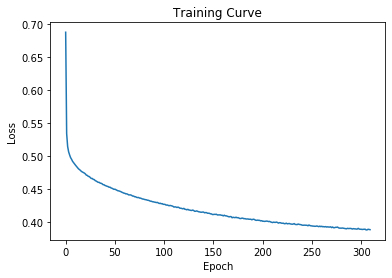

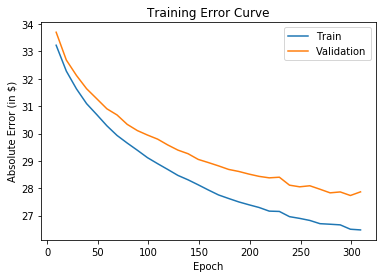

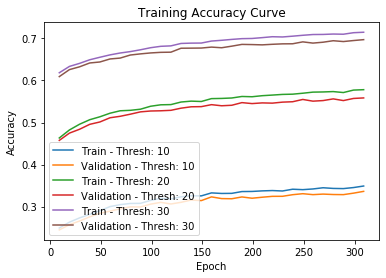

---[ITER 10] loss: 0.399136  time: 4.036
---[ITER 20] loss: 0.383602  time: 3.665
---[ITER 30] loss: 0.383094  time: 3.880
---[ITER 40] loss: 0.390379  time: 3.508
---[ITER 50] loss: 0.387515  time: 3.680
---[ITER 60] loss: 0.383742  time: 3.470
---[ITER 70] loss: 0.391986  time: 3.394
---[ITER 80] loss: 0.386322  time: 3.130
---[ITER 90] loss: 0.390294  time: 2.974
---[ITER 100] loss: 0.389423  time: 3.094
---[ITER 110] loss: 0.382639  time: 3.308
---[ITER 120] loss: 0.390838  time: 3.389
---[ITER 130] loss: 0.393211  time: 3.324
---[ITER 140] loss: 0.392002  time: 3.270
---[ITER 150] loss: 0.393873  time: 3.447
---[ITER 160] loss: 0.374155  time: 3.314
[EPOCH 311] loss: 0.388643  time: 57.516
---[ITER 10] loss: 0.383704  time: 3.381
---[ITER 20] loss: 0.389040  time: 3.420
---[ITER 30] loss: 0.388299  time: 3.380
---[ITER 40] loss: 0.389007  time: 3.720
---[ITER 50] loss: 0.388261  time: 3.527
---[ITER 60] loss: 0.387943  time: 3.381
---[ITER 70] loss: 0.384087  time: 3.536
---[ITER 

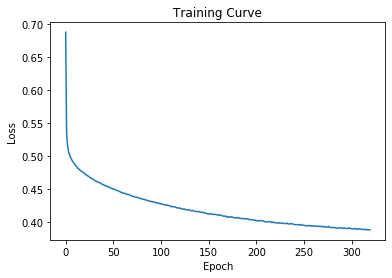

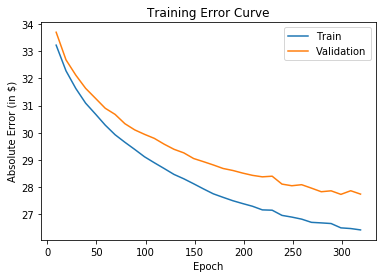

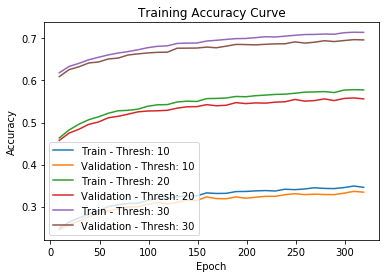

---[ITER 10] loss: 0.384765  time: 3.876
---[ITER 20] loss: 0.388583  time: 5.296
---[ITER 30] loss: 0.384342  time: 4.085
---[ITER 40] loss: 0.384307  time: 3.202
---[ITER 50] loss: 0.389217  time: 3.630
---[ITER 60] loss: 0.383725  time: 3.562
---[ITER 70] loss: 0.386278  time: 3.685
---[ITER 80] loss: 0.385444  time: 3.981
---[ITER 90] loss: 0.395476  time: 3.690
---[ITER 100] loss: 0.388159  time: 3.856
---[ITER 110] loss: 0.384737  time: 3.430
---[ITER 120] loss: 0.388688  time: 3.381
---[ITER 130] loss: 0.398029  time: 3.605
---[ITER 140] loss: 0.390374  time: 3.670
---[ITER 150] loss: 0.388233  time: 3.638
---[ITER 160] loss: 0.385014  time: 3.542
[EPOCH 321] loss: 0.388225  time: 62.796
---[ITER 10] loss: 0.388933  time: 3.729
---[ITER 20] loss: 0.392182  time: 3.874
---[ITER 30] loss: 0.397310  time: 3.508
---[ITER 40] loss: 0.383606  time: 3.427
---[ITER 50] loss: 0.389902  time: 3.427
---[ITER 60] loss: 0.391319  time: 3.066
---[ITER 70] loss: 0.386095  time: 3.427
---[ITER 

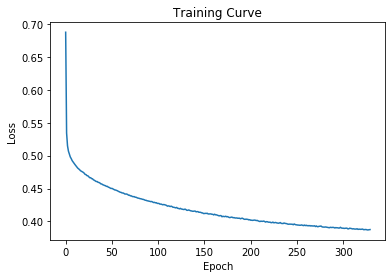

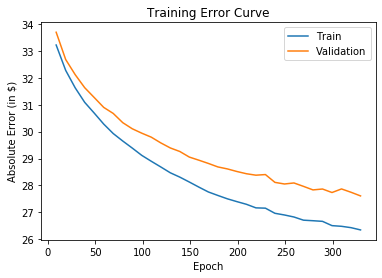

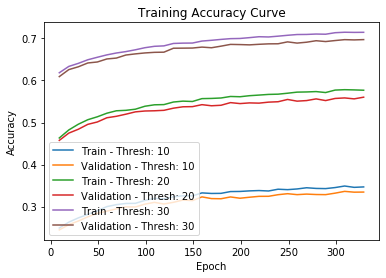

---[ITER 10] loss: 0.385886  time: 3.478
---[ITER 20] loss: 0.392323  time: 3.417
---[ITER 30] loss: 0.393693  time: 3.666
---[ITER 40] loss: 0.386731  time: 3.404
---[ITER 50] loss: 0.387746  time: 3.583
---[ITER 60] loss: 0.385202  time: 3.165
---[ITER 70] loss: 0.394959  time: 3.320
---[ITER 80] loss: 0.395570  time: 4.025
---[ITER 90] loss: 0.384992  time: 3.586
---[ITER 100] loss: 0.383859  time: 3.380
---[ITER 110] loss: 0.382194  time: 3.351
---[ITER 120] loss: 0.376840  time: 3.260
---[ITER 130] loss: 0.383740  time: 3.313
---[ITER 140] loss: 0.380575  time: 3.653
---[ITER 150] loss: 0.390123  time: 3.936
---[ITER 160] loss: 0.387012  time: 3.381
[EPOCH 331] loss: 0.387170  time: 58.727
---[ITER 10] loss: 0.391299  time: 3.443
---[ITER 20] loss: 0.389391  time: 3.617
---[ITER 30] loss: 0.380798  time: 3.330
---[ITER 40] loss: 0.391384  time: 3.377
---[ITER 50] loss: 0.387336  time: 3.226
---[ITER 60] loss: 0.390028  time: 3.160
---[ITER 70] loss: 0.389067  time: 3.123
---[ITER 

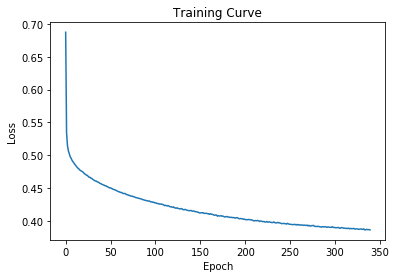

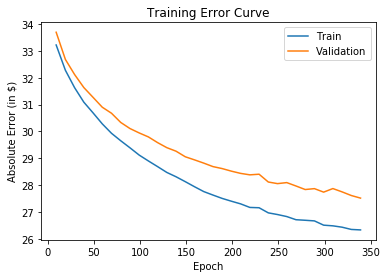

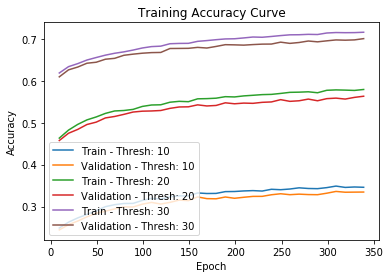

---[ITER 10] loss: 0.387706  time: 3.542
---[ITER 20] loss: 0.382575  time: 3.419
---[ITER 30] loss: 0.388739  time: 3.426
---[ITER 40] loss: 0.380261  time: 3.342
---[ITER 50] loss: 0.386223  time: 3.482
---[ITER 60] loss: 0.387556  time: 3.538
---[ITER 70] loss: 0.380976  time: 3.655
---[ITER 80] loss: 0.390125  time: 3.311
---[ITER 90] loss: 0.382682  time: 3.190
---[ITER 100] loss: 0.397492  time: 3.388
---[ITER 110] loss: 0.385137  time: 3.237
---[ITER 120] loss: 0.386779  time: 3.333
---[ITER 130] loss: 0.390040  time: 3.630
---[ITER 140] loss: 0.383667  time: 4.071
---[ITER 150] loss: 0.388410  time: 4.618
---[ITER 160] loss: 0.385508  time: 3.801
[EPOCH 341] loss: 0.386625  time: 60.246
---[ITER 10] loss: 0.378934  time: 3.503
---[ITER 20] loss: 0.395328  time: 4.468
---[ITER 30] loss: 0.383761  time: 4.116
---[ITER 40] loss: 0.387067  time: 4.119
---[ITER 50] loss: 0.390380  time: 3.290
---[ITER 60] loss: 0.390828  time: 3.745
---[ITER 70] loss: 0.383239  time: 3.500
---[ITER 

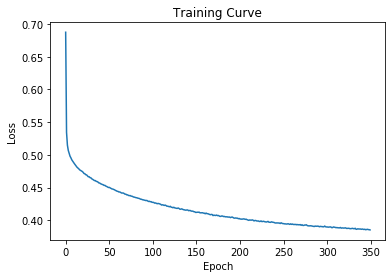

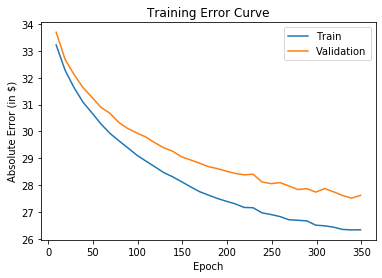

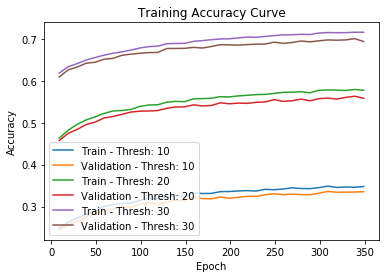

---[ITER 10] loss: 0.383611  time: 3.264
---[ITER 20] loss: 0.394379  time: 3.000
---[ITER 30] loss: 0.387574  time: 3.055
---[ITER 40] loss: 0.375442  time: 2.989
---[ITER 50] loss: 0.387643  time: 3.222
---[ITER 60] loss: 0.378664  time: 3.335
---[ITER 70] loss: 0.382473  time: 3.107
---[ITER 80] loss: 0.382965  time: 3.308
---[ITER 90] loss: 0.394323  time: 3.182
---[ITER 100] loss: 0.383914  time: 3.578
---[ITER 110] loss: 0.390240  time: 3.296
---[ITER 120] loss: 0.383844  time: 3.253
---[ITER 130] loss: 0.377510  time: 3.753
---[ITER 140] loss: 0.386185  time: 3.867
---[ITER 150] loss: 0.393396  time: 4.573
---[ITER 160] loss: 0.390265  time: 3.671
[EPOCH 351] loss: 0.385616  time: 56.882
---[ITER 10] loss: 0.384502  time: 3.706
---[ITER 20] loss: 0.385184  time: 3.641
---[ITER 30] loss: 0.387911  time: 3.434
---[ITER 40] loss: 0.395567  time: 3.743
---[ITER 50] loss: 0.374913  time: 3.409
---[ITER 60] loss: 0.381661  time: 3.440
---[ITER 70] loss: 0.394468  time: 3.225
---[ITER 

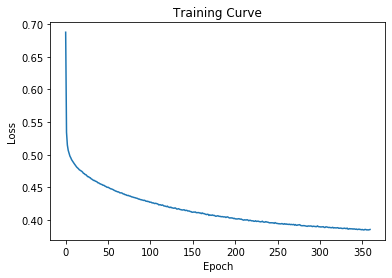

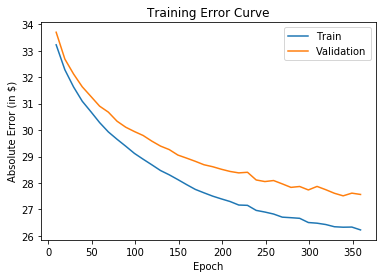

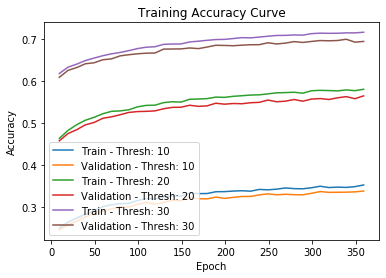

---[ITER 10] loss: 0.382226  time: 4.412
---[ITER 20] loss: 0.380358  time: 3.545
---[ITER 30] loss: 0.381927  time: 3.332
---[ITER 40] loss: 0.386597  time: 3.359
---[ITER 50] loss: 0.386180  time: 3.445
---[ITER 60] loss: 0.383686  time: 3.599
---[ITER 70] loss: 0.384427  time: 3.363
---[ITER 80] loss: 0.382966  time: 3.399
---[ITER 90] loss: 0.385298  time: 3.793
---[ITER 100] loss: 0.384706  time: 3.551
---[ITER 110] loss: 0.387304  time: 3.281
---[ITER 120] loss: 0.385687  time: 3.221
---[ITER 130] loss: 0.384470  time: 3.423
---[ITER 140] loss: 0.380040  time: 3.364
---[ITER 150] loss: 0.384834  time: 3.291
---[ITER 160] loss: 0.391351  time: 3.690
[EPOCH 361] loss: 0.384771  time: 58.638
---[ITER 10] loss: 0.386976  time: 3.286
---[ITER 20] loss: 0.383985  time: 3.437
---[ITER 30] loss: 0.379941  time: 3.434
---[ITER 40] loss: 0.386696  time: 3.531
---[ITER 50] loss: 0.400240  time: 3.965
---[ITER 60] loss: 0.378069  time: 3.239
---[ITER 70] loss: 0.385147  time: 3.595
---[ITER 

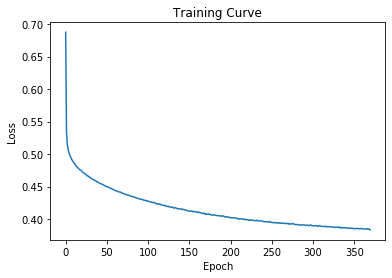

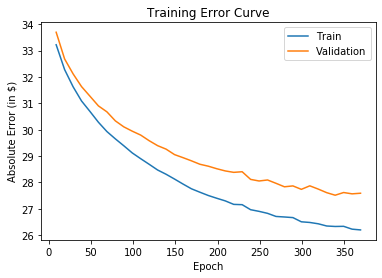

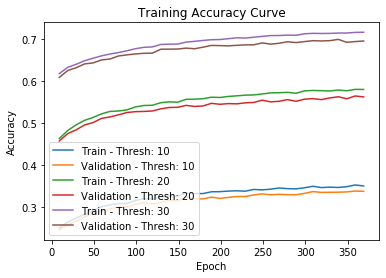

---[ITER 10] loss: 0.384457  time: 3.375
---[ITER 20] loss: 0.384383  time: 3.679
---[ITER 30] loss: 0.383030  time: 3.428
---[ITER 40] loss: 0.384862  time: 3.379
---[ITER 50] loss: 0.381038  time: 3.521
---[ITER 60] loss: 0.386125  time: 3.862
---[ITER 70] loss: 0.382247  time: 3.545
---[ITER 80] loss: 0.385010  time: 3.789
---[ITER 90] loss: 0.387888  time: 3.667
---[ITER 100] loss: 0.387101  time: 4.367
---[ITER 110] loss: 0.378921  time: 4.028
---[ITER 120] loss: 0.384194  time: 3.529
---[ITER 130] loss: 0.385300  time: 3.904
---[ITER 140] loss: 0.386983  time: 3.857
---[ITER 150] loss: 0.380233  time: 3.599
---[ITER 160] loss: 0.390294  time: 3.088
[EPOCH 371] loss: 0.384583  time: 60.956
---[ITER 10] loss: 0.378715  time: 3.467
---[ITER 20] loss: 0.379552  time: 3.434
---[ITER 30] loss: 0.389196  time: 3.393
---[ITER 40] loss: 0.384420  time: 3.280
---[ITER 50] loss: 0.383835  time: 3.207
---[ITER 60] loss: 0.393038  time: 3.139
---[ITER 70] loss: 0.382857  time: 3.320
---[ITER 

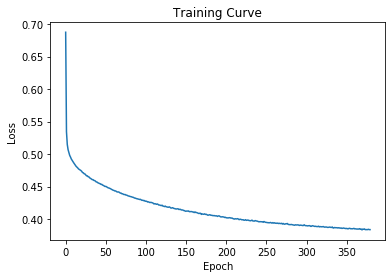

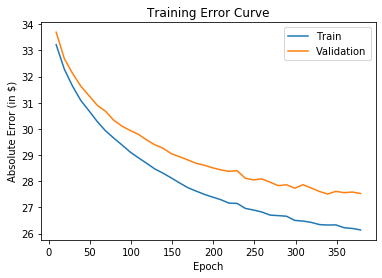

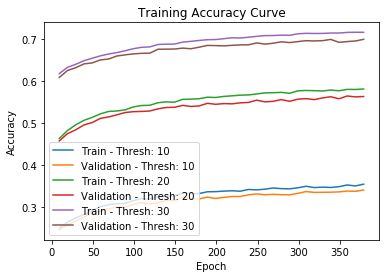

---[ITER 10] loss: 0.378561  time: 3.631
---[ITER 20] loss: 0.385388  time: 3.576
---[ITER 30] loss: 0.392682  time: 3.559
---[ITER 40] loss: 0.380514  time: 3.608
---[ITER 50] loss: 0.382612  time: 3.353
---[ITER 60] loss: 0.383106  time: 3.371
---[ITER 70] loss: 0.384847  time: 3.749
---[ITER 80] loss: 0.379173  time: 3.519
---[ITER 90] loss: 0.386069  time: 3.641
---[ITER 100] loss: 0.384747  time: 3.739
---[ITER 110] loss: 0.373745  time: 3.627
---[ITER 120] loss: 0.386904  time: 3.619
---[ITER 130] loss: 0.382112  time: 3.453
---[ITER 140] loss: 0.387078  time: 3.291
---[ITER 150] loss: 0.382580  time: 3.303
---[ITER 160] loss: 0.394813  time: 3.250
[EPOCH 381] loss: 0.384170  time: 58.873
---[ITER 10] loss: 0.383454  time: 3.505
---[ITER 20] loss: 0.390826  time: 3.867
---[ITER 30] loss: 0.387166  time: 3.611
---[ITER 40] loss: 0.379180  time: 3.573
---[ITER 50] loss: 0.375054  time: 3.673
---[ITER 60] loss: 0.385350  time: 3.521
---[ITER 70] loss: 0.381549  time: 3.411
---[ITER 

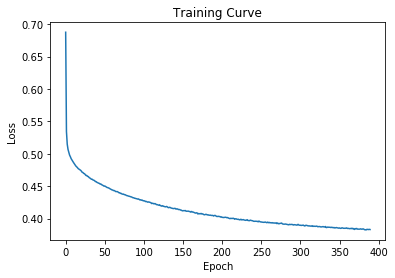

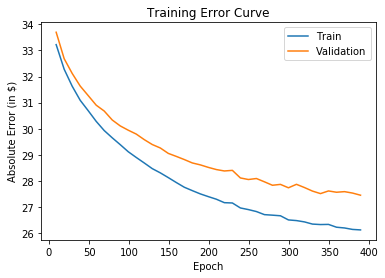

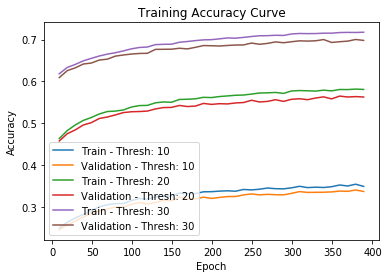

---[ITER 10] loss: 0.381430  time: 3.269
---[ITER 20] loss: 0.382840  time: 3.369
---[ITER 30] loss: 0.390076  time: 3.259
---[ITER 40] loss: 0.382674  time: 3.308
---[ITER 50] loss: 0.386530  time: 3.688
---[ITER 60] loss: 0.375914  time: 3.374
---[ITER 70] loss: 0.374166  time: 3.314
---[ITER 80] loss: 0.386453  time: 3.578
---[ITER 90] loss: 0.385988  time: 3.422
---[ITER 100] loss: 0.383248  time: 3.499
---[ITER 110] loss: 0.375698  time: 3.591
---[ITER 120] loss: 0.383086  time: 3.759
---[ITER 130] loss: 0.383251  time: 3.763
---[ITER 140] loss: 0.383095  time: 3.434
---[ITER 150] loss: 0.375888  time: 3.637
---[ITER 160] loss: 0.380471  time: 3.217
[EPOCH 391] loss: 0.382265  time: 57.926
---[ITER 10] loss: 0.388046  time: 3.406
---[ITER 20] loss: 0.386939  time: 3.374
---[ITER 30] loss: 0.380318  time: 3.394
---[ITER 40] loss: 0.376363  time: 3.461
---[ITER 50] loss: 0.384576  time: 3.603
---[ITER 60] loss: 0.379199  time: 3.569
---[ITER 70] loss: 0.383506  time: 3.479
---[ITER 

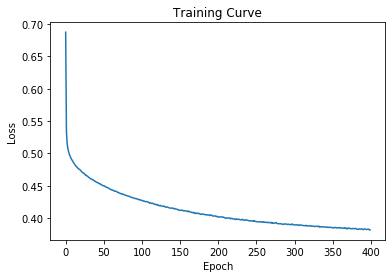

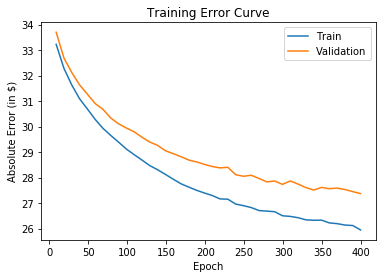

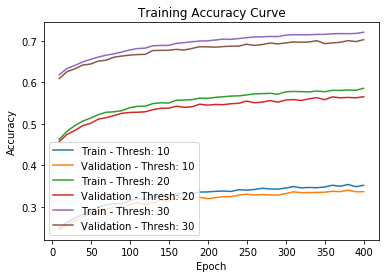

---[ITER 10] loss: 0.375532  time: 3.758
---[ITER 20] loss: 0.376089  time: 3.941
---[ITER 30] loss: 0.387949  time: 3.452
---[ITER 40] loss: 0.391509  time: 3.360
---[ITER 50] loss: 0.381263  time: 3.408
---[ITER 60] loss: 0.380342  time: 3.422
---[ITER 70] loss: 0.385304  time: 3.481
---[ITER 80] loss: 0.379996  time: 3.525
---[ITER 90] loss: 0.380100  time: 3.481
---[ITER 100] loss: 0.383439  time: 3.377
---[ITER 110] loss: 0.380411  time: 3.205
---[ITER 120] loss: 0.380596  time: 3.045
---[ITER 130] loss: 0.385551  time: 3.412
---[ITER 140] loss: 0.385305  time: 3.098
---[ITER 150] loss: 0.385202  time: 3.008
---[ITER 160] loss: 0.376305  time: 3.143
[EPOCH 401] loss: 0.382407  time: 56.436
---[ITER 10] loss: 0.375453  time: 2.898
---[ITER 20] loss: 0.378728  time: 2.917
---[ITER 30] loss: 0.384105  time: 2.944
---[ITER 40] loss: 0.384099  time: 2.957
---[ITER 50] loss: 0.380538  time: 2.931
---[ITER 60] loss: 0.374588  time: 2.975
---[ITER 70] loss: 0.386327  time: 3.014
---[ITER 

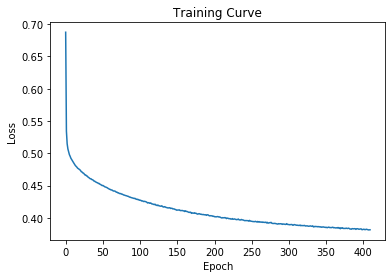

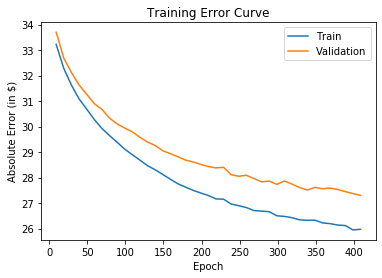

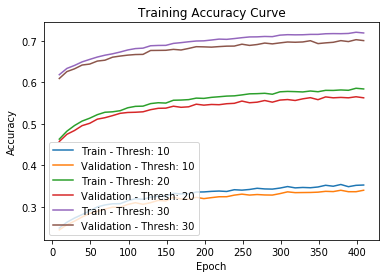

---[ITER 10] loss: 0.376150  time: 2.977
---[ITER 20] loss: 0.383728  time: 3.029
---[ITER 30] loss: 0.387897  time: 3.080
---[ITER 40] loss: 0.382634  time: 3.051
---[ITER 50] loss: 0.385154  time: 3.030
---[ITER 60] loss: 0.384667  time: 2.968
---[ITER 70] loss: 0.383977  time: 3.051
---[ITER 80] loss: 0.385445  time: 2.943
---[ITER 90] loss: 0.381425  time: 3.044
---[ITER 100] loss: 0.378029  time: 2.996
---[ITER 110] loss: 0.378754  time: 2.940
---[ITER 120] loss: 0.376431  time: 3.227
---[ITER 130] loss: 0.377587  time: 3.202
---[ITER 140] loss: 0.382200  time: 3.065
---[ITER 150] loss: 0.383245  time: 3.057
---[ITER 160] loss: 0.381782  time: 2.991
[EPOCH 411] loss: 0.381554  time: 50.989
---[ITER 10] loss: 0.378138  time: 3.076
---[ITER 20] loss: 0.375670  time: 3.062
---[ITER 30] loss: 0.389436  time: 3.072
---[ITER 40] loss: 0.381073  time: 3.125
---[ITER 50] loss: 0.382561  time: 3.038
---[ITER 60] loss: 0.380480  time: 3.024
---[ITER 70] loss: 0.380964  time: 3.048
---[ITER 

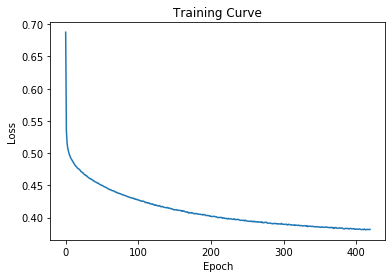

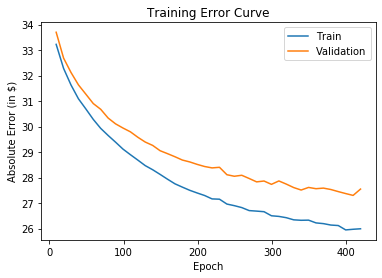

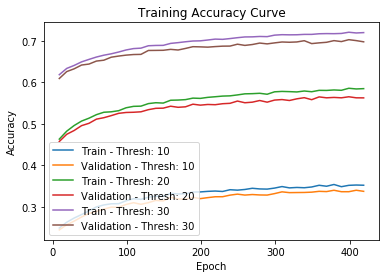

---[ITER 10] loss: 0.378487  time: 3.401
---[ITER 20] loss: 0.385211  time: 4.248
---[ITER 30] loss: 0.383405  time: 3.263
---[ITER 40] loss: 0.380638  time: 2.982
---[ITER 50] loss: 0.386096  time: 3.264
---[ITER 60] loss: 0.381187  time: 3.254
---[ITER 70] loss: 0.385094  time: 4.066
---[ITER 80] loss: 0.382646  time: 3.481
---[ITER 90] loss: 0.385998  time: 3.348
---[ITER 100] loss: 0.383527  time: 3.463
---[ITER 110] loss: 0.382051  time: 3.641
---[ITER 120] loss: 0.377847  time: 3.357
---[ITER 130] loss: 0.376694  time: 3.284
---[ITER 140] loss: 0.385060  time: 3.293
---[ITER 150] loss: 0.383136  time: 3.207
---[ITER 160] loss: 0.378976  time: 3.951
[EPOCH 421] loss: 0.381923  time: 58.092
---[ITER 10] loss: 0.381772  time: 3.248
---[ITER 20] loss: 0.385104  time: 3.255
---[ITER 30] loss: 0.379954  time: 3.278
---[ITER 40] loss: 0.384594  time: 3.246
---[ITER 50] loss: 0.374427  time: 3.428
---[ITER 60] loss: 0.379662  time: 3.182
---[ITER 70] loss: 0.379150  time: 3.208
---[ITER 

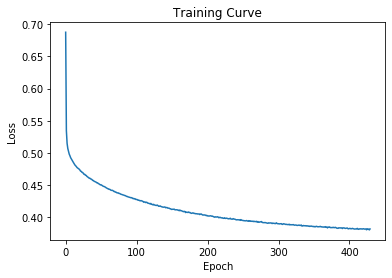

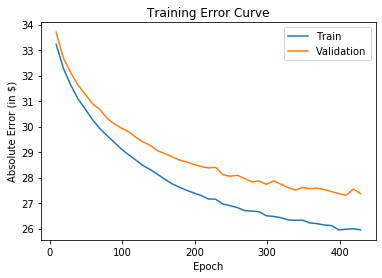

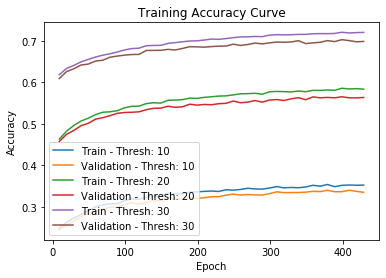

---[ITER 10] loss: 0.378881  time: 3.976
---[ITER 20] loss: 0.383564  time: 3.353
---[ITER 30] loss: 0.385689  time: 3.354
---[ITER 40] loss: 0.376781  time: 3.436
---[ITER 50] loss: 0.382981  time: 3.327
---[ITER 60] loss: 0.385917  time: 3.208
---[ITER 70] loss: 0.386911  time: 3.428
---[ITER 80] loss: 0.376293  time: 3.149
---[ITER 90] loss: 0.377129  time: 3.753
---[ITER 100] loss: 0.381661  time: 3.773
---[ITER 110] loss: 0.376250  time: 4.471
---[ITER 120] loss: 0.381889  time: 3.863
---[ITER 130] loss: 0.377335  time: 2.969
---[ITER 140] loss: 0.381631  time: 3.012
---[ITER 150] loss: 0.375894  time: 3.228
---[ITER 160] loss: 0.382267  time: 3.447
[EPOCH 431] loss: 0.380664  time: 58.520
---[ITER 10] loss: 0.380198  time: 3.399
---[ITER 20] loss: 0.374943  time: 3.306
---[ITER 30] loss: 0.381636  time: 3.059
---[ITER 40] loss: 0.378886  time: 3.080
---[ITER 50] loss: 0.380555  time: 3.101
---[ITER 60] loss: 0.389986  time: 3.082
---[ITER 70] loss: 0.386442  time: 3.072
---[ITER 

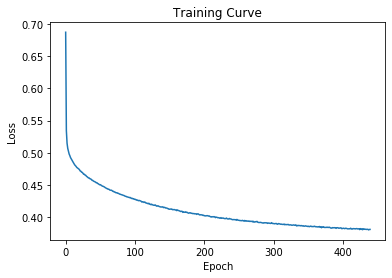

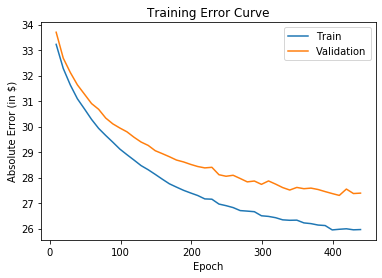

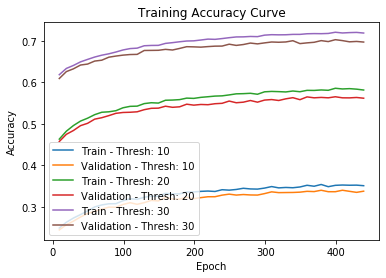

---[ITER 10] loss: 0.375193  time: 3.284
---[ITER 20] loss: 0.376649  time: 3.381
---[ITER 30] loss: 0.382272  time: 4.725
---[ITER 40] loss: 0.380043  time: 4.418
---[ITER 50] loss: 0.384925  time: 3.480
---[ITER 60] loss: 0.386580  time: 3.508
---[ITER 70] loss: 0.381564  time: 3.135
---[ITER 80] loss: 0.380927  time: 3.383
---[ITER 90] loss: 0.381636  time: 3.062
---[ITER 100] loss: 0.383955  time: 3.536
---[ITER 110] loss: 0.374198  time: 3.575
---[ITER 120] loss: 0.372193  time: 3.712
---[ITER 130] loss: 0.372305  time: 3.648
---[ITER 140] loss: 0.379083  time: 3.644
---[ITER 150] loss: 0.388670  time: 3.929
---[ITER 160] loss: 0.383680  time: 3.571
[EPOCH 441] loss: 0.380018  time: 60.491
---[ITER 10] loss: 0.375794  time: 3.418
---[ITER 20] loss: 0.390539  time: 3.547
---[ITER 30] loss: 0.379204  time: 3.515
---[ITER 40] loss: 0.379521  time: 3.506
---[ITER 50] loss: 0.379102  time: 4.011
---[ITER 60] loss: 0.379895  time: 3.256
---[ITER 70] loss: 0.379178  time: 3.322
---[ITER 

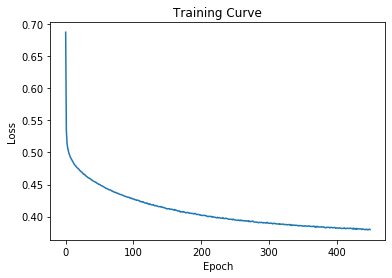

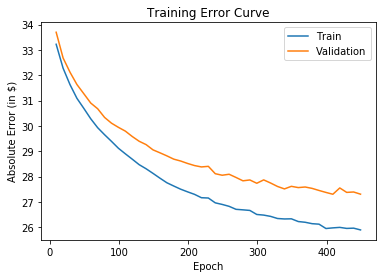

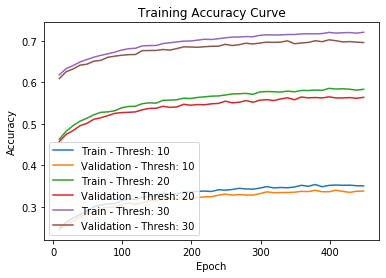

---[ITER 10] loss: 0.382801  time: 3.236
---[ITER 20] loss: 0.373720  time: 3.390
---[ITER 30] loss: 0.377487  time: 3.645
---[ITER 40] loss: 0.388732  time: 5.015
---[ITER 50] loss: 0.378257  time: 3.512
---[ITER 60] loss: 0.388310  time: 3.432
---[ITER 70] loss: 0.385661  time: 3.473
---[ITER 80] loss: 0.381194  time: 3.911
---[ITER 90] loss: 0.381349  time: 4.238
---[ITER 100] loss: 0.381810  time: 5.705
---[ITER 110] loss: 0.375117  time: 10.355
---[ITER 120] loss: 0.385893  time: 5.032
---[ITER 130] loss: 0.379494  time: 6.796
---[ITER 140] loss: 0.373931  time: 6.604
---[ITER 150] loss: 0.379684  time: 4.874
---[ITER 160] loss: 0.376480  time: 4.296
[EPOCH 451] loss: 0.380638  time: 81.001
---[ITER 10] loss: 0.373775  time: 3.518
---[ITER 20] loss: 0.383658  time: 3.402
---[ITER 30] loss: 0.382241  time: 3.904
---[ITER 40] loss: 0.380642  time: 3.581
---[ITER 50] loss: 0.382311  time: 4.651
---[ITER 60] loss: 0.382136  time: 5.786
---[ITER 70] loss: 0.377736  time: 8.791
---[ITER

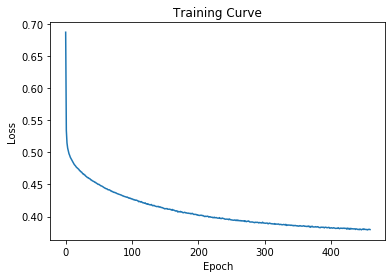

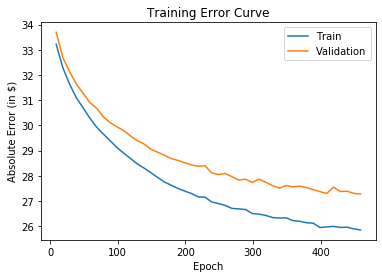

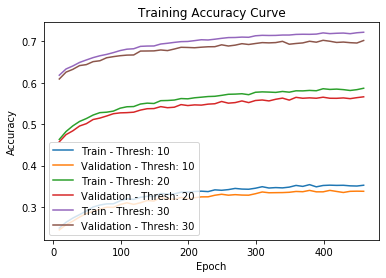

---[ITER 10] loss: 0.378756  time: 4.754
---[ITER 20] loss: 0.373571  time: 3.921
---[ITER 30] loss: 0.385047  time: 3.487
---[ITER 40] loss: 0.375584  time: 3.527
---[ITER 50] loss: 0.378342  time: 3.873
---[ITER 60] loss: 0.375790  time: 4.100
---[ITER 70] loss: 0.386017  time: 3.320
---[ITER 80] loss: 0.382689  time: 3.915
---[ITER 90] loss: 0.384604  time: 3.186
---[ITER 100] loss: 0.381446  time: 3.635
---[ITER 110] loss: 0.386039  time: 3.604
---[ITER 120] loss: 0.379793  time: 3.245
---[ITER 130] loss: 0.376866  time: 3.888
---[ITER 140] loss: 0.384935  time: 6.655
---[ITER 150] loss: 0.378763  time: 8.369
---[ITER 160] loss: 0.370053  time: 5.190
[EPOCH 461] loss: 0.379753  time: 71.517
---[ITER 10] loss: 0.377182  time: 3.077
---[ITER 20] loss: 0.381304  time: 3.479
---[ITER 30] loss: 0.375593  time: 3.054
---[ITER 40] loss: 0.374092  time: 3.685
---[ITER 50] loss: 0.383720  time: 4.220
---[ITER 60] loss: 0.378744  time: 4.663
---[ITER 70] loss: 0.388883  time: 3.165
---[ITER 

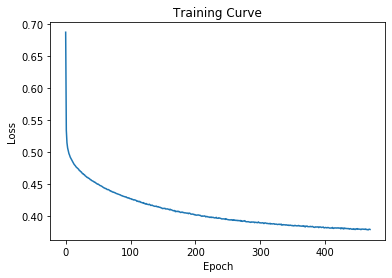

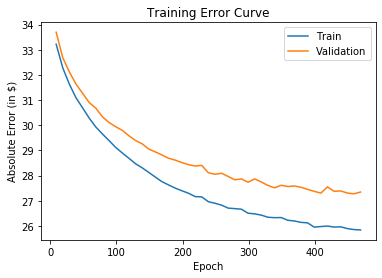

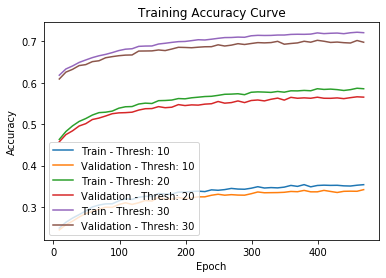

---[ITER 10] loss: 0.380460  time: 4.208
---[ITER 20] loss: 0.380026  time: 4.382
---[ITER 30] loss: 0.384511  time: 4.259
---[ITER 40] loss: 0.381755  time: 5.763
---[ITER 50] loss: 0.377821  time: 4.982
---[ITER 60] loss: 0.380111  time: 4.751
---[ITER 70] loss: 0.378065  time: 4.772
---[ITER 80] loss: 0.380018  time: 4.383
---[ITER 90] loss: 0.384166  time: 4.900
---[ITER 100] loss: 0.369343  time: 4.912
---[ITER 110] loss: 0.376444  time: 4.656
---[ITER 120] loss: 0.372673  time: 4.077
---[ITER 130] loss: 0.381801  time: 4.066
---[ITER 140] loss: 0.379866  time: 4.019
---[ITER 150] loss: 0.392774  time: 4.091
---[ITER 160] loss: 0.379296  time: 4.294
[EPOCH 471] loss: 0.380005  time: 75.391
---[ITER 10] loss: 0.383793  time: 4.070
---[ITER 20] loss: 0.381597  time: 4.010
---[ITER 30] loss: 0.371134  time: 3.958
---[ITER 40] loss: 0.384488  time: 4.135
---[ITER 50] loss: 0.375945  time: 3.953
---[ITER 60] loss: 0.377686  time: 3.995
---[ITER 70] loss: 0.376162  time: 3.955
---[ITER 

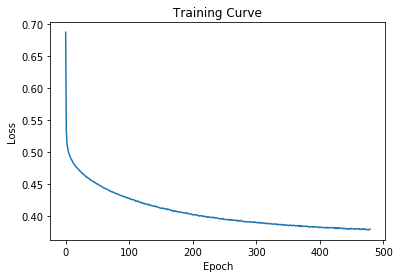

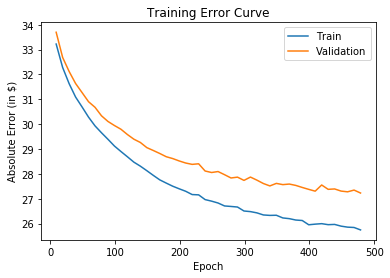

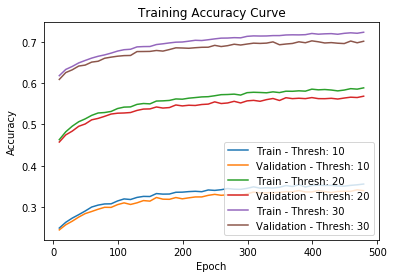

---[ITER 10] loss: 0.376577  time: 3.571
---[ITER 20] loss: 0.372999  time: 3.457
---[ITER 30] loss: 0.375456  time: 3.504
---[ITER 40] loss: 0.381890  time: 3.404
---[ITER 50] loss: 0.380671  time: 3.133
---[ITER 60] loss: 0.375594  time: 3.456
---[ITER 70] loss: 0.378568  time: 3.488
---[ITER 80] loss: 0.385071  time: 3.516
---[ITER 90] loss: 0.372987  time: 3.580
---[ITER 100] loss: 0.372125  time: 3.470
---[ITER 110] loss: 0.372486  time: 3.485
---[ITER 120] loss: 0.391588  time: 3.503
---[ITER 130] loss: 0.380668  time: 3.352
---[ITER 140] loss: 0.380857  time: 3.422
---[ITER 150] loss: 0.375495  time: 3.553
---[ITER 160] loss: 0.373558  time: 3.660
[EPOCH 481] loss: 0.378115  time: 58.247
---[ITER 10] loss: 0.386120  time: 3.437
---[ITER 20] loss: 0.380009  time: 3.515
---[ITER 30] loss: 0.372259  time: 3.509
---[ITER 40] loss: 0.372431  time: 3.423
---[ITER 50] loss: 0.376508  time: 3.169
---[ITER 60] loss: 0.378861  time: 3.500
---[ITER 70] loss: 0.384781  time: 3.420
---[ITER 

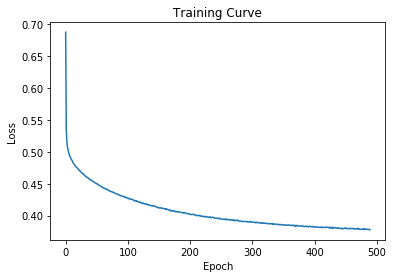

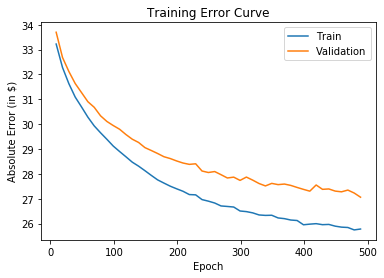

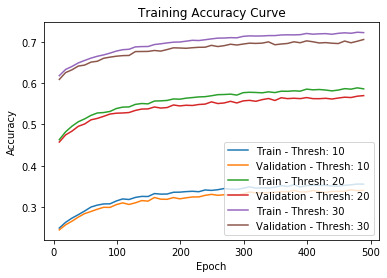

---[ITER 10] loss: 0.380143  time: 3.572
---[ITER 20] loss: 0.381506  time: 3.568
---[ITER 30] loss: 0.378460  time: 3.484
---[ITER 40] loss: 0.380635  time: 3.605
---[ITER 50] loss: 0.379026  time: 3.354
---[ITER 60] loss: 0.376575  time: 3.436
---[ITER 70] loss: 0.379661  time: 3.432
---[ITER 80] loss: 0.375060  time: 3.443
---[ITER 90] loss: 0.376493  time: 3.401
---[ITER 100] loss: 0.376196  time: 3.574
---[ITER 110] loss: 0.382047  time: 3.469
---[ITER 120] loss: 0.380827  time: 3.421
---[ITER 130] loss: 0.371857  time: 3.206
---[ITER 140] loss: 0.380812  time: 3.489
---[ITER 150] loss: 0.377785  time: 3.411
---[ITER 160] loss: 0.376085  time: 3.444
[EPOCH 491] loss: 0.378032  time: 57.983
---[ITER 10] loss: 0.382929  time: 3.404
---[ITER 20] loss: 0.383549  time: 3.754
---[ITER 30] loss: 0.384922  time: 3.599
---[ITER 40] loss: 0.367829  time: 3.411
---[ITER 50] loss: 0.378683  time: 3.622
---[ITER 60] loss: 0.376864  time: 3.582
---[ITER 70] loss: 0.377289  time: 3.476
---[ITER 

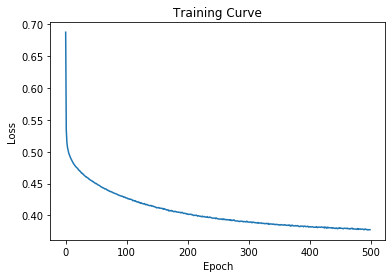

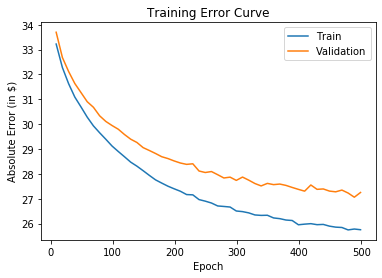

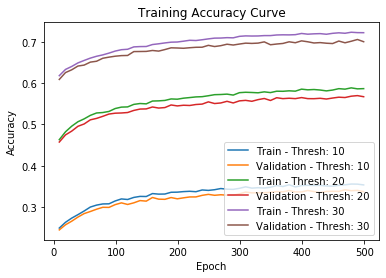

---[ITER 10] loss: 0.381160  time: 3.597
---[ITER 20] loss: 0.380962  time: 3.815
---[ITER 30] loss: 0.371947  time: 3.434
---[ITER 40] loss: 0.372807  time: 3.665
---[ITER 50] loss: 0.374752  time: 3.436
---[ITER 60] loss: 0.379650  time: 3.470
---[ITER 70] loss: 0.372522  time: 3.683
---[ITER 80] loss: 0.386275  time: 3.578
---[ITER 90] loss: 0.380741  time: 3.371
---[ITER 100] loss: 0.378106  time: 3.647
---[ITER 110] loss: 0.374499  time: 3.214
---[ITER 120] loss: 0.373941  time: 3.360
---[ITER 130] loss: 0.375967  time: 3.556
---[ITER 140] loss: 0.372940  time: 3.476
---[ITER 150] loss: 0.379678  time: 3.424
---[ITER 160] loss: 0.375678  time: 3.509
[EPOCH 501] loss: 0.377229  time: 58.919
---[ITER 10] loss: 0.372153  time: 3.472
---[ITER 20] loss: 0.384922  time: 3.552
---[ITER 30] loss: 0.374078  time: 3.161
---[ITER 40] loss: 0.374516  time: 3.580
---[ITER 50] loss: 0.381503  time: 3.581
---[ITER 60] loss: 0.378715  time: 3.470
---[ITER 70] loss: 0.377638  time: 3.510
---[ITER 

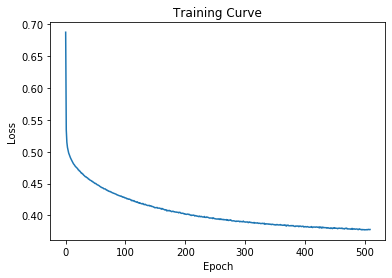

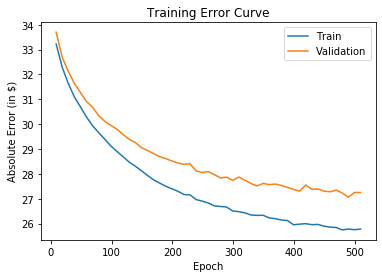

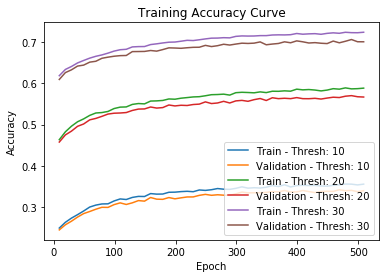

---[ITER 10] loss: 0.376555  time: 4.746
---[ITER 20] loss: 0.379668  time: 4.641
---[ITER 30] loss: 0.377570  time: 5.765
---[ITER 40] loss: 0.378226  time: 5.042
---[ITER 50] loss: 0.367881  time: 4.064
---[ITER 60] loss: 0.372128  time: 4.143
---[ITER 70] loss: 0.379206  time: 5.394
---[ITER 80] loss: 0.372469  time: 5.106
---[ITER 90] loss: 0.376435  time: 4.430
---[ITER 100] loss: 0.377229  time: 6.461
---[ITER 110] loss: 0.376737  time: 5.950
---[ITER 120] loss: 0.377207  time: 5.104
---[ITER 130] loss: 0.387861  time: 5.294
---[ITER 140] loss: 0.379085  time: 4.633
---[ITER 150] loss: 0.382049  time: 4.849
---[ITER 160] loss: 0.387909  time: 4.423
[EPOCH 511] loss: 0.377887  time: 83.948
---[ITER 10] loss: 0.376866  time: 6.696
---[ITER 20] loss: 0.371017  time: 4.877
---[ITER 30] loss: 0.377599  time: 4.928
---[ITER 40] loss: 0.380573  time: 5.121
---[ITER 50] loss: 0.379314  time: 4.594
---[ITER 60] loss: 0.367411  time: 4.817
---[ITER 70] loss: 0.384398  time: 6.595
---[ITER 

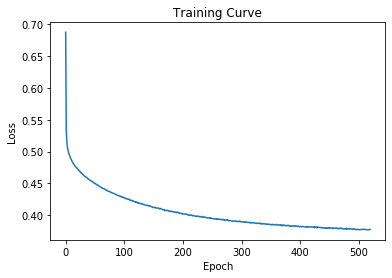

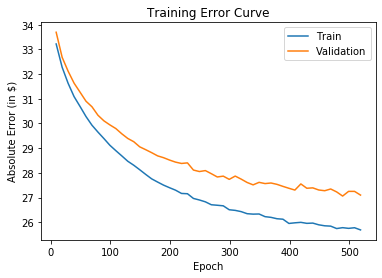

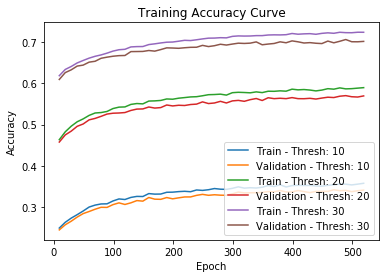

---[ITER 10] loss: 0.376897  time: 2.818
---[ITER 20] loss: 0.385609  time: 2.768
---[ITER 30] loss: 0.373967  time: 3.143
---[ITER 40] loss: 0.383733  time: 3.214
---[ITER 50] loss: 0.369996  time: 3.193
---[ITER 60] loss: 0.374184  time: 2.838
---[ITER 70] loss: 0.376445  time: 2.576
---[ITER 80] loss: 0.377129  time: 2.606
---[ITER 90] loss: 0.364163  time: 2.520
---[ITER 100] loss: 0.372944  time: 2.757
---[ITER 110] loss: 0.377858  time: 2.795
---[ITER 120] loss: 0.374089  time: 3.026
---[ITER 130] loss: 0.384769  time: 2.758
---[ITER 140] loss: 0.377094  time: 2.758
---[ITER 150] loss: 0.384501  time: 3.230
---[ITER 160] loss: 0.375831  time: 2.789
[EPOCH 521] loss: 0.377094  time: 47.809
---[ITER 10] loss: 0.378701  time: 2.852
---[ITER 20] loss: 0.373751  time: 3.094
---[ITER 30] loss: 0.371642  time: 3.223
---[ITER 40] loss: 0.378658  time: 2.964
---[ITER 50] loss: 0.371016  time: 2.983
---[ITER 60] loss: 0.375929  time: 2.860
---[ITER 70] loss: 0.383522  time: 2.821
---[ITER 

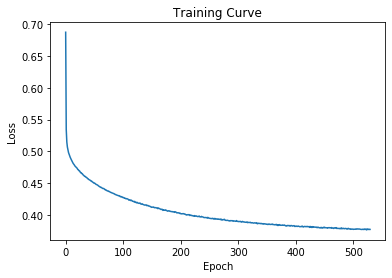

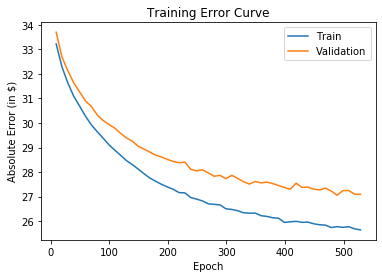

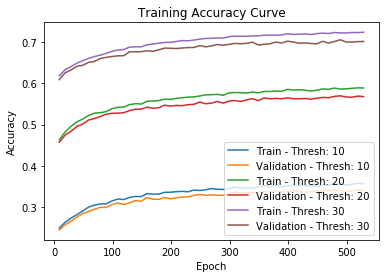

---[ITER 10] loss: 0.377363  time: 2.760
---[ITER 20] loss: 0.378321  time: 2.774
---[ITER 30] loss: 0.374962  time: 3.077
---[ITER 40] loss: 0.381210  time: 2.950
---[ITER 50] loss: 0.379162  time: 2.996
---[ITER 60] loss: 0.368369  time: 2.826
---[ITER 70] loss: 0.378799  time: 2.659
---[ITER 80] loss: 0.375323  time: 2.681
---[ITER 90] loss: 0.386733  time: 3.020
---[ITER 100] loss: 0.376258  time: 2.781
---[ITER 110] loss: 0.370159  time: 2.616
---[ITER 120] loss: 0.384645  time: 2.612
---[ITER 130] loss: 0.382663  time: 2.942
---[ITER 140] loss: 0.373841  time: 2.773
---[ITER 150] loss: 0.377951  time: 3.087
---[ITER 160] loss: 0.375510  time: 2.761
[EPOCH 531] loss: 0.377210  time: 47.488
---[ITER 10] loss: 0.373998  time: 2.884
---[ITER 20] loss: 0.370804  time: 3.675
---[ITER 30] loss: 0.374644  time: 3.408
---[ITER 40] loss: 0.375451  time: 3.101
---[ITER 50] loss: 0.385160  time: 2.792
---[ITER 60] loss: 0.376397  time: 2.890
---[ITER 70] loss: 0.383564  time: 3.390
---[ITER 

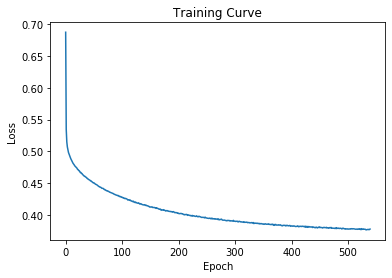

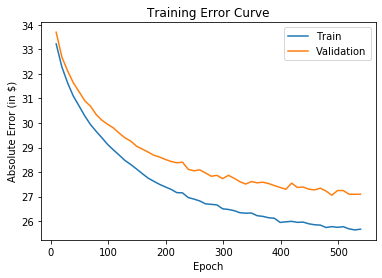

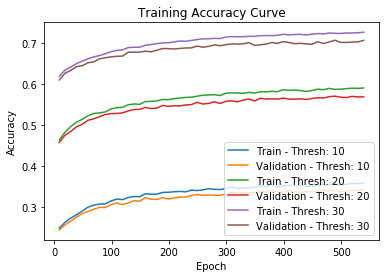

---[ITER 10] loss: 0.370849  time: 3.934
---[ITER 20] loss: 0.375305  time: 6.478
---[ITER 30] loss: 0.381726  time: 5.885
---[ITER 40] loss: 0.381493  time: 4.331
---[ITER 50] loss: 0.375299  time: 4.353
---[ITER 60] loss: 0.376103  time: 3.589
---[ITER 70] loss: 0.378494  time: 3.917
---[ITER 80] loss: 0.380618  time: 3.725
---[ITER 90] loss: 0.374301  time: 3.548
---[ITER 100] loss: 0.373122  time: 3.432
---[ITER 110] loss: 0.375781  time: 3.562
---[ITER 120] loss: 0.374195  time: 3.347
---[ITER 130] loss: 0.379199  time: 3.997
---[ITER 140] loss: 0.376884  time: 3.593
---[ITER 150] loss: 0.378217  time: 3.485
---[ITER 160] loss: 0.376215  time: 5.294
[EPOCH 541] loss: 0.376835  time: 69.861
---[ITER 10] loss: 0.381827  time: 3.643
---[ITER 20] loss: 0.372156  time: 4.442
---[ITER 30] loss: 0.380866  time: 3.520
---[ITER 40] loss: 0.377786  time: 3.240
---[ITER 50] loss: 0.376239  time: 3.766
---[ITER 60] loss: 0.383454  time: 4.123
---[ITER 70] loss: 0.370886  time: 4.675
---[ITER 

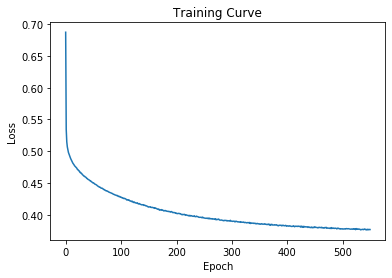

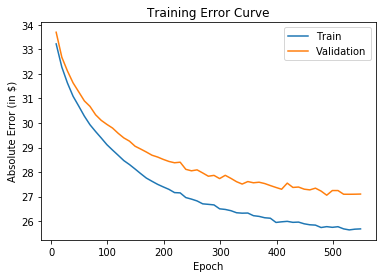

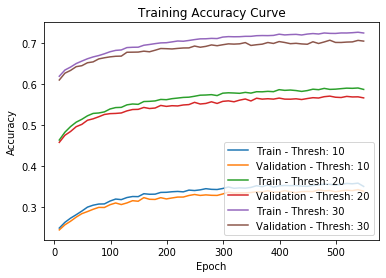

---[ITER 10] loss: 0.373494  time: 4.162
---[ITER 20] loss: 0.380945  time: 4.164
---[ITER 30] loss: 0.362646  time: 3.898
---[ITER 40] loss: 0.381615  time: 4.131
---[ITER 50] loss: 0.371705  time: 4.102
---[ITER 60] loss: 0.374481  time: 4.134
---[ITER 70] loss: 0.378807  time: 4.132
---[ITER 80] loss: 0.370117  time: 4.154
---[ITER 90] loss: 0.368526  time: 4.075
---[ITER 100] loss: 0.376135  time: 4.186
---[ITER 110] loss: 0.385607  time: 4.151
---[ITER 120] loss: 0.381329  time: 4.149
---[ITER 130] loss: 0.371768  time: 4.421
---[ITER 140] loss: 0.380756  time: 4.204
---[ITER 150] loss: 0.376675  time: 4.055
---[ITER 160] loss: 0.380240  time: 4.292
[EPOCH 551] loss: 0.376234  time: 69.634
---[ITER 10] loss: 0.372478  time: 4.287
---[ITER 20] loss: 0.379606  time: 4.305
---[ITER 30] loss: 0.374448  time: 3.946
---[ITER 40] loss: 0.377095  time: 4.026
---[ITER 50] loss: 0.376022  time: 4.154
---[ITER 60] loss: 0.382287  time: 4.258
---[ITER 70] loss: 0.374424  time: 4.176
---[ITER 

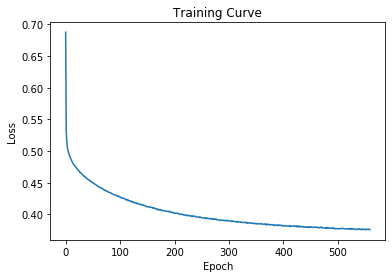

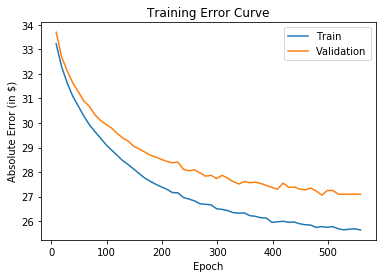

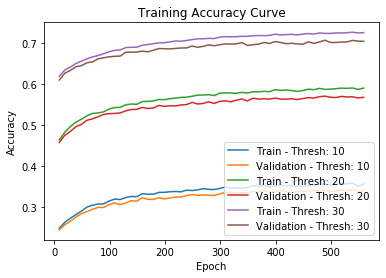

---[ITER 10] loss: 0.379152  time: 4.293
---[ITER 20] loss: 0.379427  time: 4.132
---[ITER 30] loss: 0.374407  time: 4.392
---[ITER 40] loss: 0.371993  time: 4.109
---[ITER 50] loss: 0.376897  time: 4.181
---[ITER 60] loss: 0.377971  time: 3.960
---[ITER 70] loss: 0.370653  time: 4.067
---[ITER 80] loss: 0.372572  time: 4.144
---[ITER 90] loss: 0.371287  time: 4.128
---[ITER 100] loss: 0.378718  time: 4.225
---[ITER 110] loss: 0.382981  time: 4.108
---[ITER 120] loss: 0.374016  time: 4.400
---[ITER 130] loss: 0.377563  time: 4.296
---[ITER 140] loss: 0.381367  time: 4.286
---[ITER 150] loss: 0.373200  time: 4.566
---[ITER 160] loss: 0.379588  time: 4.122
[EPOCH 561] loss: 0.376061  time: 70.628
---[ITER 10] loss: 0.374151  time: 4.144
---[ITER 20] loss: 0.378180  time: 4.291
---[ITER 30] loss: 0.380759  time: 4.119
---[ITER 40] loss: 0.376734  time: 4.065
---[ITER 50] loss: 0.384184  time: 4.175
---[ITER 60] loss: 0.372114  time: 4.335
---[ITER 70] loss: 0.379112  time: 4.083
---[ITER 

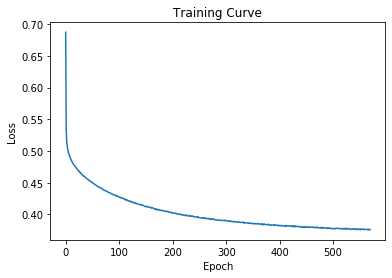

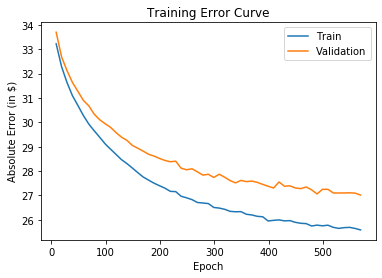

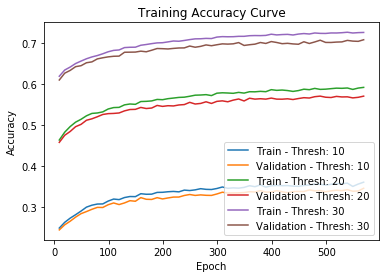

---[ITER 10] loss: 0.375439  time: 3.953
---[ITER 20] loss: 0.373465  time: 4.141
---[ITER 30] loss: 0.379847  time: 4.185
---[ITER 40] loss: 0.380829  time: 4.146
---[ITER 50] loss: 0.378074  time: 4.145
---[ITER 60] loss: 0.371755  time: 4.215
---[ITER 70] loss: 0.377620  time: 4.079
---[ITER 80] loss: 0.378448  time: 4.156
---[ITER 90] loss: 0.376501  time: 3.961
---[ITER 100] loss: 0.386293  time: 4.018
---[ITER 110] loss: 0.374791  time: 4.341
---[ITER 120] loss: 0.372424  time: 4.344
---[ITER 130] loss: 0.371893  time: 4.308
---[ITER 140] loss: 0.374354  time: 4.153
---[ITER 150] loss: 0.371539  time: 4.113
---[ITER 160] loss: 0.370888  time: 4.340
[EPOCH 571] loss: 0.376059  time: 70.036
---[ITER 10] loss: 0.376878  time: 4.007
---[ITER 20] loss: 0.368323  time: 4.034
---[ITER 30] loss: 0.375210  time: 4.143
---[ITER 40] loss: 0.373530  time: 4.124
---[ITER 50] loss: 0.377853  time: 4.153
---[ITER 60] loss: 0.370259  time: 4.144
---[ITER 70] loss: 0.374497  time: 4.172
---[ITER 

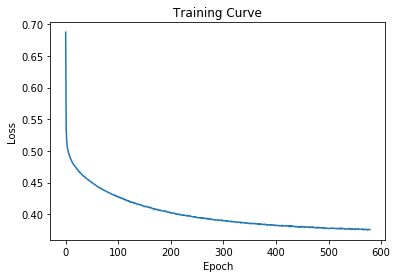

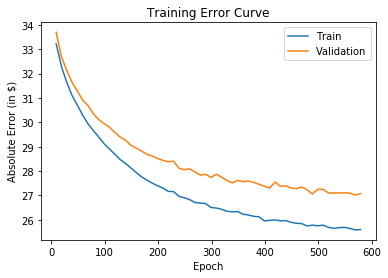

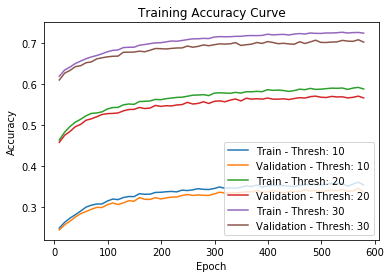

---[ITER 10] loss: 0.382889  time: 4.195
---[ITER 20] loss: 0.374269  time: 4.382
---[ITER 30] loss: 0.376745  time: 4.190
---[ITER 40] loss: 0.374774  time: 4.272
---[ITER 50] loss: 0.376423  time: 4.041
---[ITER 60] loss: 0.373963  time: 4.225
---[ITER 70] loss: 0.376978  time: 4.110
---[ITER 80] loss: 0.375302  time: 4.187
---[ITER 90] loss: 0.373484  time: 4.117
---[ITER 100] loss: 0.378533  time: 4.169
---[ITER 110] loss: 0.380167  time: 4.362
---[ITER 120] loss: 0.369027  time: 4.286
---[ITER 130] loss: 0.368557  time: 4.251
---[ITER 140] loss: 0.379809  time: 3.957
---[ITER 150] loss: 0.377529  time: 4.254
---[ITER 160] loss: 0.370141  time: 4.154
[EPOCH 581] loss: 0.375967  time: 70.371
---[ITER 10] loss: 0.379593  time: 4.184
---[ITER 20] loss: 0.371349  time: 4.231
---[ITER 30] loss: 0.375343  time: 4.491
---[ITER 40] loss: 0.373643  time: 4.277
---[ITER 50] loss: 0.377821  time: 4.140
---[ITER 60] loss: 0.372346  time: 3.923
---[ITER 70] loss: 0.375743  time: 4.158
---[ITER 

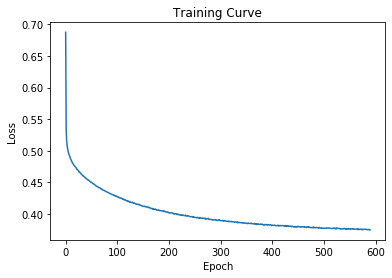

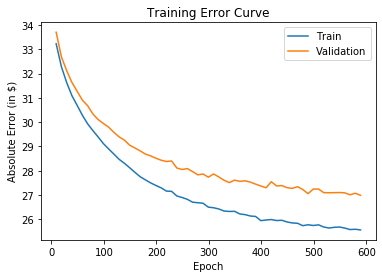

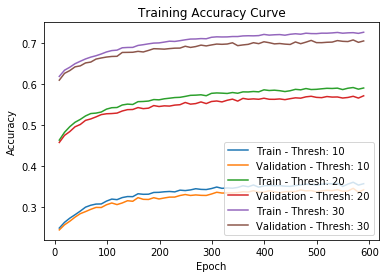

---[ITER 10] loss: 0.379458  time: 4.368
---[ITER 20] loss: 0.371285  time: 4.130
---[ITER 30] loss: 0.376080  time: 4.419
---[ITER 40] loss: 0.372070  time: 3.791
---[ITER 50] loss: 0.374966  time: 3.961
---[ITER 60] loss: 0.368692  time: 3.748
---[ITER 70] loss: 0.377726  time: 4.808
---[ITER 80] loss: 0.373819  time: 6.695
---[ITER 90] loss: 0.367608  time: 5.412
---[ITER 100] loss: 0.377684  time: 3.878
---[ITER 110] loss: 0.376706  time: 4.935
---[ITER 120] loss: 0.377593  time: 5.328
---[ITER 130] loss: 0.368966  time: 5.058
---[ITER 140] loss: 0.376006  time: 4.826
---[ITER 150] loss: 0.376881  time: 5.057
---[ITER 160] loss: 0.375206  time: 5.504
[EPOCH 591] loss: 0.374929  time: 79.996
---[ITER 10] loss: 0.376174  time: 5.013
---[ITER 20] loss: 0.375326  time: 5.091
---[ITER 30] loss: 0.370957  time: 4.833
---[ITER 40] loss: 0.371814  time: 4.939
---[ITER 50] loss: 0.376044  time: 7.376
---[ITER 60] loss: 0.364103  time: 4.371
---[ITER 70] loss: 0.370226  time: 4.703
---[ITER 

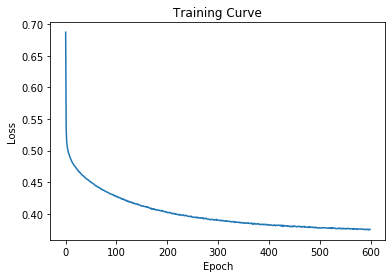

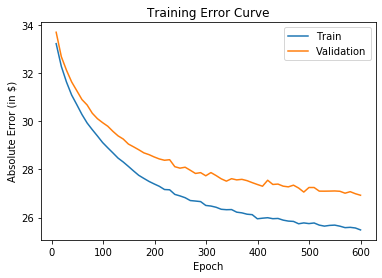

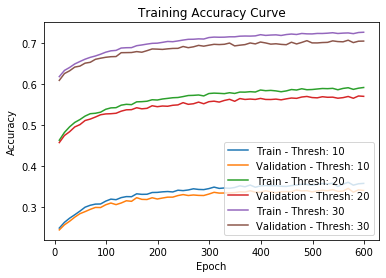

---[ITER 10] loss: 0.365208  time: 7.851
---[ITER 20] loss: 0.378191  time: 6.672
---[ITER 30] loss: 0.374219  time: 5.282
---[ITER 40] loss: 0.375167  time: 5.291
---[ITER 50] loss: 0.373688  time: 5.408
---[ITER 60] loss: 0.376353  time: 5.121
---[ITER 70] loss: 0.376472  time: 5.018
---[ITER 80] loss: 0.376884  time: 4.620
---[ITER 90] loss: 0.370343  time: 4.775
---[ITER 100] loss: 0.374186  time: 4.630
---[ITER 110] loss: 0.365968  time: 4.582
---[ITER 120] loss: 0.373766  time: 5.230
---[ITER 130] loss: 0.372960  time: 6.102
---[ITER 140] loss: 0.374426  time: 5.405
---[ITER 150] loss: 0.384284  time: 6.592
---[ITER 160] loss: 0.379392  time: 7.294
[EPOCH 601] loss: 0.374551  time: 95.037
---[ITER 10] loss: 0.374070  time: 7.639
---[ITER 20] loss: 0.378692  time: 5.643
---[ITER 30] loss: 0.373330  time: 4.929
---[ITER 40] loss: 0.374935  time: 5.275
---[ITER 50] loss: 0.381524  time: 5.784
---[ITER 60] loss: 0.374065  time: 5.969
---[ITER 70] loss: 0.376997  time: 6.023
---[ITER 

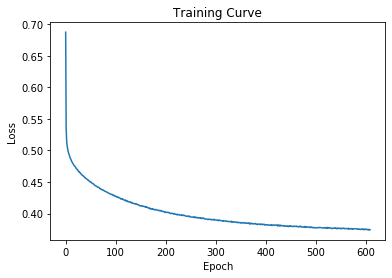

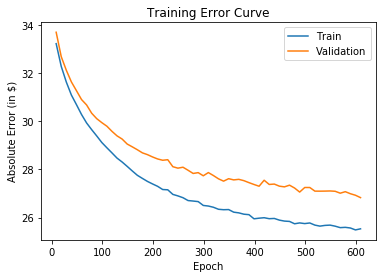

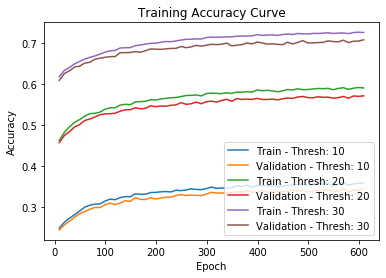

---[ITER 10] loss: 0.371885  time: 5.962
---[ITER 20] loss: 0.378837  time: 5.776
---[ITER 30] loss: 0.375281  time: 5.928
---[ITER 40] loss: 0.375017  time: 5.602
---[ITER 50] loss: 0.380001  time: 5.967
---[ITER 60] loss: 0.378209  time: 5.661
---[ITER 70] loss: 0.367691  time: 5.550
---[ITER 80] loss: 0.378476  time: 5.857
---[ITER 90] loss: 0.374477  time: 5.905
---[ITER 100] loss: 0.376976  time: 5.996
---[ITER 110] loss: 0.375107  time: 6.030
---[ITER 120] loss: 0.369154  time: 5.749
---[ITER 130] loss: 0.373695  time: 5.480
---[ITER 140] loss: 0.382954  time: 6.674
---[ITER 150] loss: 0.374421  time: 5.807
---[ITER 160] loss: 0.367959  time: 5.742
[EPOCH 611] loss: 0.375163  time: 98.186
---[ITER 10] loss: 0.370735  time: 5.983
---[ITER 20] loss: 0.381712  time: 6.075
---[ITER 30] loss: 0.375464  time: 5.640
---[ITER 40] loss: 0.377227  time: 6.125
---[ITER 50] loss: 0.374179  time: 5.817
---[ITER 60] loss: 0.368419  time: 6.147
---[ITER 70] loss: 0.372943  time: 5.881
---[ITER 

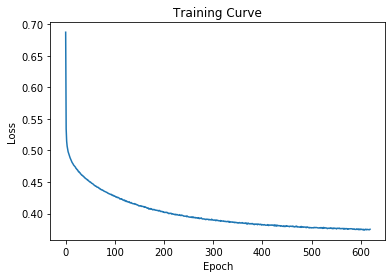

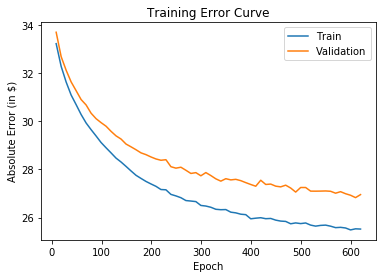

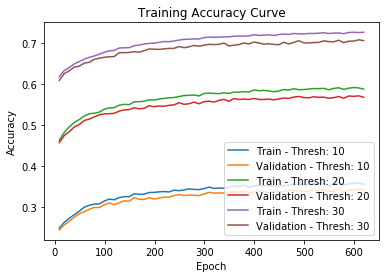

---[ITER 10] loss: 0.373663  time: 4.959
---[ITER 20] loss: 0.372535  time: 4.985
---[ITER 30] loss: 0.377161  time: 5.212
---[ITER 40] loss: 0.369745  time: 5.096
---[ITER 50] loss: 0.366212  time: 5.059
---[ITER 60] loss: 0.373727  time: 4.804
---[ITER 70] loss: 0.376305  time: 4.864
---[ITER 80] loss: 0.377012  time: 5.019
---[ITER 90] loss: 0.378551  time: 5.170
---[ITER 100] loss: 0.374378  time: 4.850
---[ITER 110] loss: 0.378753  time: 5.183
---[ITER 120] loss: 0.378986  time: 5.203
---[ITER 130] loss: 0.374146  time: 5.064
---[ITER 140] loss: 0.380450  time: 4.978
---[ITER 150] loss: 0.361769  time: 5.118
---[ITER 160] loss: 0.376253  time: 5.176
[EPOCH 621] loss: 0.374397  time: 84.988
---[ITER 10] loss: 0.375513  time: 4.918
---[ITER 20] loss: 0.371446  time: 5.000
---[ITER 30] loss: 0.372742  time: 4.946
---[ITER 40] loss: 0.373532  time: 4.893
---[ITER 50] loss: 0.373653  time: 4.847
---[ITER 60] loss: 0.378957  time: 5.399
---[ITER 70] loss: 0.376786  time: 4.964
---[ITER 

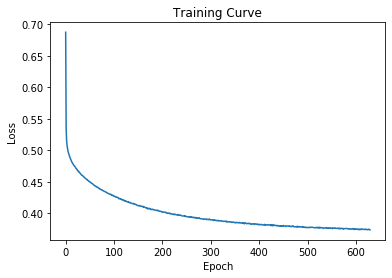

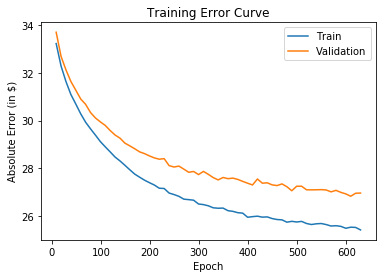

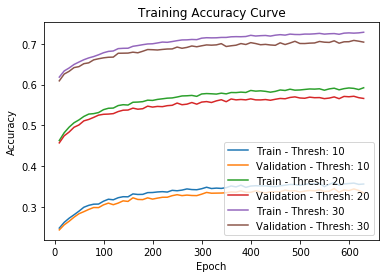

---[ITER 10] loss: 0.364155  time: 5.467
---[ITER 20] loss: 0.371108  time: 6.027
---[ITER 30] loss: 0.377684  time: 5.092
---[ITER 40] loss: 0.376413  time: 4.734
---[ITER 50] loss: 0.369437  time: 7.088
---[ITER 60] loss: 0.380689  time: 4.868
---[ITER 70] loss: 0.376695  time: 4.581
---[ITER 80] loss: 0.375313  time: 4.588
---[ITER 90] loss: 0.381191  time: 6.753
---[ITER 100] loss: 0.371880  time: 5.322
---[ITER 110] loss: 0.373708  time: 8.240
---[ITER 120] loss: 0.374211  time: 6.185
---[ITER 130] loss: 0.373770  time: 5.794
---[ITER 140] loss: 0.380671  time: 5.524
---[ITER 150] loss: 0.377469  time: 5.210
---[ITER 160] loss: 0.372381  time: 5.080
[EPOCH 631] loss: 0.374950  time: 94.397
---[ITER 10] loss: 0.372723  time: 5.188
---[ITER 20] loss: 0.371415  time: 4.641
---[ITER 30] loss: 0.381807  time: 4.541
---[ITER 40] loss: 0.371099  time: 4.781
---[ITER 50] loss: 0.372774  time: 5.210
---[ITER 60] loss: 0.372115  time: 4.729
---[ITER 70] loss: 0.373465  time: 5.059
---[ITER 

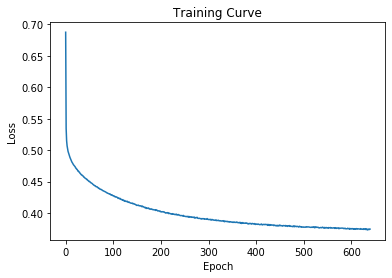

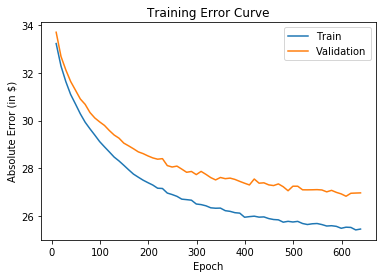

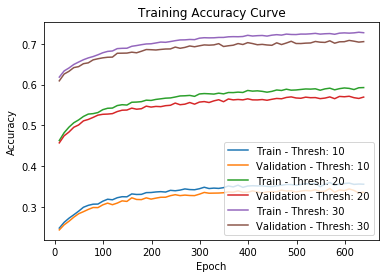

---[ITER 10] loss: 0.375124  time: 5.410
---[ITER 20] loss: 0.375248  time: 5.361
---[ITER 30] loss: 0.372983  time: 5.346
---[ITER 40] loss: 0.375824  time: 5.274
---[ITER 50] loss: 0.381306  time: 5.575
---[ITER 60] loss: 0.375182  time: 5.830
---[ITER 70] loss: 0.375429  time: 5.649
---[ITER 80] loss: 0.376564  time: 5.602
---[ITER 90] loss: 0.369744  time: 5.510
---[ITER 100] loss: 0.378475  time: 5.371
---[ITER 110] loss: 0.378547  time: 5.567
---[ITER 120] loss: 0.367900  time: 5.409
---[ITER 130] loss: 0.371996  time: 5.287
---[ITER 140] loss: 0.368809  time: 5.432
---[ITER 150] loss: 0.374292  time: 5.366
---[ITER 160] loss: 0.373472  time: 5.445
[EPOCH 641] loss: 0.374527  time: 91.785
---[ITER 10] loss: 0.380632  time: 7.066
---[ITER 20] loss: 0.372572  time: 9.354
---[ITER 30] loss: 0.372404  time: 7.457
---[ITER 40] loss: 0.373759  time: 5.519
---[ITER 50] loss: 0.371281  time: 5.446
---[ITER 60] loss: 0.372026  time: 5.989
---[ITER 70] loss: 0.366642  time: 5.881
---[ITER 

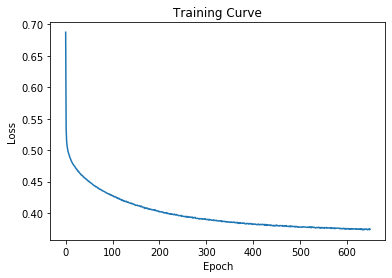

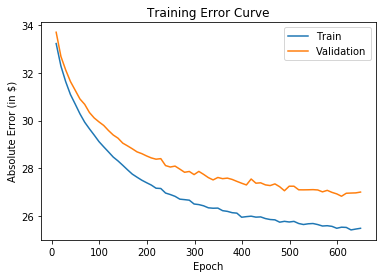

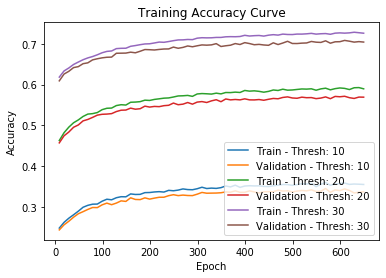

---[ITER 10] loss: 0.373388  time: 4.942
---[ITER 20] loss: 0.379904  time: 5.105
---[ITER 30] loss: 0.374810  time: 5.061
---[ITER 40] loss: 0.370844  time: 4.895
---[ITER 50] loss: 0.368206  time: 5.010
---[ITER 60] loss: 0.377010  time: 5.008
---[ITER 70] loss: 0.367253  time: 4.865
---[ITER 80] loss: 0.376065  time: 4.663
---[ITER 90] loss: 0.368706  time: 5.242
---[ITER 100] loss: 0.378720  time: 5.033
---[ITER 110] loss: 0.375663  time: 5.071
---[ITER 120] loss: 0.369592  time: 5.170
---[ITER 130] loss: 0.378034  time: 6.372
---[ITER 140] loss: 0.362174  time: 7.451
---[ITER 150] loss: 0.376955  time: 5.274
---[ITER 160] loss: 0.374988  time: 6.988
[EPOCH 651] loss: 0.373047  time: 94.317
---[ITER 10] loss: 0.374072  time: 6.902
---[ITER 20] loss: 0.380186  time: 5.401
---[ITER 30] loss: 0.375508  time: 6.328
---[ITER 40] loss: 0.371055  time: 8.280
---[ITER 50] loss: 0.373704  time: 5.997
---[ITER 60] loss: 0.376894  time: 6.571
---[ITER 70] loss: 0.373916  time: 5.684
---[ITER 

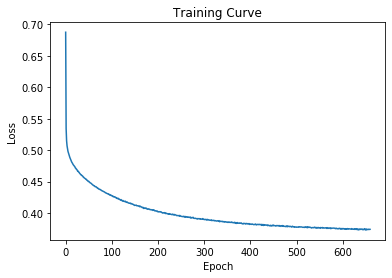

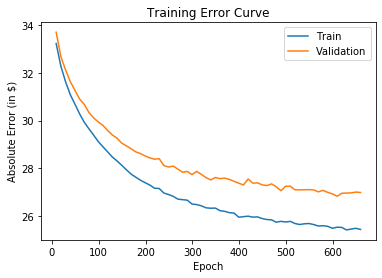

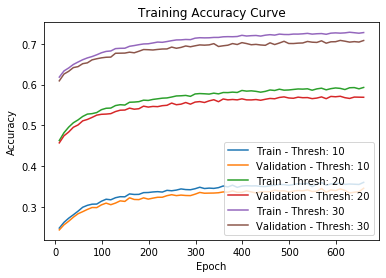

---[ITER 10] loss: 0.376237  time: 5.072
---[ITER 20] loss: 0.376081  time: 5.104
---[ITER 30] loss: 0.376114  time: 4.981
---[ITER 40] loss: 0.371695  time: 5.005
---[ITER 50] loss: 0.370539  time: 4.754
---[ITER 60] loss: 0.373409  time: 4.734
---[ITER 70] loss: 0.382326  time: 6.201
---[ITER 80] loss: 0.372673  time: 7.194
---[ITER 90] loss: 0.368848  time: 4.866
---[ITER 100] loss: 0.371900  time: 4.447
---[ITER 110] loss: 0.366830  time: 7.034
---[ITER 120] loss: 0.380119  time: 5.446
---[ITER 130] loss: 0.372326  time: 8.664
---[ITER 140] loss: 0.375624  time: 6.535
---[ITER 150] loss: 0.375533  time: 6.253
---[ITER 160] loss: 0.369778  time: 7.059
[EPOCH 661] loss: 0.373429  time: 98.215
---[ITER 10] loss: 0.378693  time: 5.240
---[ITER 20] loss: 0.378566  time: 5.389
---[ITER 30] loss: 0.371512  time: 5.843
---[ITER 40] loss: 0.373085  time: 5.382
---[ITER 50] loss: 0.373938  time: 4.817
---[ITER 60] loss: 0.366265  time: 6.362
---[ITER 70] loss: 0.372410  time: 5.407
---[ITER 

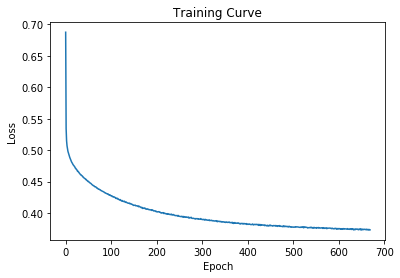

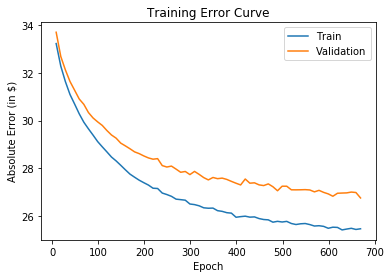

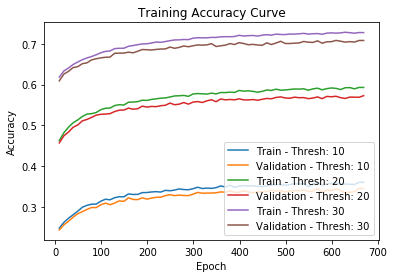

---[ITER 10] loss: 0.374307  time: 5.214
---[ITER 20] loss: 0.372448  time: 4.899
---[ITER 30] loss: 0.372241  time: 4.901
---[ITER 40] loss: 0.373032  time: 4.997
---[ITER 50] loss: 0.376499  time: 4.852
---[ITER 60] loss: 0.374812  time: 5.024
---[ITER 70] loss: 0.375166  time: 4.959
---[ITER 80] loss: 0.373796  time: 4.827
---[ITER 90] loss: 0.375768  time: 4.954
---[ITER 100] loss: 0.368995  time: 5.020
---[ITER 110] loss: 0.376497  time: 4.830
---[ITER 120] loss: 0.374313  time: 4.783
---[ITER 130] loss: 0.372940  time: 4.841
---[ITER 140] loss: 0.370729  time: 4.527
---[ITER 150] loss: 0.374784  time: 4.807
---[ITER 160] loss: 0.369716  time: 4.720
[EPOCH 671] loss: 0.374067  time: 82.043
---[ITER 10] loss: 0.373541  time: 4.801
---[ITER 20] loss: 0.371355  time: 5.071
---[ITER 30] loss: 0.370101  time: 4.656
---[ITER 40] loss: 0.375126  time: 4.913
---[ITER 50] loss: 0.370234  time: 4.977
---[ITER 60] loss: 0.367380  time: 4.705
---[ITER 70] loss: 0.379616  time: 4.654
---[ITER 

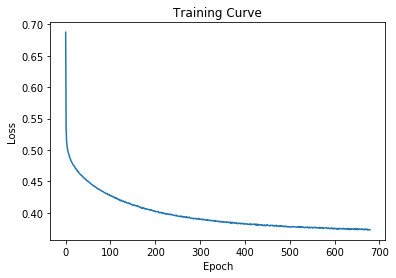

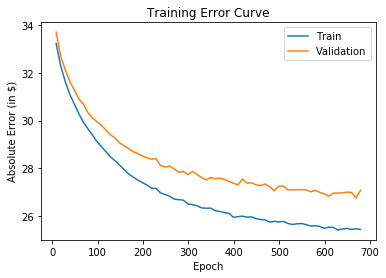

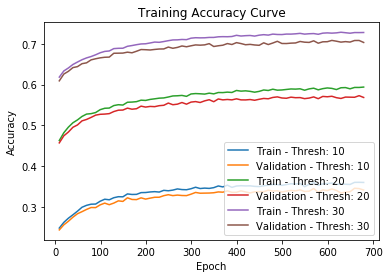

---[ITER 10] loss: 0.378425  time: 4.757
---[ITER 20] loss: 0.368803  time: 4.510
---[ITER 30] loss: 0.371318  time: 4.903
---[ITER 40] loss: 0.373950  time: 4.647
---[ITER 50] loss: 0.372305  time: 4.578
---[ITER 60] loss: 0.375023  time: 4.377
---[ITER 70] loss: 0.367278  time: 4.679
---[ITER 80] loss: 0.364935  time: 4.734
---[ITER 90] loss: 0.371764  time: 4.640
---[ITER 100] loss: 0.365733  time: 4.977
---[ITER 110] loss: 0.376272  time: 4.865
---[ITER 120] loss: 0.377151  time: 4.737
---[ITER 130] loss: 0.376527  time: 4.686
---[ITER 140] loss: 0.380614  time: 4.677
---[ITER 150] loss: 0.375873  time: 4.964
---[ITER 160] loss: 0.381290  time: 4.602
[EPOCH 681] loss: 0.373345  time: 78.957
---[ITER 10] loss: 0.372700  time: 4.651
---[ITER 20] loss: 0.368082  time: 4.696
---[ITER 30] loss: 0.373229  time: 4.519
---[ITER 40] loss: 0.361833  time: 4.596
---[ITER 50] loss: 0.373135  time: 4.752
---[ITER 60] loss: 0.377985  time: 4.615
---[ITER 70] loss: 0.371251  time: 5.032
---[ITER 

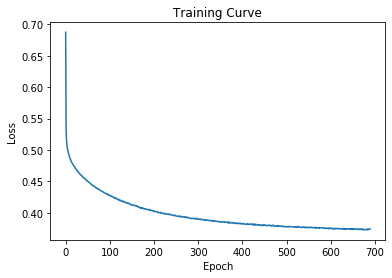

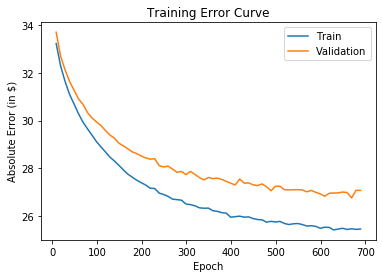

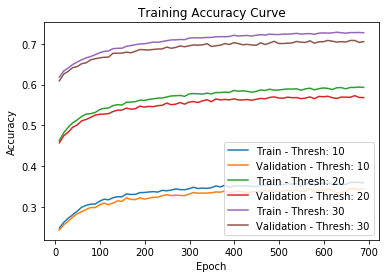

---[ITER 10] loss: 0.378638  time: 4.630
---[ITER 20] loss: 0.368970  time: 4.674
---[ITER 30] loss: 0.368183  time: 4.917
---[ITER 40] loss: 0.364423  time: 4.861
---[ITER 50] loss: 0.375510  time: 4.794
---[ITER 60] loss: 0.373597  time: 4.533
---[ITER 70] loss: 0.379404  time: 5.617
---[ITER 80] loss: 0.370452  time: 4.805
---[ITER 90] loss: 0.364671  time: 4.549
---[ITER 100] loss: 0.380883  time: 4.823
---[ITER 110] loss: 0.372688  time: 4.726
---[ITER 120] loss: 0.367946  time: 4.956
---[ITER 130] loss: 0.371156  time: 4.702
---[ITER 140] loss: 0.372766  time: 4.787
---[ITER 150] loss: 0.377532  time: 5.081
---[ITER 160] loss: 0.378033  time: 4.711
[EPOCH 691] loss: 0.373117  time: 81.110
---[ITER 10] loss: 0.377029  time: 5.022
---[ITER 20] loss: 0.375782  time: 4.684
---[ITER 30] loss: 0.366559  time: 4.624
---[ITER 40] loss: 0.376238  time: 4.720
---[ITER 50] loss: 0.378777  time: 4.835
---[ITER 60] loss: 0.379907  time: 4.888
---[ITER 70] loss: 0.376394  time: 4.911
---[ITER 

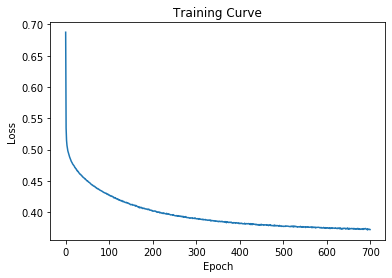

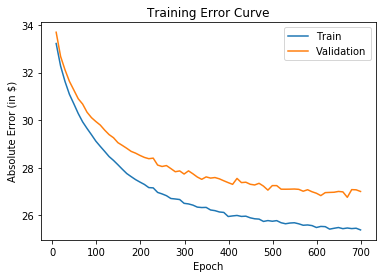

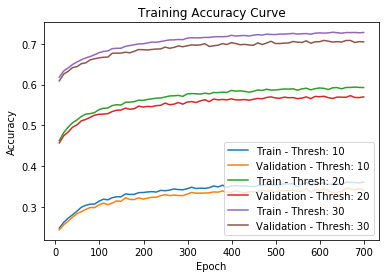

---[ITER 10] loss: 0.364853  time: 4.945
---[ITER 20] loss: 0.376353  time: 4.546
---[ITER 30] loss: 0.368675  time: 4.676
---[ITER 40] loss: 0.374700  time: 4.794
---[ITER 50] loss: 0.381004  time: 4.959
---[ITER 60] loss: 0.375769  time: 5.118
---[ITER 70] loss: 0.374505  time: 4.845
---[ITER 80] loss: 0.371361  time: 4.630
---[ITER 90] loss: 0.380419  time: 4.711
---[ITER 100] loss: 0.369016  time: 4.610
---[ITER 110] loss: 0.369508  time: 4.786
---[ITER 120] loss: 0.377866  time: 4.646
---[ITER 130] loss: 0.379950  time: 4.517
---[ITER 140] loss: 0.364701  time: 4.821
---[ITER 150] loss: 0.371006  time: 4.601
---[ITER 160] loss: 0.366687  time: 4.707
[EPOCH 701] loss: 0.372393  time: 79.554
---[ITER 10] loss: 0.369681  time: 4.940
---[ITER 20] loss: 0.379320  time: 5.185
---[ITER 30] loss: 0.371871  time: 4.747
---[ITER 40] loss: 0.378964  time: 4.715
---[ITER 50] loss: 0.367823  time: 4.822
---[ITER 60] loss: 0.372957  time: 5.029
---[ITER 70] loss: 0.372722  time: 4.663
---[ITER 

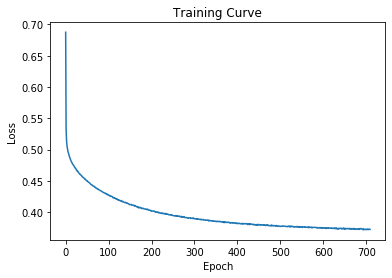

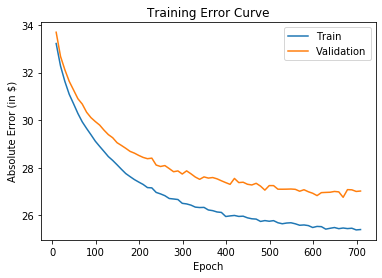

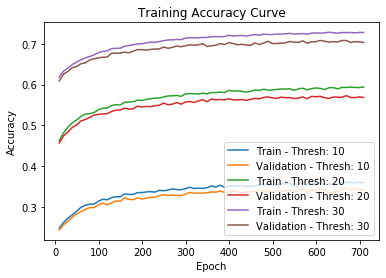

---[ITER 10] loss: 0.370428  time: 4.576
---[ITER 20] loss: 0.366358  time: 4.525
---[ITER 30] loss: 0.372229  time: 4.729
---[ITER 40] loss: 0.375791  time: 4.636
---[ITER 50] loss: 0.370779  time: 4.446
---[ITER 60] loss: 0.376032  time: 4.298
---[ITER 70] loss: 0.377114  time: 4.397
---[ITER 80] loss: 0.367157  time: 4.491
---[ITER 90] loss: 0.367572  time: 4.804
---[ITER 100] loss: 0.372047  time: 4.661
---[ITER 110] loss: 0.368094  time: 5.235
---[ITER 120] loss: 0.373343  time: 4.797
---[ITER 130] loss: 0.380846  time: 4.485
---[ITER 140] loss: 0.377223  time: 4.807
---[ITER 150] loss: 0.376411  time: 4.916
---[ITER 160] loss: 0.373798  time: 4.912
[EPOCH 711] loss: 0.372597  time: 78.232
---[ITER 10] loss: 0.373578  time: 4.674
---[ITER 20] loss: 0.372391  time: 4.644
---[ITER 30] loss: 0.367515  time: 4.730
---[ITER 40] loss: 0.367248  time: 4.710
---[ITER 50] loss: 0.365674  time: 4.756
---[ITER 60] loss: 0.373052  time: 4.894
---[ITER 70] loss: 0.366822  time: 5.015
---[ITER 

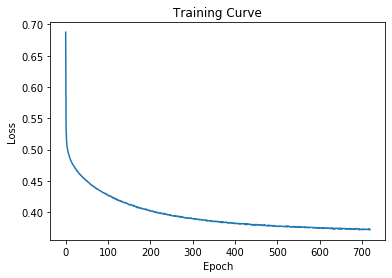

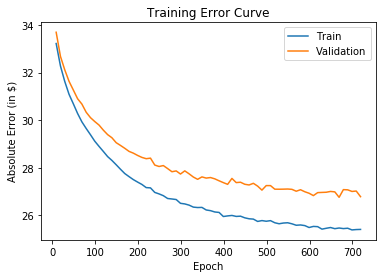

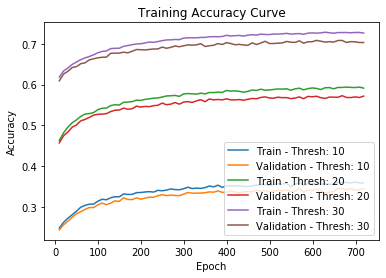

---[ITER 10] loss: 0.364734  time: 3.980
---[ITER 20] loss: 0.368130  time: 3.828
---[ITER 30] loss: 0.371031  time: 3.970
---[ITER 40] loss: 0.370536  time: 3.535
---[ITER 50] loss: 0.372539  time: 3.616
---[ITER 60] loss: 0.374575  time: 3.877
---[ITER 70] loss: 0.369303  time: 3.870
---[ITER 80] loss: 0.378101  time: 3.882
---[ITER 90] loss: 0.375450  time: 3.879
---[ITER 100] loss: 0.370921  time: 3.969
---[ITER 110] loss: 0.377885  time: 3.924
---[ITER 120] loss: 0.377381  time: 3.907
---[ITER 130] loss: 0.366933  time: 3.425
---[ITER 140] loss: 0.372997  time: 3.889
---[ITER 150] loss: 0.375047  time: 3.817
---[ITER 160] loss: 0.367162  time: 3.832
[EPOCH 721] loss: 0.372418  time: 64.293
---[ITER 10] loss: 0.374291  time: 3.830
---[ITER 20] loss: 0.363371  time: 3.766
---[ITER 30] loss: 0.370183  time: 3.917
---[ITER 40] loss: 0.368407  time: 3.410
---[ITER 50] loss: 0.378992  time: 3.686
---[ITER 60] loss: 0.373845  time: 3.749
---[ITER 70] loss: 0.365600  time: 3.785
---[ITER 

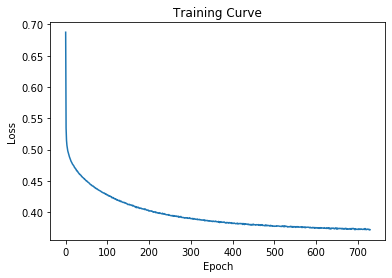

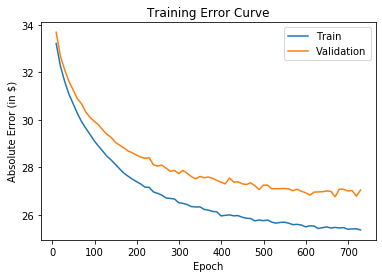

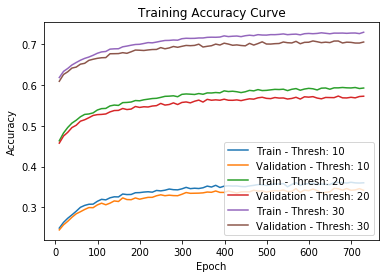

---[ITER 10] loss: 0.373737  time: 3.985
---[ITER 20] loss: 0.370095  time: 3.373
---[ITER 30] loss: 0.376113  time: 4.168
---[ITER 40] loss: 0.372343  time: 3.885
---[ITER 50] loss: 0.368126  time: 3.815
---[ITER 60] loss: 0.369226  time: 3.875
---[ITER 70] loss: 0.371904  time: 4.147
---[ITER 80] loss: 0.377709  time: 3.835
---[ITER 90] loss: 0.359771  time: 4.020
---[ITER 100] loss: 0.375372  time: 3.655
---[ITER 110] loss: 0.367064  time: 3.708
---[ITER 120] loss: 0.372802  time: 3.915
---[ITER 130] loss: 0.380393  time: 3.980
---[ITER 140] loss: 0.372181  time: 3.920
---[ITER 150] loss: 0.369836  time: 4.054
---[ITER 160] loss: 0.375971  time: 3.953
[EPOCH 731] loss: 0.372073  time: 65.283
---[ITER 10] loss: 0.371125  time: 3.864
---[ITER 20] loss: 0.372617  time: 3.378
---[ITER 30] loss: 0.364605  time: 3.757
---[ITER 40] loss: 0.378579  time: 3.881
---[ITER 50] loss: 0.371405  time: 3.871
---[ITER 60] loss: 0.372992  time: 3.832
---[ITER 70] loss: 0.370912  time: 3.899
---[ITER 

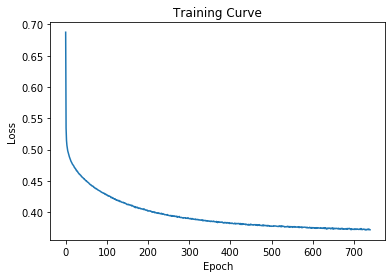

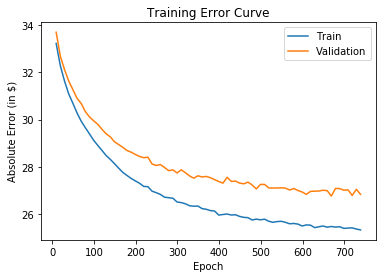

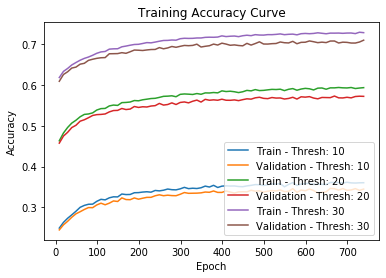

---[ITER 10] loss: 0.373896  time: 3.759
---[ITER 20] loss: 0.368185  time: 3.798
---[ITER 30] loss: 0.369953  time: 3.903
---[ITER 40] loss: 0.371218  time: 3.728
---[ITER 50] loss: 0.373542  time: 3.823
---[ITER 60] loss: 0.379721  time: 3.690
---[ITER 70] loss: 0.374188  time: 3.786
---[ITER 80] loss: 0.369535  time: 3.458
---[ITER 90] loss: 0.369587  time: 3.431
---[ITER 100] loss: 0.370066  time: 3.889
---[ITER 110] loss: 0.371608  time: 3.795
---[ITER 120] loss: 0.371358  time: 3.862
---[ITER 130] loss: 0.373191  time: 4.031
---[ITER 140] loss: 0.371359  time: 3.816
---[ITER 150] loss: 0.365372  time: 3.804
---[ITER 160] loss: 0.367004  time: 3.624
[EPOCH 741] loss: 0.370872  time: 62.685
---[ITER 10] loss: 0.367643  time: 3.635
---[ITER 20] loss: 0.372029  time: 3.855
---[ITER 30] loss: 0.369147  time: 3.711
---[ITER 40] loss: 0.367238  time: 3.786
---[ITER 50] loss: 0.375064  time: 4.014
---[ITER 60] loss: 0.370633  time: 3.948
---[ITER 70] loss: 0.374255  time: 3.813
---[ITER 

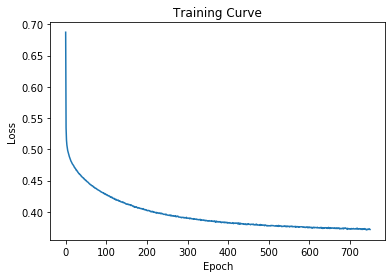

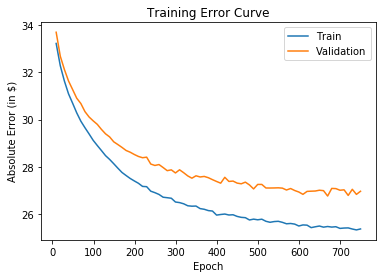

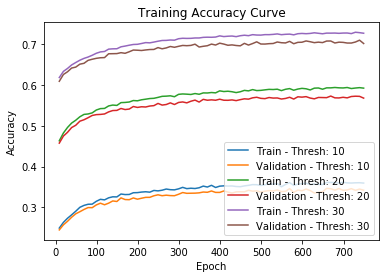

---[ITER 10] loss: 0.370472  time: 3.972
---[ITER 20] loss: 0.373526  time: 3.909
---[ITER 30] loss: 0.369205  time: 4.196
---[ITER 40] loss: 0.372664  time: 4.126
---[ITER 50] loss: 0.370119  time: 4.328
---[ITER 60] loss: 0.369005  time: 4.055
---[ITER 70] loss: 0.366652  time: 3.591
---[ITER 80] loss: 0.372896  time: 3.992
---[ITER 90] loss: 0.373991  time: 3.940
---[ITER 100] loss: 0.373028  time: 3.848
---[ITER 110] loss: 0.370728  time: 4.018
---[ITER 120] loss: 0.380193  time: 4.072
---[ITER 130] loss: 0.373211  time: 4.250
---[ITER 140] loss: 0.369876  time: 4.180
---[ITER 150] loss: 0.362841  time: 3.448
---[ITER 160] loss: 0.366719  time: 4.126
[EPOCH 751] loss: 0.371357  time: 67.224
---[ITER 10] loss: 0.365957  time: 4.161
---[ITER 20] loss: 0.377024  time: 4.121
---[ITER 30] loss: 0.366689  time: 4.148
---[ITER 40] loss: 0.373632  time: 4.176
---[ITER 50] loss: 0.366073  time: 4.551
---[ITER 60] loss: 0.377975  time: 3.943
---[ITER 70] loss: 0.367866  time: 3.507
---[ITER 

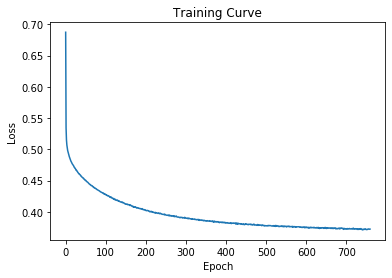

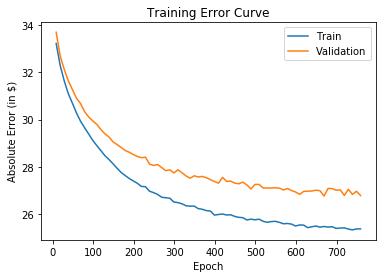

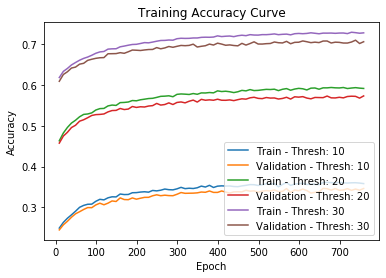

---[ITER 10] loss: 0.376785  time: 3.700
---[ITER 20] loss: 0.371258  time: 3.706
---[ITER 30] loss: 0.374362  time: 3.796
---[ITER 40] loss: 0.370319  time: 3.627
---[ITER 50] loss: 0.367102  time: 3.348
---[ITER 60] loss: 0.376036  time: 3.819
---[ITER 70] loss: 0.372340  time: 3.922
---[ITER 80] loss: 0.374766  time: 3.737
---[ITER 90] loss: 0.370160  time: 3.790
---[ITER 100] loss: 0.369370  time: 3.677
---[ITER 110] loss: 0.373999  time: 3.743
---[ITER 120] loss: 0.370898  time: 3.672
---[ITER 130] loss: 0.365155  time: 3.375
---[ITER 140] loss: 0.371892  time: 3.567
---[ITER 150] loss: 0.370636  time: 3.751
---[ITER 160] loss: 0.370433  time: 3.666
[EPOCH 761] loss: 0.371855  time: 61.713
---[ITER 10] loss: 0.370936  time: 3.788
---[ITER 20] loss: 0.369913  time: 3.742
---[ITER 30] loss: 0.375560  time: 3.616
---[ITER 40] loss: 0.374563  time: 3.757
---[ITER 50] loss: 0.370565  time: 3.363
---[ITER 60] loss: 0.362613  time: 3.764
---[ITER 70] loss: 0.372401  time: 4.201
---[ITER 

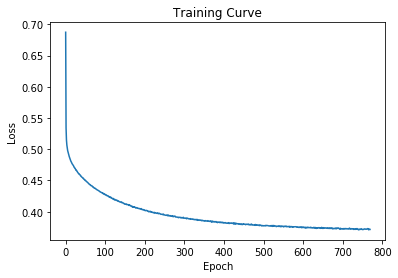

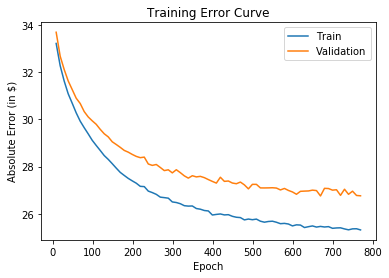

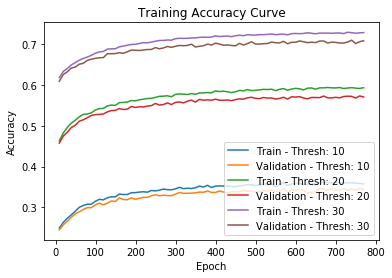

---[ITER 10] loss: 0.372653  time: 2.972
---[ITER 20] loss: 0.371032  time: 3.224
---[ITER 30] loss: 0.368334  time: 3.029
---[ITER 40] loss: 0.362746  time: 2.922
---[ITER 50] loss: 0.370585  time: 2.823
---[ITER 60] loss: 0.366313  time: 2.851
---[ITER 70] loss: 0.370165  time: 2.744
---[ITER 80] loss: 0.373088  time: 2.798
---[ITER 90] loss: 0.371150  time: 2.858
---[ITER 100] loss: 0.377123  time: 2.851
---[ITER 110] loss: 0.378159  time: 2.790
---[ITER 120] loss: 0.378430  time: 2.781
---[ITER 130] loss: 0.368570  time: 2.840
---[ITER 140] loss: 0.374137  time: 2.901
---[ITER 150] loss: 0.376373  time: 3.126
---[ITER 160] loss: 0.366680  time: 3.128
[EPOCH 771] loss: 0.371542  time: 48.827
---[ITER 10] loss: 0.368725  time: 2.750
---[ITER 20] loss: 0.366097  time: 2.882
---[ITER 30] loss: 0.367940  time: 2.760
---[ITER 40] loss: 0.370584  time: 2.894
---[ITER 50] loss: 0.370548  time: 2.777
---[ITER 60] loss: 0.369213  time: 2.729
---[ITER 70] loss: 0.374817  time: 2.809
---[ITER 

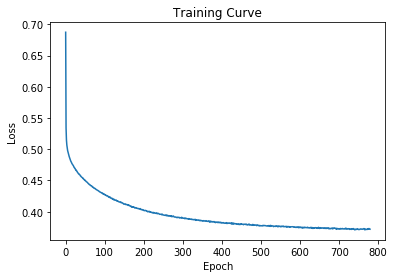

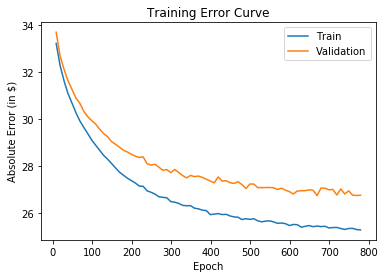

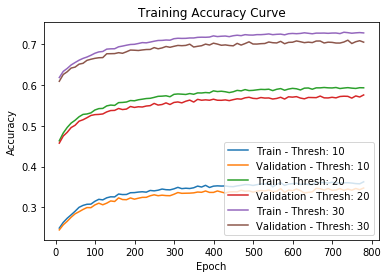

---[ITER 10] loss: 0.370862  time: 2.586
---[ITER 20] loss: 0.374288  time: 2.563
---[ITER 30] loss: 0.379512  time: 2.560
---[ITER 40] loss: 0.372324  time: 2.561
---[ITER 50] loss: 0.375720  time: 2.552
---[ITER 60] loss: 0.374242  time: 2.552
---[ITER 70] loss: 0.370098  time: 2.543
---[ITER 80] loss: 0.366134  time: 2.568
---[ITER 90] loss: 0.375207  time: 2.571
---[ITER 100] loss: 0.374552  time: 2.571
---[ITER 110] loss: 0.370056  time: 2.665
---[ITER 120] loss: 0.370021  time: 2.576
---[ITER 130] loss: 0.369171  time: 2.598
---[ITER 140] loss: 0.369878  time: 2.639
---[ITER 150] loss: 0.370858  time: 2.717
---[ITER 160] loss: 0.364421  time: 2.558
[EPOCH 781] loss: 0.371628  time: 43.340
---[ITER 10] loss: 0.371980  time: 2.549
---[ITER 20] loss: 0.367518  time: 2.728
---[ITER 30] loss: 0.371787  time: 2.532
---[ITER 40] loss: 0.376324  time: 2.525
---[ITER 50] loss: 0.370293  time: 2.684
---[ITER 60] loss: 0.371245  time: 2.577
---[ITER 70] loss: 0.359418  time: 2.528
---[ITER 

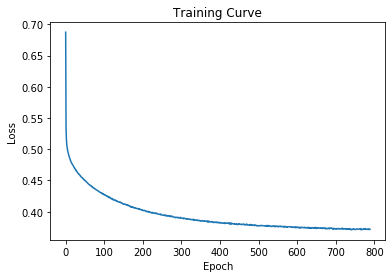

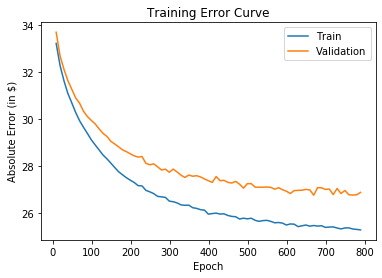

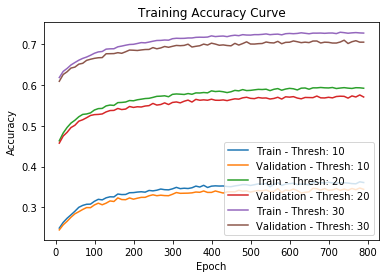

---[ITER 10] loss: 0.370091  time: 2.686
---[ITER 20] loss: 0.372122  time: 2.547
---[ITER 30] loss: 0.379270  time: 2.599
---[ITER 40] loss: 0.373116  time: 2.532
---[ITER 50] loss: 0.374096  time: 2.526
---[ITER 60] loss: 0.375841  time: 2.547
---[ITER 70] loss: 0.376416  time: 2.538
---[ITER 80] loss: 0.369430  time: 2.520
---[ITER 90] loss: 0.371738  time: 2.556
---[ITER 100] loss: 0.371545  time: 2.564
---[ITER 110] loss: 0.364888  time: 2.568
---[ITER 120] loss: 0.368227  time: 2.531
---[ITER 130] loss: 0.374927  time: 2.553
---[ITER 140] loss: 0.372297  time: 2.602
---[ITER 150] loss: 0.374900  time: 2.535
---[ITER 160] loss: 0.366173  time: 2.598
[EPOCH 791] loss: 0.371918  time: 43.019
---[ITER 10] loss: 0.371863  time: 2.808
---[ITER 20] loss: 0.366497  time: 2.592
---[ITER 30] loss: 0.375194  time: 2.842
---[ITER 40] loss: 0.374457  time: 2.540
---[ITER 50] loss: 0.371405  time: 2.533
---[ITER 60] loss: 0.367965  time: 2.595
---[ITER 70] loss: 0.369350  time: 2.532
---[ITER 

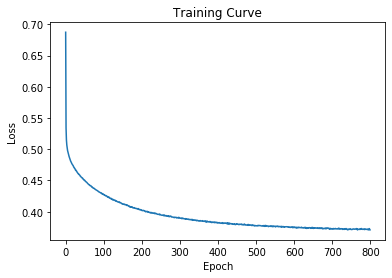

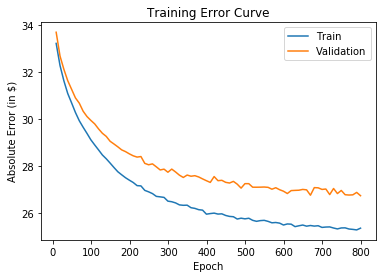

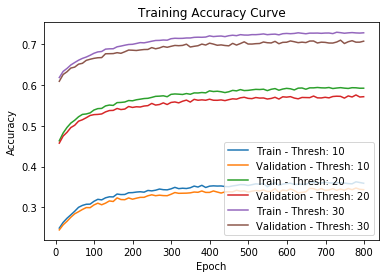

---[ITER 10] loss: 0.365755  time: 2.654
---[ITER 20] loss: 0.365999  time: 2.561
---[ITER 30] loss: 0.370310  time: 2.607
---[ITER 40] loss: 0.372031  time: 2.537
---[ITER 50] loss: 0.379658  time: 2.554
---[ITER 60] loss: 0.372554  time: 2.574
---[ITER 70] loss: 0.366501  time: 2.559
---[ITER 80] loss: 0.375958  time: 2.600
---[ITER 90] loss: 0.373571  time: 2.581
---[ITER 100] loss: 0.371870  time: 2.576
---[ITER 110] loss: 0.367751  time: 2.544
---[ITER 120] loss: 0.374653  time: 2.576
---[ITER 130] loss: 0.365784  time: 2.589
---[ITER 140] loss: 0.366801  time: 2.635
---[ITER 150] loss: 0.374486  time: 2.631
---[ITER 160] loss: 0.371723  time: 2.679
[EPOCH 801] loss: 0.371261  time: 43.492
---[ITER 10] loss: 0.366543  time: 2.629
---[ITER 20] loss: 0.370037  time: 2.629
---[ITER 30] loss: 0.374937  time: 2.978
---[ITER 40] loss: 0.375227  time: 2.652
---[ITER 50] loss: 0.368810  time: 2.605
---[ITER 60] loss: 0.374809  time: 2.681
---[ITER 70] loss: 0.371189  time: 2.588
---[ITER 

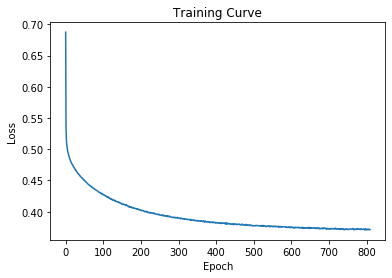

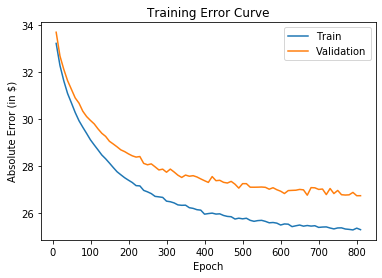

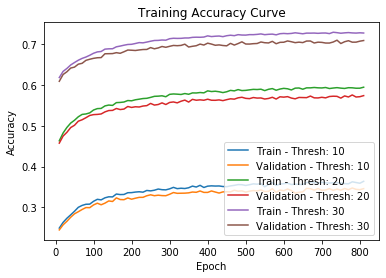

---[ITER 10] loss: 0.375187  time: 2.651
---[ITER 20] loss: 0.369289  time: 3.028
---[ITER 30] loss: 0.371569  time: 2.970
---[ITER 40] loss: 0.377401  time: 2.783
---[ITER 50] loss: 0.373915  time: 2.896
---[ITER 60] loss: 0.370417  time: 2.865
---[ITER 70] loss: 0.368987  time: 2.582
---[ITER 80] loss: 0.374461  time: 2.862
---[ITER 90] loss: 0.371479  time: 2.721
---[ITER 100] loss: 0.368326  time: 2.830
---[ITER 110] loss: 0.365716  time: 2.839
---[ITER 120] loss: 0.362105  time: 2.886
---[ITER 130] loss: 0.376383  time: 2.965
---[ITER 140] loss: 0.374749  time: 2.950
---[ITER 150] loss: 0.365338  time: 2.755
---[ITER 160] loss: 0.368582  time: 2.977
[EPOCH 811] loss: 0.370770  time: 47.765
---[ITER 10] loss: 0.373823  time: 2.817
---[ITER 20] loss: 0.365273  time: 2.768
---[ITER 30] loss: 0.375581  time: 2.833
---[ITER 40] loss: 0.372998  time: 2.837
---[ITER 50] loss: 0.374296  time: 2.703
---[ITER 60] loss: 0.367928  time: 2.725
---[ITER 70] loss: 0.367063  time: 2.702
---[ITER 

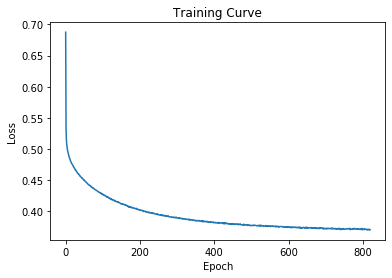

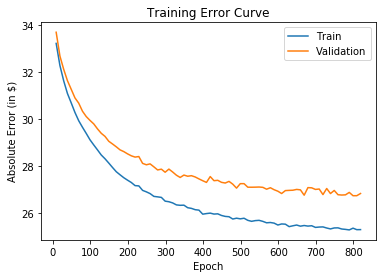

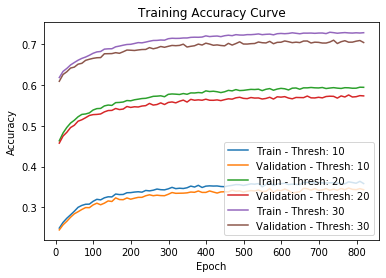

---[ITER 10] loss: 0.371781  time: 2.726
---[ITER 20] loss: 0.372123  time: 2.786
---[ITER 30] loss: 0.373684  time: 2.829
---[ITER 40] loss: 0.366433  time: 2.671
---[ITER 50] loss: 0.370769  time: 2.640
---[ITER 60] loss: 0.376145  time: 3.111
---[ITER 70] loss: 0.374308  time: 2.764
---[ITER 80] loss: 0.367348  time: 2.720
---[ITER 90] loss: 0.367840  time: 2.687
---[ITER 100] loss: 0.361918  time: 2.704
---[ITER 110] loss: 0.367913  time: 2.567
---[ITER 120] loss: 0.370151  time: 2.662
---[ITER 130] loss: 0.371172  time: 2.678
---[ITER 140] loss: 0.363923  time: 2.706
---[ITER 150] loss: 0.371184  time: 2.662
---[ITER 160] loss: 0.375381  time: 2.675
[EPOCH 821] loss: 0.370308  time: 45.678
---[ITER 10] loss: 0.362419  time: 2.755
---[ITER 20] loss: 0.380472  time: 2.737
---[ITER 30] loss: 0.375677  time: 2.773
---[ITER 40] loss: 0.362211  time: 2.693
---[ITER 50] loss: 0.368244  time: 2.655
---[ITER 60] loss: 0.366668  time: 2.733
---[ITER 70] loss: 0.370635  time: 2.720
---[ITER 

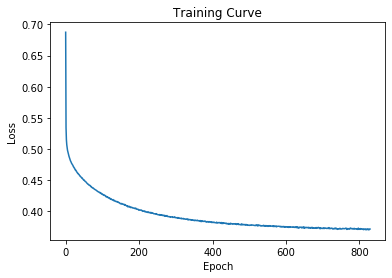

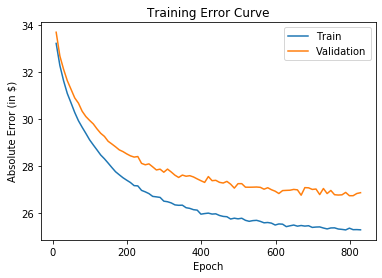

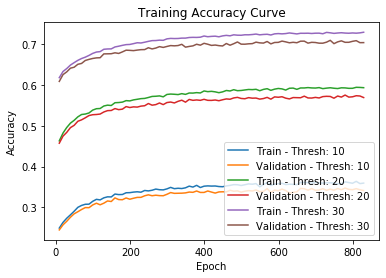

---[ITER 10] loss: 0.373284  time: 2.702
---[ITER 20] loss: 0.372590  time: 2.751
---[ITER 30] loss: 0.365354  time: 2.895
---[ITER 40] loss: 0.366972  time: 2.642
---[ITER 50] loss: 0.378013  time: 2.835
---[ITER 60] loss: 0.375688  time: 2.706
---[ITER 70] loss: 0.367621  time: 2.656
---[ITER 80] loss: 0.367870  time: 2.658
---[ITER 90] loss: 0.367991  time: 2.701
---[ITER 100] loss: 0.376360  time: 2.631
---[ITER 110] loss: 0.373004  time: 2.656
---[ITER 120] loss: 0.372181  time: 2.720
---[ITER 130] loss: 0.366574  time: 2.693
---[ITER 140] loss: 0.366320  time: 2.750
---[ITER 150] loss: 0.373669  time: 2.767
---[ITER 160] loss: 0.369536  time: 2.709
[EPOCH 831] loss: 0.370976  time: 45.597
---[ITER 10] loss: 0.373881  time: 2.769
---[ITER 20] loss: 0.375419  time: 2.679
---[ITER 30] loss: 0.370855  time: 2.738
---[ITER 40] loss: 0.377893  time: 2.693
---[ITER 50] loss: 0.369566  time: 2.608
---[ITER 60] loss: 0.370386  time: 2.611
---[ITER 70] loss: 0.371255  time: 2.775
---[ITER 

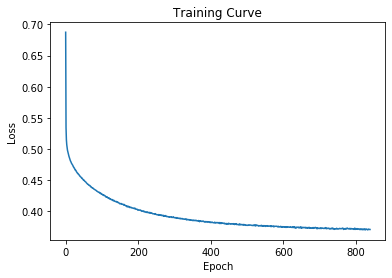

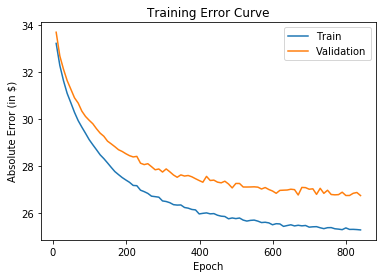

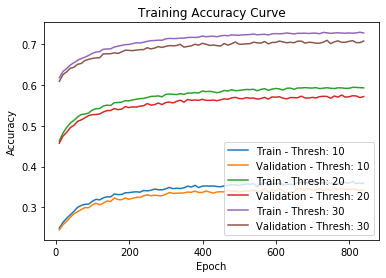

---[ITER 10] loss: 0.364306  time: 2.666
---[ITER 20] loss: 0.362597  time: 2.734
---[ITER 30] loss: 0.368804  time: 2.813
---[ITER 40] loss: 0.366592  time: 2.553
---[ITER 50] loss: 0.371208  time: 2.680
---[ITER 60] loss: 0.375711  time: 2.664
---[ITER 70] loss: 0.371664  time: 2.615
---[ITER 80] loss: 0.370592  time: 2.622
---[ITER 90] loss: 0.373297  time: 2.665
---[ITER 100] loss: 0.377579  time: 2.600
---[ITER 110] loss: 0.366886  time: 2.594
---[ITER 120] loss: 0.368874  time: 2.663
---[ITER 130] loss: 0.379400  time: 2.583
---[ITER 140] loss: 0.369384  time: 2.663
---[ITER 150] loss: 0.369991  time: 2.622
---[ITER 160] loss: 0.377278  time: 2.629
[EPOCH 841] loss: 0.370850  time: 44.441
---[ITER 10] loss: 0.370062  time: 2.655
---[ITER 20] loss: 0.368702  time: 2.709
---[ITER 30] loss: 0.375897  time: 2.678
---[ITER 40] loss: 0.368437  time: 2.647
---[ITER 50] loss: 0.380377  time: 2.687
---[ITER 60] loss: 0.366447  time: 2.710
---[ITER 70] loss: 0.373311  time: 2.684
---[ITER 

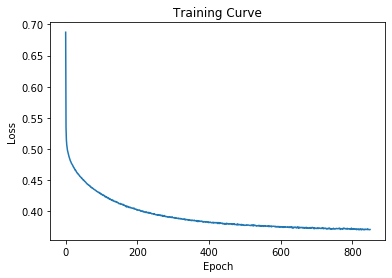

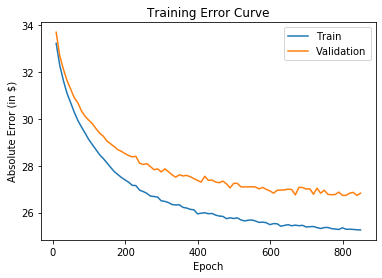

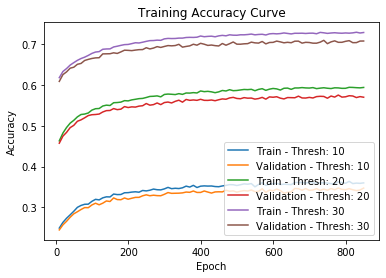

---[ITER 10] loss: 0.366600  time: 2.748
---[ITER 20] loss: 0.372444  time: 2.693
---[ITER 30] loss: 0.362452  time: 2.740
---[ITER 40] loss: 0.375918  time: 2.806
---[ITER 50] loss: 0.370149  time: 2.822
---[ITER 60] loss: 0.366267  time: 2.862
---[ITER 70] loss: 0.370098  time: 2.901
---[ITER 80] loss: 0.366874  time: 2.852
---[ITER 90] loss: 0.366269  time: 2.848
---[ITER 100] loss: 0.372604  time: 2.786
---[ITER 110] loss: 0.368965  time: 2.773
---[ITER 120] loss: 0.376886  time: 2.913
---[ITER 130] loss: 0.367842  time: 2.803
---[ITER 140] loss: 0.373420  time: 2.920
---[ITER 150] loss: 0.365491  time: 2.978
---[ITER 160] loss: 0.379792  time: 2.923
[EPOCH 851] loss: 0.370248  time: 47.578
---[ITER 10] loss: 0.372130  time: 2.863
---[ITER 20] loss: 0.370346  time: 2.812
---[ITER 30] loss: 0.369976  time: 2.857
---[ITER 40] loss: 0.362851  time: 2.754
---[ITER 50] loss: 0.365939  time: 2.713
---[ITER 60] loss: 0.372225  time: 2.719
---[ITER 70] loss: 0.370283  time: 2.830
---[ITER 

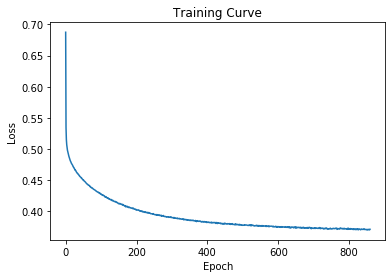

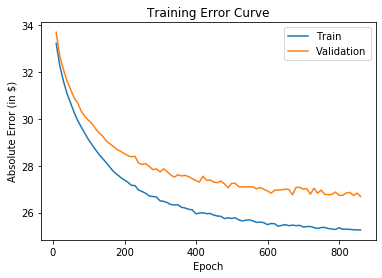

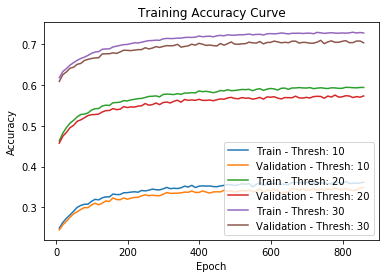

---[ITER 10] loss: 0.369682  time: 2.697
---[ITER 20] loss: 0.371466  time: 2.737
---[ITER 30] loss: 0.367214  time: 2.710
---[ITER 40] loss: 0.363255  time: 2.702
---[ITER 50] loss: 0.369844  time: 2.740
---[ITER 60] loss: 0.373168  time: 2.804
---[ITER 70] loss: 0.371964  time: 2.681
---[ITER 80] loss: 0.366803  time: 2.786
---[ITER 90] loss: 0.366286  time: 2.725
---[ITER 100] loss: 0.370906  time: 2.710
---[ITER 110] loss: 0.370907  time: 2.708
---[ITER 120] loss: 0.374029  time: 2.683
---[ITER 130] loss: 0.378212  time: 2.710
---[ITER 140] loss: 0.369761  time: 2.760
---[ITER 150] loss: 0.374676  time: 2.746
---[ITER 160] loss: 0.374518  time: 2.738
[EPOCH 861] loss: 0.370448  time: 45.734
---[ITER 10] loss: 0.368438  time: 2.747
---[ITER 20] loss: 0.365686  time: 2.878
---[ITER 30] loss: 0.366266  time: 2.694
---[ITER 40] loss: 0.375171  time: 2.696
---[ITER 50] loss: 0.369625  time: 2.673
---[ITER 60] loss: 0.368975  time: 2.726
---[ITER 70] loss: 0.372528  time: 2.686
---[ITER 

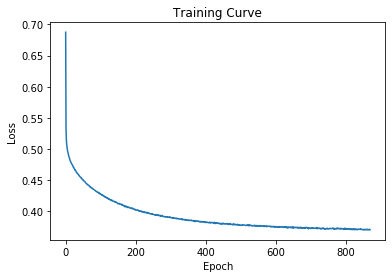

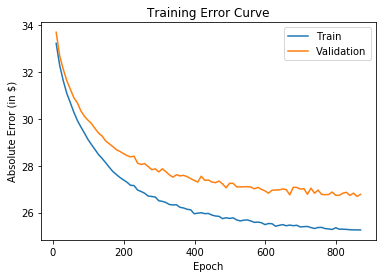

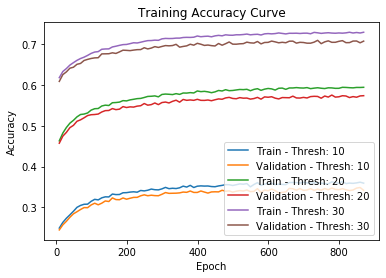

---[ITER 10] loss: 0.372262  time: 2.699
---[ITER 20] loss: 0.363749  time: 2.856
---[ITER 30] loss: 0.373239  time: 2.715
---[ITER 40] loss: 0.370654  time: 2.645
---[ITER 50] loss: 0.362716  time: 2.715
---[ITER 60] loss: 0.375269  time: 2.687
---[ITER 70] loss: 0.374049  time: 2.676
---[ITER 80] loss: 0.364073  time: 2.674
---[ITER 90] loss: 0.372622  time: 2.681
---[ITER 100] loss: 0.364562  time: 2.687
---[ITER 110] loss: 0.374109  time: 2.851
---[ITER 120] loss: 0.370149  time: 2.732
---[ITER 130] loss: 0.372983  time: 2.628
---[ITER 140] loss: 0.374018  time: 2.804
---[ITER 150] loss: 0.374406  time: 2.704
---[ITER 160] loss: 0.373319  time: 2.694
[EPOCH 871] loss: 0.370549  time: 45.522
---[ITER 10] loss: 0.367640  time: 2.691
---[ITER 20] loss: 0.363120  time: 2.722
---[ITER 30] loss: 0.374763  time: 2.664
---[ITER 40] loss: 0.364322  time: 2.698
---[ITER 50] loss: 0.369000  time: 2.749
---[ITER 60] loss: 0.376002  time: 2.684
---[ITER 70] loss: 0.368584  time: 2.720
---[ITER 

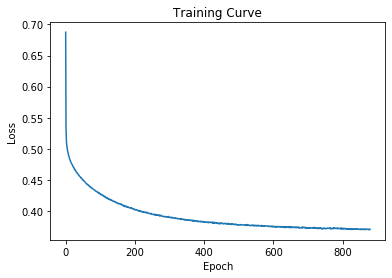

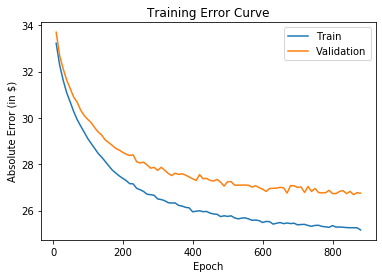

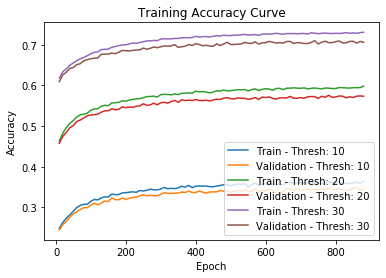

---[ITER 10] loss: 0.367900  time: 2.680
---[ITER 20] loss: 0.364744  time: 2.704
---[ITER 30] loss: 0.367961  time: 2.912
---[ITER 40] loss: 0.365536  time: 2.719
---[ITER 50] loss: 0.369217  time: 2.709
---[ITER 60] loss: 0.363479  time: 2.809
---[ITER 70] loss: 0.368882  time: 2.716
---[ITER 80] loss: 0.368180  time: 2.656
---[ITER 90] loss: 0.383313  time: 2.648
---[ITER 100] loss: 0.370008  time: 2.707
---[ITER 110] loss: 0.363680  time: 2.705
---[ITER 120] loss: 0.373028  time: 2.674
---[ITER 130] loss: 0.364639  time: 2.729
---[ITER 140] loss: 0.380039  time: 2.737
---[ITER 150] loss: 0.373233  time: 2.747
---[ITER 160] loss: 0.379521  time: 2.766
[EPOCH 881] loss: 0.370163  time: 45.690
---[ITER 10] loss: 0.365815  time: 2.773
---[ITER 20] loss: 0.373531  time: 2.804
---[ITER 30] loss: 0.374365  time: 2.731
---[ITER 40] loss: 0.361947  time: 2.730
---[ITER 50] loss: 0.370737  time: 2.673
---[ITER 60] loss: 0.367962  time: 2.695
---[ITER 70] loss: 0.376623  time: 2.723
---[ITER 

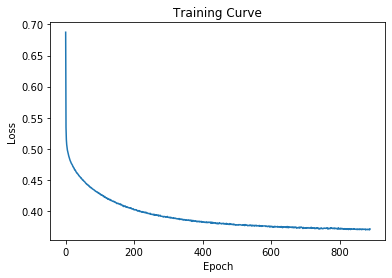

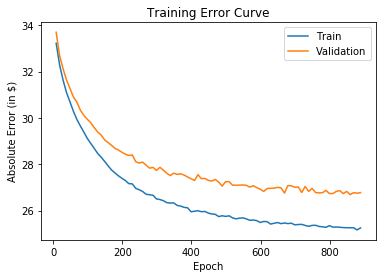

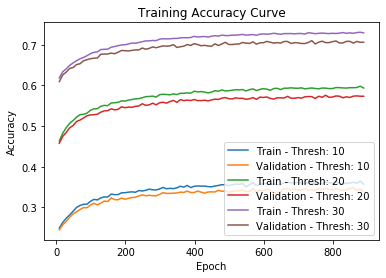

---[ITER 10] loss: 0.376863  time: 2.751
---[ITER 20] loss: 0.367799  time: 2.687
---[ITER 30] loss: 0.367662  time: 2.712
---[ITER 40] loss: 0.370714  time: 2.686
---[ITER 50] loss: 0.365380  time: 2.738
---[ITER 60] loss: 0.362324  time: 2.681
---[ITER 70] loss: 0.379239  time: 2.698
---[ITER 80] loss: 0.370352  time: 2.703
---[ITER 90] loss: 0.370707  time: 2.855
---[ITER 100] loss: 0.363685  time: 2.712
---[ITER 110] loss: 0.370484  time: 2.689
---[ITER 120] loss: 0.374615  time: 2.895
---[ITER 130] loss: 0.373884  time: 2.706
---[ITER 140] loss: 0.371809  time: 2.712
---[ITER 150] loss: 0.368561  time: 2.693
---[ITER 160] loss: 0.358357  time: 2.706
[EPOCH 891] loss: 0.369605  time: 45.688
---[ITER 10] loss: 0.373889  time: 2.703
---[ITER 20] loss: 0.369413  time: 2.772
---[ITER 30] loss: 0.370570  time: 2.681
---[ITER 40] loss: 0.362759  time: 2.721
---[ITER 50] loss: 0.368428  time: 2.695
---[ITER 60] loss: 0.371696  time: 2.717
---[ITER 70] loss: 0.366372  time: 2.687
---[ITER 

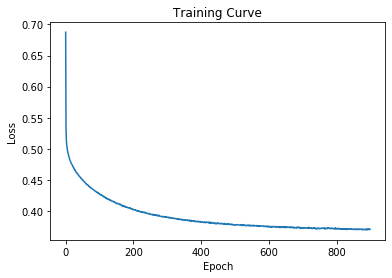

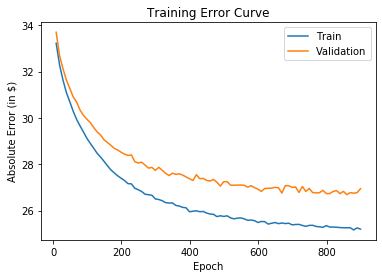

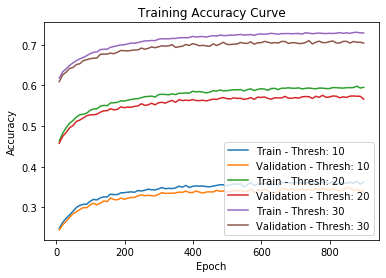

---[ITER 10] loss: 0.373366  time: 2.840
---[ITER 20] loss: 0.365378  time: 2.846
---[ITER 30] loss: 0.369093  time: 2.817
---[ITER 40] loss: 0.378133  time: 2.806
---[ITER 50] loss: 0.369722  time: 2.961
---[ITER 60] loss: 0.376554  time: 2.687
---[ITER 70] loss: 0.370035  time: 2.760
---[ITER 80] loss: 0.373733  time: 2.715
---[ITER 90] loss: 0.362522  time: 2.800
---[ITER 100] loss: 0.373494  time: 2.751
---[ITER 110] loss: 0.372023  time: 2.786
---[ITER 120] loss: 0.362710  time: 2.732
---[ITER 130] loss: 0.367792  time: 2.732
---[ITER 140] loss: 0.369257  time: 3.005
---[ITER 150] loss: 0.372986  time: 2.706
---[ITER 160] loss: 0.367178  time: 2.650
[EPOCH 901] loss: 0.370222  time: 46.710
---[ITER 10] loss: 0.368203  time: 2.698
---[ITER 20] loss: 0.376252  time: 2.647
---[ITER 30] loss: 0.369322  time: 2.649
---[ITER 40] loss: 0.371133  time: 2.653
---[ITER 50] loss: 0.363317  time: 2.554
---[ITER 60] loss: 0.376053  time: 2.679
---[ITER 70] loss: 0.365397  time: 2.728
---[ITER 

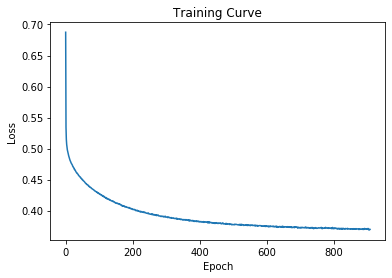

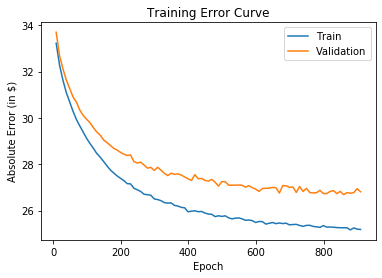

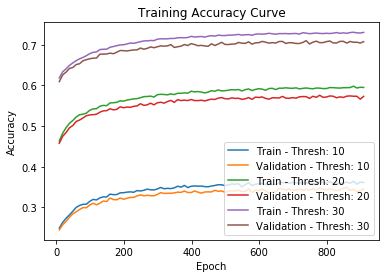

---[ITER 10] loss: 0.378095  time: 2.831
---[ITER 20] loss: 0.373677  time: 2.807
---[ITER 30] loss: 0.362253  time: 2.830
---[ITER 40] loss: 0.360589  time: 2.803
---[ITER 50] loss: 0.374119  time: 2.799
---[ITER 60] loss: 0.371928  time: 2.762
---[ITER 70] loss: 0.371338  time: 2.800
---[ITER 80] loss: 0.361586  time: 2.762
---[ITER 90] loss: 0.366500  time: 2.576
---[ITER 100] loss: 0.375061  time: 2.590
---[ITER 110] loss: 0.369134  time: 2.684
---[ITER 120] loss: 0.361030  time: 2.600
---[ITER 130] loss: 0.368661  time: 2.640
---[ITER 140] loss: 0.370645  time: 2.855
---[ITER 150] loss: 0.364385  time: 2.862
---[ITER 160] loss: 0.364270  time: 2.772
[EPOCH 911] loss: 0.368840  time: 46.082
---[ITER 10] loss: 0.365727  time: 2.737
---[ITER 20] loss: 0.366624  time: 2.892
---[ITER 30] loss: 0.369509  time: 2.845
---[ITER 40] loss: 0.364526  time: 2.669
---[ITER 50] loss: 0.361592  time: 2.672
---[ITER 60] loss: 0.368209  time: 2.852
---[ITER 70] loss: 0.372867  time: 2.680
---[ITER 

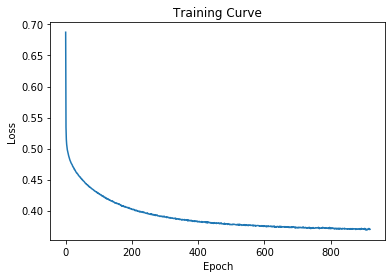

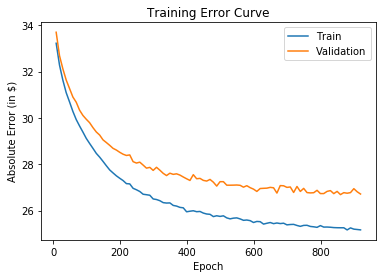

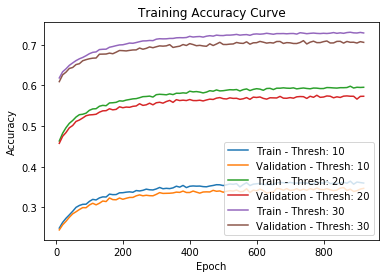

---[ITER 10] loss: 0.374663  time: 2.747
---[ITER 20] loss: 0.368174  time: 2.730
---[ITER 30] loss: 0.363302  time: 2.747
---[ITER 40] loss: 0.359255  time: 2.713
---[ITER 50] loss: 0.366987  time: 2.754
---[ITER 60] loss: 0.366010  time: 2.744
---[ITER 70] loss: 0.368937  time: 2.767
---[ITER 80] loss: 0.369470  time: 2.905
---[ITER 90] loss: 0.373322  time: 2.904
---[ITER 100] loss: 0.375456  time: 2.699
---[ITER 110] loss: 0.379295  time: 2.795
---[ITER 120] loss: 0.364487  time: 2.706
---[ITER 130] loss: 0.370270  time: 2.781
---[ITER 140] loss: 0.372655  time: 2.789
---[ITER 150] loss: 0.375678  time: 2.758
---[ITER 160] loss: 0.366871  time: 2.698
[EPOCH 921] loss: 0.370096  time: 46.477
---[ITER 10] loss: 0.373546  time: 2.990
---[ITER 20] loss: 0.365683  time: 2.971
---[ITER 30] loss: 0.374942  time: 2.901
---[ITER 40] loss: 0.361240  time: 2.720
---[ITER 50] loss: 0.370833  time: 2.749
---[ITER 60] loss: 0.369869  time: 2.741
---[ITER 70] loss: 0.363513  time: 2.727
---[ITER 

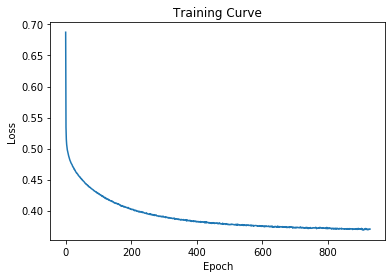

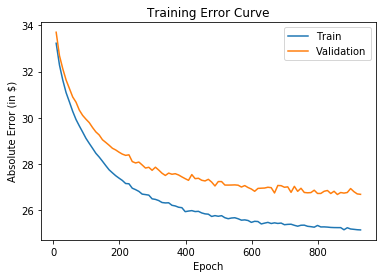

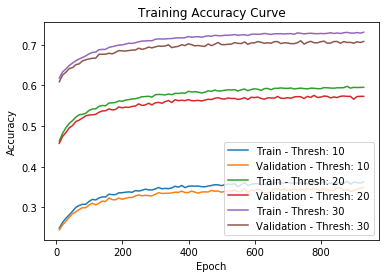

---[ITER 10] loss: 0.367928  time: 2.766
---[ITER 20] loss: 0.379513  time: 2.885
---[ITER 30] loss: 0.373534  time: 2.797
---[ITER 40] loss: 0.370124  time: 2.818
---[ITER 50] loss: 0.366964  time: 2.725
---[ITER 60] loss: 0.368891  time: 2.730
---[ITER 70] loss: 0.374283  time: 2.710
---[ITER 80] loss: 0.375031  time: 2.733
---[ITER 90] loss: 0.364163  time: 2.753
---[ITER 100] loss: 0.375576  time: 2.712
---[ITER 110] loss: 0.365421  time: 2.870
---[ITER 120] loss: 0.365334  time: 2.791
---[ITER 130] loss: 0.370213  time: 2.805
---[ITER 140] loss: 0.365296  time: 2.759
---[ITER 150] loss: 0.371240  time: 2.705
---[ITER 160] loss: 0.365086  time: 2.777
[EPOCH 931] loss: 0.369653  time: 46.475
---[ITER 10] loss: 0.366870  time: 2.729
---[ITER 20] loss: 0.366500  time: 2.688
---[ITER 30] loss: 0.370307  time: 2.877
---[ITER 40] loss: 0.374420  time: 2.688
---[ITER 50] loss: 0.363900  time: 2.736
---[ITER 60] loss: 0.376992  time: 2.696
---[ITER 70] loss: 0.370418  time: 2.663
---[ITER 

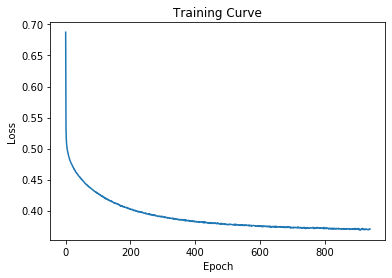

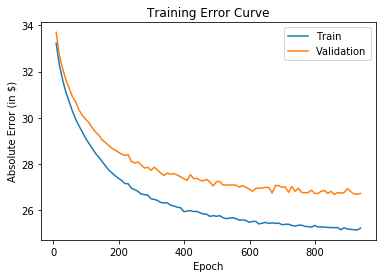

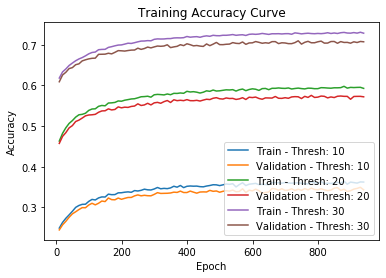

---[ITER 10] loss: 0.373267  time: 2.676
---[ITER 20] loss: 0.368711  time: 2.693
---[ITER 30] loss: 0.366120  time: 2.740
---[ITER 40] loss: 0.363846  time: 2.677
---[ITER 50] loss: 0.371289  time: 2.689
---[ITER 60] loss: 0.367633  time: 2.949
---[ITER 70] loss: 0.373590  time: 2.711
---[ITER 80] loss: 0.374954  time: 2.692
---[ITER 90] loss: 0.372439  time: 2.679
---[ITER 100] loss: 0.369237  time: 2.721
---[ITER 110] loss: 0.372105  time: 2.802
---[ITER 120] loss: 0.370331  time: 2.746
---[ITER 130] loss: 0.365290  time: 2.677
---[ITER 140] loss: 0.372604  time: 2.893
---[ITER 150] loss: 0.373074  time: 2.706
---[ITER 160] loss: 0.371058  time: 2.717
[EPOCH 941] loss: 0.369762  time: 45.865
---[ITER 10] loss: 0.374879  time: 2.687
---[ITER 20] loss: 0.369866  time: 2.694
---[ITER 30] loss: 0.369878  time: 2.700
---[ITER 40] loss: 0.365633  time: 2.711
---[ITER 50] loss: 0.361508  time: 2.671
---[ITER 60] loss: 0.371719  time: 2.664
---[ITER 70] loss: 0.362136  time: 2.767
---[ITER 

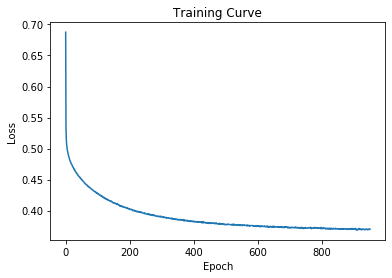

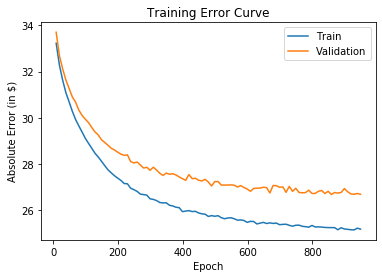

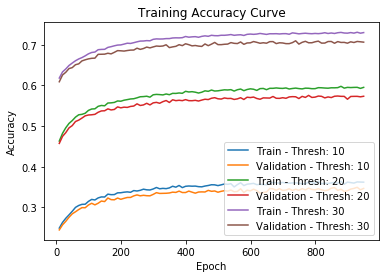

---[ITER 10] loss: 0.369786  time: 2.803
---[ITER 20] loss: 0.371372  time: 2.959
---[ITER 30] loss: 0.372900  time: 2.914
---[ITER 40] loss: 0.368484  time: 2.887
---[ITER 50] loss: 0.371888  time: 2.755
---[ITER 60] loss: 0.366273  time: 2.917
---[ITER 70] loss: 0.367571  time: 2.847
---[ITER 80] loss: 0.374320  time: 2.710
---[ITER 90] loss: 0.369625  time: 2.784
---[ITER 100] loss: 0.367953  time: 2.797
---[ITER 110] loss: 0.366913  time: 2.912
---[ITER 120] loss: 0.372270  time: 3.066
---[ITER 130] loss: 0.366602  time: 2.929
---[ITER 140] loss: 0.370013  time: 2.846
---[ITER 150] loss: 0.363733  time: 2.822
---[ITER 160] loss: 0.369534  time: 2.810
[EPOCH 951] loss: 0.369527  time: 47.969
---[ITER 10] loss: 0.370947  time: 2.916
---[ITER 20] loss: 0.368729  time: 2.928
---[ITER 30] loss: 0.370300  time: 2.858
---[ITER 40] loss: 0.371667  time: 2.942
---[ITER 50] loss: 0.371890  time: 2.850
---[ITER 60] loss: 0.364374  time: 2.793
---[ITER 70] loss: 0.375106  time: 3.107
---[ITER 

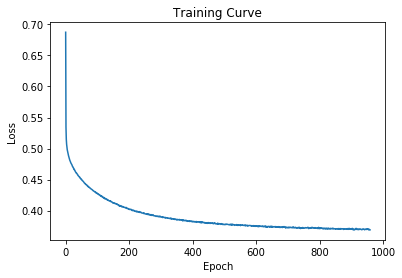

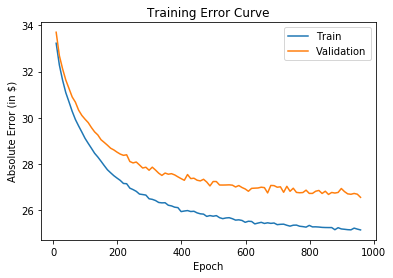

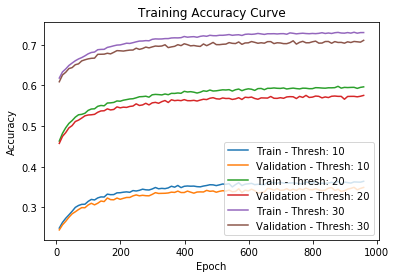

---[ITER 10] loss: 0.369324  time: 2.865
---[ITER 20] loss: 0.357928  time: 2.826
---[ITER 30] loss: 0.369782  time: 2.876
---[ITER 40] loss: 0.365002  time: 2.825
---[ITER 50] loss: 0.370868  time: 2.960
---[ITER 60] loss: 0.371301  time: 3.077
---[ITER 70] loss: 0.367832  time: 2.923
---[ITER 80] loss: 0.374735  time: 2.948
---[ITER 90] loss: 0.366776  time: 3.002
---[ITER 100] loss: 0.370142  time: 2.848
---[ITER 110] loss: 0.373424  time: 2.900
---[ITER 120] loss: 0.366737  time: 2.950
---[ITER 130] loss: 0.371426  time: 2.893
---[ITER 140] loss: 0.370204  time: 3.004
---[ITER 150] loss: 0.377314  time: 2.811
---[ITER 160] loss: 0.365513  time: 2.752
[EPOCH 961] loss: 0.369497  time: 48.572
---[ITER 10] loss: 0.369303  time: 2.719
---[ITER 20] loss: 0.367569  time: 2.699
---[ITER 30] loss: 0.376628  time: 2.696
---[ITER 40] loss: 0.370044  time: 2.683
---[ITER 50] loss: 0.366141  time: 2.869
---[ITER 60] loss: 0.371181  time: 2.880
---[ITER 70] loss: 0.363250  time: 2.888
---[ITER 

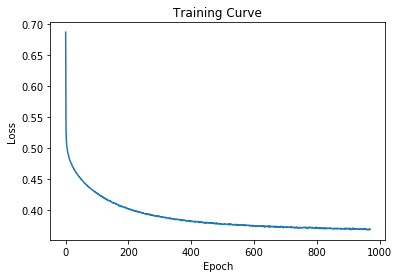

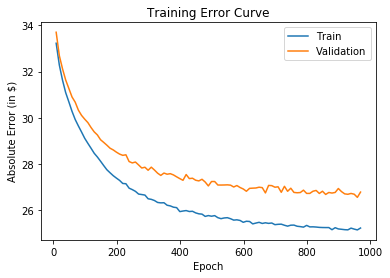

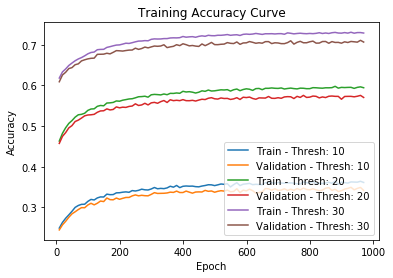

---[ITER 10] loss: 0.370040  time: 2.948
---[ITER 20] loss: 0.364251  time: 2.892
---[ITER 30] loss: 0.374147  time: 2.893
---[ITER 40] loss: 0.364762  time: 2.896
---[ITER 50] loss: 0.370876  time: 2.898
---[ITER 60] loss: 0.368312  time: 2.728
---[ITER 70] loss: 0.363904  time: 2.785
---[ITER 80] loss: 0.376906  time: 2.754
---[ITER 90] loss: 0.368066  time: 2.723
---[ITER 100] loss: 0.365712  time: 2.862
---[ITER 110] loss: 0.365309  time: 2.810
---[ITER 120] loss: 0.382749  time: 2.786
---[ITER 130] loss: 0.372358  time: 2.771
---[ITER 140] loss: 0.372914  time: 2.689
---[ITER 150] loss: 0.364832  time: 2.736
---[ITER 160] loss: 0.371542  time: 2.741
[EPOCH 971] loss: 0.369686  time: 47.037
---[ITER 10] loss: 0.367842  time: 2.751
---[ITER 20] loss: 0.366980  time: 2.762
---[ITER 30] loss: 0.371844  time: 2.823
---[ITER 40] loss: 0.369214  time: 2.900
---[ITER 50] loss: 0.368688  time: 2.737
---[ITER 60] loss: 0.369684  time: 2.863
---[ITER 70] loss: 0.371060  time: 2.999
---[ITER 

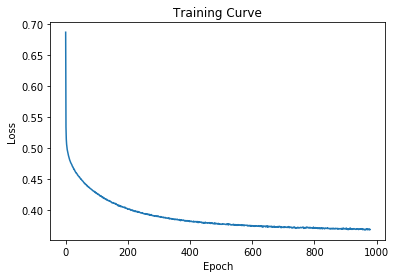

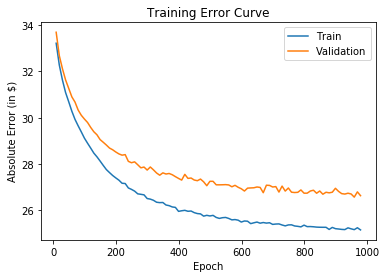

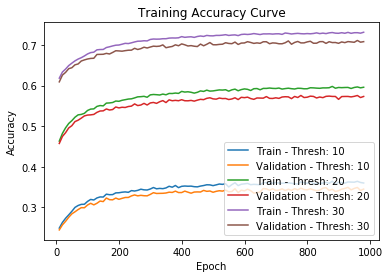

---[ITER 10] loss: 0.378065  time: 2.764
---[ITER 20] loss: 0.370954  time: 2.764
---[ITER 30] loss: 0.373442  time: 2.736
---[ITER 40] loss: 0.369435  time: 2.769
---[ITER 50] loss: 0.361101  time: 2.779
---[ITER 60] loss: 0.366692  time: 2.711
---[ITER 70] loss: 0.367292  time: 2.801
---[ITER 80] loss: 0.378645  time: 2.823
---[ITER 90] loss: 0.358921  time: 2.785
---[ITER 100] loss: 0.367080  time: 2.830
---[ITER 110] loss: 0.369203  time: 2.832
---[ITER 120] loss: 0.361528  time: 2.938
---[ITER 130] loss: 0.372231  time: 2.800
---[ITER 140] loss: 0.367146  time: 2.828
---[ITER 150] loss: 0.370495  time: 2.808
---[ITER 160] loss: 0.361872  time: 2.665
[EPOCH 981] loss: 0.368568  time: 46.780
---[ITER 10] loss: 0.362812  time: 2.799
---[ITER 20] loss: 0.376428  time: 2.639
---[ITER 30] loss: 0.370715  time: 2.633
---[ITER 40] loss: 0.362217  time: 2.904
---[ITER 50] loss: 0.369720  time: 2.779
---[ITER 60] loss: 0.370358  time: 2.616
---[ITER 70] loss: 0.371379  time: 2.630
---[ITER 

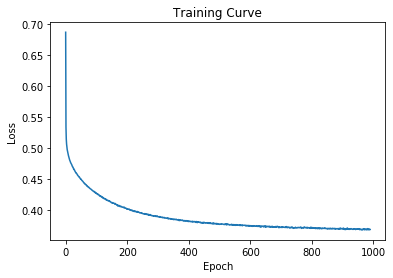

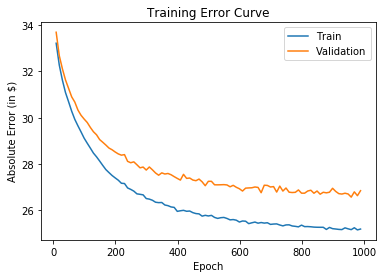

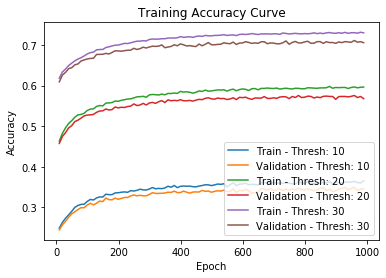

---[ITER 10] loss: 0.368645  time: 2.908
---[ITER 20] loss: 0.361733  time: 2.873
---[ITER 30] loss: 0.372860  time: 2.859
---[ITER 40] loss: 0.369530  time: 2.848
---[ITER 50] loss: 0.368994  time: 2.870
---[ITER 60] loss: 0.363813  time: 2.800
---[ITER 70] loss: 0.369031  time: 2.657
---[ITER 80] loss: 0.366833  time: 2.857
---[ITER 90] loss: 0.366949  time: 2.737
---[ITER 100] loss: 0.372648  time: 2.733
---[ITER 110] loss: 0.365548  time: 2.813
---[ITER 120] loss: 0.367286  time: 2.620
---[ITER 130] loss: 0.367405  time: 2.605
---[ITER 140] loss: 0.363139  time: 2.655
---[ITER 150] loss: 0.373148  time: 2.661
---[ITER 160] loss: 0.371446  time: 2.700
[EPOCH 991] loss: 0.368362  time: 46.291
---[ITER 10] loss: 0.369688  time: 2.680
---[ITER 20] loss: 0.367288  time: 2.808
---[ITER 30] loss: 0.371880  time: 2.902
---[ITER 40] loss: 0.369616  time: 2.723
---[ITER 50] loss: 0.374625  time: 2.800
---[ITER 60] loss: 0.368816  time: 2.861
---[ITER 70] loss: 0.368655  time: 2.802
---[ITER 

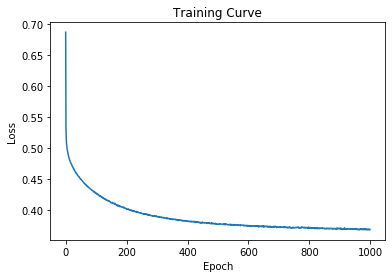

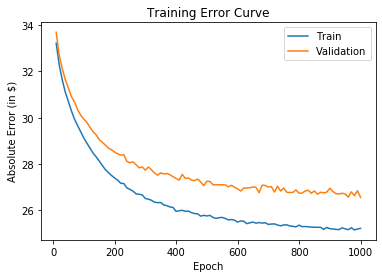

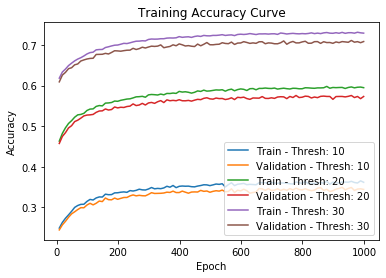

Training Completed...
[FINAL] loss: 0.368692  time: 75927.661


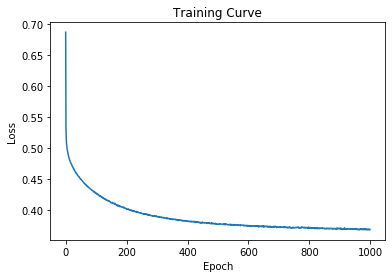

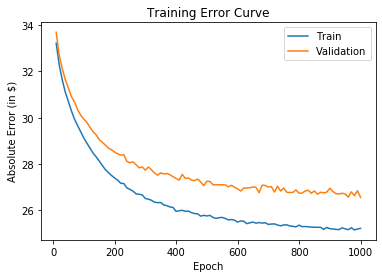

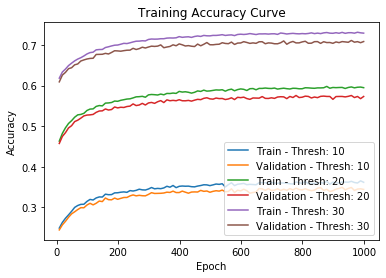

In [46]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1000)

In [47]:
checkpoint = torch.load("../test/Brian/nov19_test02/final/checkpoint_final.tar")

In [48]:
print("Minimum Train Error:\t\t", min(checkpoint["train_error"]))
print("Index of Min Train Error:\t", checkpoint["train_error"].index(min(checkpoint["train_error"])))
print("Minimum Val Error:\t\t", min(checkpoint["val_error"]))
print("Index of Min Val Error:\t\t", checkpoint["val_error"].index(min(checkpoint["val_error"])))

Minimum Train Error:		 25.146995129323773
Index of Min Train Error:	 97
Minimum Val Error:		 26.552404164380786
Index of Min Val Error:		 99


In [49]:
print("For Threshold=20")
print("Maximum Train Accuracy:\t", max(checkpoint["train_acc"][1]))
print("Index of Max Train Acc:\t", checkpoint["train_acc"][1].index(max(checkpoint["train_acc"][1])))
print("Maximum Val Accuracy:\t", max(checkpoint["val_acc"][1]))
print("Index of Max Val Acc:\t", checkpoint["val_acc"][1].index(max(checkpoint["val_acc"][1])))

For Threshold=20
Maximum Train Accuracy:	 0.5979712806812489
Index of Max Train Acc:	 87
Maximum Val Accuracy:	 0.5756607193970041
Index of Max Val Acc:	 77
